<a href="https://colab.research.google.com/github/Paolo-eng/EegNew/blob/main/MyThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTAZIONI DI FILES E LIBRERIE

In [ ]:
# importo google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copio i files da google drive in locale
!cp -r drive/MyDrive/EEG_NOME /content/eegFiles

In [ ]:

# MNE-Python è una libreria open-source in Python utilizzata per l'analisi delle neuroscienze. È progettata per l'analisi dei segnali EEG (elettroencefalogramma), MEG (magnetoencefalogramma) e altri dati neurofisiologici. Il nome "MNE" sta per "M/EEG elettroencefalografia / magnetoencefalografia".
# MNE-Python fornisce una vasta gamma di funzionalità per la pre-elaborazione, l'analisi e la visualizzazione dei dati neurofisiologici. Alcune delle sue caratteristiche principali includono:
# Pre-elaborazione dei dati: MNE-Python offre strumenti per filtrare, ritagliare, epocare e mediare i dati EEG/MEG prima dell'analisi.
!pip install mne
# installazione libreria PyTorch Geometric  è una libreria che fornisce per la costruzione
# e l'addestramento di reti neurali su dati non euclidei, come i grafi e le mesh.
!pip install torch_geometric -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00


In [ ]:
# importazione librerie
from torch.utils.data import random_split
import mne
import numpy as np
import glob
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.signal import coherence
from scipy.signal import hilbert
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn import Dropout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import from_networkx
from random import choices
from collections import defaultdict
import seaborn as sns
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import KFold
from scipy.sparse import coo_matrix
from torch_geometric.utils import from_scipy_sparse_matrix
import time
import pandas as pd
from torch.nn import Linear
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
from scipy.stats import ttest_ind, mannwhitneyu
import pywt
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import entropy
from scipy.signal import welch, find_peaks
from pywt import wavedec
from statsmodels.stats.multitest import multipletests
from scipy.stats import  kruskal
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# riproducibilità
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
all_file_path = glob.glob('/content/eegFiles/sub*.set')
all_file_path.sort()
print('Lunghezza lista:', len(all_file_path))
print(f'Primo file:  {all_file_path[0]} \n...\nUltimo file: {all_file_path[-1]}')
alz_file_path = glob.glob('/content/eegFiles/sub*Alzheimer.set')
alz_file_path.sort()
print('Lunghezza lista:', len(alz_file_path))
print(f'Primo file:  {alz_file_path[0]} \n...\nUltimo file: {alz_file_path[-1]}')
norm_file_path = glob.glob('/content/eegFiles/sub*Normal.set')
norm_file_path.sort()
print('Lunghezza lista:', len(norm_file_path))
print(f'Primo file:  {norm_file_path[0]} \n...\nUltimo file: {norm_file_path[-1]}')
ftd_file_path = glob.glob('/content/eegFiles/sub*FTD.set')
ftd_file_path.sort()
print('Lunghezza lista:', len(ftd_file_path))
print(f'Primo file:  {ftd_file_path[0]} \n...\nUltimo file: {ftd_file_path[-1]}')

Lunghezza lista: 88
Primo file:  /content/eegFiles/sub-001_task-eyesclosed_eeg_Alzheimer.set 
...
Ultimo file: /content/eegFiles/sub-088_task-eyesclosed_eeg_FTD.set
Lunghezza lista: 36
Primo file:  /content/eegFiles/sub-001_task-eyesclosed_eeg_Alzheimer.set 
...
Ultimo file: /content/eegFiles/sub-036_task-eyesclosed_eeg_Alzheimer.set
Lunghezza lista: 29
Primo file:  /content/eegFiles/sub-037_task-eyesclosed_eeg_Normal.set 
...
Ultimo file: /content/eegFiles/sub-065_task-eyesclosed_eeg_Normal.set
Lunghezza lista: 23
Primo file:  /content/eegFiles/sub-066_task-eyesclosed_eeg_FTD.set 
...
Ultimo file: /content/eegFiles/sub-088_task-eyesclosed_eeg_FTD.set


#PRINCIPALI FUNZIONI

In [ ]:

# FUNZIONI DI CATTURA EPOCHE EEG
def normalize_features(node_features):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    # Fit and transform the features
    normalized_features = scaler.fit_transform(node_features)
    return normalized_features
# Applicazione soglia ai valori delle matrici
def apply_threshold(matrix, threshold):
    thresholded_matrix = np.where(matrix >= threshold, matrix, 0)
    return thresholded_matrix
# Applicazione soglia binaria ai valori delle matrici
def apply_threshold_bin(matrix, threshold):
    thresholded_matrix = np.where(matrix >= threshold, 1, 0)
    return thresholded_matrix
# cattura i dati, estrae le epoche e salva i valori in un array di shape (trials,channel,length)

def read_data(file_path):
    raw=mne.io.read_raw_eeglab(file_path,preload=True)
    # Aggiungo annotazioni 'bad' per i boundaries (le epoche con i boundaries sono trascurate )
    annotations = raw.annotations
    boundary_annotations = [annot for annot in annotations if 'boundary' in annot['description'].lower()]
    # Aggiungo una nuova annotazione "bad_boundary" per ogni boundary
    for annot in boundary_annotations:
        raw.annotations.append(annot['onset'], annot['duration'], 'bad_boundary')
    # taglio il primo  secondo di registrazione poiché in alcuni records i segnali sono flat
    raw.crop(tmin=1,tmax=raw.times[-1])
    #raw.set_eeg_reference()
    # applico un ulteriore filtro passa banda
    raw.filter(l_freq=0.5,h_freq=40)
    # estraggo il dato raw
    data = raw.get_data()
    # Applico la z-score normalization usando StandardScaler
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data.T).T  # Transpose per adattare la forma
    # Sostituisci i dati normalizzati nel file raw originario
    raw._data = normalized_data
    # estraggo delle epoche ciascuna di 25 sec
    # variazioni
    # epochs=mne.make_fixed_length_epochs(raw,duration=25,overlap=5,reject_by_annotation=True) -
    epochs=mne.make_fixed_length_epochs(raw,duration=25,overlap=5,reject_by_annotation=True)  #+
    epochs=epochs.get_data()
    return epochs #trials,channel,length



In [ ]:
# ESTRAZIONI NODE FEATURES

def extract_node_features(data, sfreq):
    n_channels, n_times = data.shape
    num_features = 110
    features = np.zeros((n_channels, num_features))  # 10 features per channel

    def calculate_crest_factor(signal):
        peak = np.max(np.abs(signal))
        rms = np.sqrt(np.mean(np.square(signal)))
        return peak / rms
    def calculate_zero_crossings(signal):
        return ((signal[:-1] * signal[1:]) < 0).sum()

    def calculate_phase_sync(signal1, signal2,fmin,fmax):
        f, Cxy = coherence(signal1, signal2, fs=500, nperseg=sfreq*2)
        coherence_value = np.mean(Cxy[(f >= fmin) & (f <= fmax)])
        return coherence_value

    def calculate_plv(signal1, signal2, fs, fmin, fmax):
        # Applicare il filtro passa-banda ai segnali
        filtered_signal1 = bandpass_filter(signal1, fmin, fmax, fs)
        filtered_signal2 = bandpass_filter(signal2, fmin, fmax, fs)

        # Trasformata di Hilbert per ottenere la fase istantanea
        analytic_signal1 = hilbert(filtered_signal1)
        phase1 = np.angle(analytic_signal1)

        analytic_signal2 = hilbert(filtered_signal2)
        phase2 = np.angle(analytic_signal2)

        # Differenza di fase istantanea
        phase_diff = phase1 - phase2

        # Calcolo  PLV
        plv = np.abs(np.sum(np.exp(1j * phase_diff)) / len(phase_diff))
        return plv

    # Calcolo matrice di pearson
    def compute_pearson(signal1,signal2,fs,fmin,fmax):
        sfreq = 500
        filtered_signal1 = bandpass_filter(signal1, fmin, fmax, fs)
        filtered_signal2 = bandpass_filter(signal2, fmin, fmax, fs)
        correlation, p_value = pearsonr(signal1, signal2)
        return correlation

    signal_0 = data[0, :]
    signal_1 = data[1, :]
    signal_2 = data[2, :]
    signal_3 = data[3, :]
    signal_4 = data[4, :]
    signal_5 = data[5, :]
    signal_6 = data[6, :]
    signal_7 = data[7, :]
    signal_8 = data[8, :]
    signal_9 = data[9, :]
    signal_10 = data[10, :]
    signal_11 = data[11, :]
    signal_12 = data[12, :]
    signal_13 = data[13, :]
    signal_14 = data[14, :]
    signal_15 = data[15, :]
    signal_16 = data[16, :]
    signal_17 = data[17, :]

    for ch in range(n_channels):
        signal = data[ch, :]
        # Basic statistical features
        features[ch, 0] = np.mean(signal)
        features[ch, 1] = np.var(signal)
        features[ch, 2] = skew(signal)
        features[ch, 3] = kurtosis(signal)

        #  Band power features
        f, psd = welch(signal, fs=sfreq, nperseg=sfreq*2)
        delta_power = np.sum(psd[(f >= 1) & (f < 4)])
        theta_power = np.sum(psd[(f >= 4) & (f < 8)])
        alpha_power = np.sum(psd[(f >= 8) & (f < 13)])
        beta_power = np.sum(psd[(f >= 13) & (f < 30)])
        gamma_power = np.sum(psd[(f >= 30) & (f < 40)])
        features[ch, 4] = delta_power
        features[ch, 5] = theta_power
        features[ch, 6] = alpha_power
        features[ch, 7] = beta_power
        features[ch, 8] = gamma_power
        features[ch,9] = np.std(signal)
        features[ch,10] = np.ptp(signal)
        features[ch,11] = np.min(signal)
        features[ch,12] = np.max(signal)
        features[ch,13] = np.argmin(signal)
        features[ch,14] = np.argmax(signal)
        features[ch,15] = np.sqrt(np.mean(signal**2))
        features[ch,16] = np.sum(np.abs(np.diff(signal)))
        features[ch,17] = entropy(np.histogram(signal, bins=256)[0])
        features[ch,18] = calculate_crest_factor(signal)
        features[ch,19] = calculate_zero_crossings(signal)
        features[ch,20] = calculate_plv(signal_0,signal,500,1,4)
        features[ch,21] = calculate_plv(signal_1,signal,500,1,4)
        features[ch,22] = calculate_plv(signal_2,signal,500,1,4)
        features[ch,23] = calculate_plv(signal_3,signal,500,1,4)
        features[ch,24] = calculate_plv(signal_4,signal,500,1,4)
        features[ch,25] = calculate_plv(signal_5,signal,500,1,4)
        features[ch,26] = calculate_plv(signal_6,signal,500,1,4)
        features[ch,27] = calculate_plv(signal_7,signal,500,1,4)
        features[ch,28] = calculate_plv(signal_8,signal,500,1,4)
        features[ch,29] = calculate_plv(signal_9,signal,500,1,4)
        features[ch,30] = calculate_plv(signal_10,signal,500,1,4)
        features[ch,31] = calculate_plv(signal_11,signal,500,1,4)
        features[ch,32] = calculate_plv(signal_12,signal,500,1,4)
        features[ch,33] = calculate_plv(signal_13,signal,500,1,4)
        features[ch,34] = calculate_plv(signal_14,signal,500,1,4)
        features[ch,35] = calculate_plv(signal_15,signal,500,1,4)
        features[ch,36] = calculate_plv(signal_16,signal,500,1,4)
        features[ch,37] = calculate_plv(signal_17,signal,500,1,4)
        features[ch,38] = calculate_plv(signal_0,signal,500,4,8)
        features[ch,39] = calculate_plv(signal_1,signal,500,4,8)
        features[ch,40] = calculate_plv(signal_2,signal,500,4,8)
        features[ch,41] = calculate_plv(signal_3,signal,500,4,8)
        features[ch,42] = calculate_plv(signal_4,signal,500,4,8)
        features[ch,43] = calculate_plv(signal_5,signal,500,4,8)
        features[ch,44] = calculate_plv(signal_6,signal,500,4,8)
        features[ch,45] = calculate_plv(signal_7,signal,500,4,8)
        features[ch,46] = calculate_plv(signal_8,signal,500,4,8)
        features[ch,47] = calculate_plv(signal_9,signal,500,4,8)
        features[ch,48] = calculate_plv(signal_10,signal,500,4,8)
        features[ch,49] = calculate_plv(signal_11,signal,500,4,8)
        features[ch,50] = calculate_plv(signal_12,signal,500,4,8)
        features[ch,51] = calculate_plv(signal_13,signal,500,4,8)
        features[ch,52] = calculate_plv(signal_14,signal,500,4,8)
        features[ch,53] = calculate_plv(signal_15,signal,500,4,8)
        features[ch,54] = calculate_plv(signal_16,signal,500,4,8)
        features[ch,55] = calculate_plv(signal_17,signal,500,4,8)
        features[ch,56] = calculate_plv(signal_0,signal,500,8,13)
        features[ch,57] = calculate_plv(signal_1,signal,500,8,13)
        features[ch,58] = calculate_plv(signal_2,signal,500,8,13)
        features[ch,59] = calculate_plv(signal_3,signal,500,8,13)
        features[ch,60] = calculate_plv(signal_4,signal,500,8,13)
        features[ch,61] = calculate_plv(signal_5,signal,500,8,13)
        features[ch,62] = calculate_plv(signal_6,signal,500,8,13)
        features[ch,63] = calculate_plv(signal_7,signal,500,8,13)
        features[ch,64] = calculate_plv(signal_8,signal,500,8,13)
        features[ch,65] = calculate_plv(signal_9,signal,500,8,13)
        features[ch,66] = calculate_plv(signal_10,signal,500,8,13)
        features[ch,67] = calculate_plv(signal_11,signal,500,8,13)
        features[ch,68] = calculate_plv(signal_12,signal,500,8,13)
        features[ch,69] = calculate_plv(signal_13,signal,500,8,13)
        features[ch,70] = calculate_plv(signal_14,signal,500,8,13)
        features[ch,71] = calculate_plv(signal_15,signal,500,8,13)
        features[ch,72] = calculate_plv(signal_16,signal,500,8,13)
        features[ch,73] = calculate_plv(signal_17,signal,500,8,13)
        features[ch,74] = calculate_plv(signal_0,signal,500,13,30)
        features[ch,75] = calculate_plv(signal_1,signal,500,13,30)
        features[ch,76] = calculate_plv(signal_2,signal,500,13,30)
        features[ch,77] = calculate_plv(signal_3,signal,500,13,30)
        features[ch,78] = calculate_plv(signal_4,signal,500,13,30)
        features[ch,79] = calculate_plv(signal_5,signal,500,13,30)
        features[ch,80] = calculate_plv(signal_6,signal,500,13,30)
        features[ch,81] = calculate_plv(signal_7,signal,500,13,30)
        features[ch,82] = calculate_plv(signal_8,signal,500,13,30)
        features[ch,83] = calculate_plv(signal_9,signal,500,13,30)
        features[ch,84] = calculate_plv(signal_10,signal,500,13,30)
        features[ch,85] = calculate_plv(signal_11,signal,500,13,30)
        features[ch,86] = calculate_plv(signal_12,signal,500,13,30)
        features[ch,87] = calculate_plv(signal_13,signal,500,13,30)
        features[ch,88] = calculate_plv(signal_14,signal,500,13,30)
        features[ch,89] = calculate_plv(signal_15,signal,500,13,30)
        features[ch,90] = calculate_plv(signal_16,signal,500,13,30)
        features[ch,91] = calculate_plv(signal_17,signal,500,13,30)
        features[ch,92] = calculate_plv(signal_0,signal,500,30,40)
        features[ch,93] = calculate_plv(signal_1,signal,500,30,40)
        features[ch,94] = calculate_plv(signal_2,signal,500,30,40)
        features[ch,95] = calculate_plv(signal_3,signal,500,30,40)
        features[ch,96] = calculate_plv(signal_4,signal,500,30,40)
        features[ch,97] = calculate_plv(signal_5,signal,500,30,40)
        features[ch,98] = calculate_plv(signal_6,signal,500,30,40)
        features[ch,99] = calculate_plv(signal_7,signal,500,30,40)
        features[ch,100] = calculate_plv(signal_8,signal,500,30,40)
        features[ch,101] = calculate_plv(signal_9,signal,500,30,40)
        features[ch,102] = calculate_plv(signal_10,signal,500,30,40)
        features[ch,103] = calculate_plv(signal_11,signal,500,30,40)
        features[ch,104] = calculate_plv(signal_12,signal,500,30,40)
        features[ch,105] = calculate_plv(signal_13,signal,500,30,40)
        features[ch,106] = calculate_plv(signal_14,signal,500,30,40)
        features[ch,107] = calculate_plv(signal_15,signal,500,30,40)
        features[ch,108] = calculate_plv(signal_16,signal,500,30,40)
        features[ch,109] = calculate_plv(signal_17,signal,500,30,40)




    return normalize_features(features)

In [ ]:
# FUNZIONI PER CALCOLARE LE MATRICI DI ADIACENZA

# filtro passabanda
from scipy.signal import butter, filtfilt
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# calcolo matrice di pearson
def compute_pearson_matrix(data,threshold,fmin,fmax):
    sfreq = 500
    filtered_eeg_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        filtered_eeg_data[i, :] = bandpass_filter(data[i, :], fmin, fmax, sfreq)
    n_channels = filtered_eeg_data.shape[0]
    pearson_matrix = np.corrcoef(filtered_eeg_data)
    np.fill_diagonal(pearson_matrix, 0)
    pearson_matrix = apply_threshold(pearson_matrix, threshold)
    return pearson_matrix

# calcolo matrice di coerenza
def compute_coherence_matrix(data, threshold,fmin,fmax):
    sfreq = 500
    n_channels = data.shape[0]
    coherence_matrix = np.zeros((n_channels, n_channels))
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            f, Cxy = coherence(data[i, :], data[j, :], fs=sfreq, nperseg=sfreq*2)
            coherence_value = np.mean(Cxy[(f >= fmin) & (f <= fmax)])
            coherence_matrix[i, j] = coherence_value
            coherence_matrix[j, i] = coherence_value
    return  apply_threshold(coherence_matrix, threshold)

# calcolo matrice PLV
def compute_plv_matrix(data,threshold,fmin,fmax):
    sfreq = 500
    filtered_eeg_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        filtered_eeg_data[i, :] = bandpass_filter(data[i, :], fmin, fmax, sfreq)
    n_channels = filtered_eeg_data.shape[0]
    plv_matrix = np.zeros((n_channels, n_channels))
    analytic_signal = hilbert(filtered_eeg_data, axis=1)
    phase = np.angle(analytic_signal)
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            phase_diff = phase[i, :] - phase[j, :]
            plv = np.abs(np.sum(np.exp(1j * phase_diff)) / len(phase_diff))
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv
    return  apply_threshold(plv_matrix, threshold)




#ESTRAZIONE EPOCHE, FEATURES_ARRAY E MATRICI DI ADIACENZA
In questa fase si è andati alla ricerca delle features da associare ai nodi e i valori da assegnare alle matrici di adiacenza che, secondo dei coefficienti statistici mostrano delle differenze tali che è molto improbabile siano dovute al caso.
Nel catturare le features si è cercato di raggiungere un buon compromesso tra la loro specificità e la complessità computazionale di calcolo. L'elenco delle node features è di seguito descritto, suddiviso nelle categorie del dominio del tempo.  Nel dettaglio le features utilizzate sono:

NODE FEATURES
1.   media
2.   varianza
3.   skewness
4.   kurtosis
5.   power spectral density per onde delta, theta, alpha, beta, gamma
6.   standard deviation
7.   ptp
8.   min
9.   max
10.  argmin
11.  argmax
12.  rms
13.  abs difference
14.  entropia
15.  crest factor
16.  zero crossing
18.  plv di ciascun segnale rispetto a tutti gli altri

CORRELATION MATRIX
1.   Pearson per onde delta e theta
2.   Coherence per onde delta e theta
3.   PLV per onde delta e theta

In [ ]:
%%capture
#ESTRAZIONE EPOCHE

# estraggo le epoche per i records di pazienti Alzheimer
alz_epochs_list=[read_data(subject) for subject in alz_file_path]

# estraggo le epoche per i records di pazienti Normal
norm_epochs_list=[read_data(subject) for subject in norm_file_path]

#  # estraggo le epoche per i records di pazienti FTD
ftd_epochs_list=[read_data(subject) for subject in ftd_file_path]


In [ ]:
# ESTRAZIONI ARRAY DELLE MATRICI E ARRAY DELLE FEATURES DI PAZIENTI ALZHEIMER

# Liste di output
alz_features_list = []
alz_adjacency_pearson_matrices_list_theta = []
alz_adjacency_coherence_matrices_list_theta = []
alz_adjacency_plv_matrices_list_theta = []
# Funzione per processare le liste di epoche
def process_epochs_list(epochs_list):
    for patient_epochs in epochs_list:
        for epoch in patient_epochs:
            features = extract_node_features(epoch,500)
            alz_features_list.append(features)



            adj_pearson_theta = compute_pearson_matrix(epoch, threshold_pearson_theta,4,8)
            alz_adjacency_pearson_matrices_list_theta.append(adj_pearson_theta)

            adj_coherence_theta = compute_coherence_matrix(epoch, threshold_coherence_theta,4,8)
            alz_adjacency_coherence_matrices_list_theta.append(adj_coherence_theta)

            adj_plv_theta = compute_plv_matrix(epoch, threshold_plv_theta,4,8)
            alz_adjacency_plv_matrices_list_theta.append(adj_plv_theta)

# Soglie per le matrici di adiacenza

threshold_pearson_theta = 0
threshold_coherence_theta = 0
threshold_plv_theta = 0

# Processa tutte la lista Alzheimer
process_epochs_list(alz_epochs_list)  # 0 per Alzheimer

# Converto le liste in array per un uso più efficiente
alz_features_array = np.array(alz_features_list)
alz_adjacency_pearson_matrices_array_theta = np.array(alz_adjacency_pearson_matrices_list_theta)
alz_adjacency_coherence_matrices_array_theta = np.array(alz_adjacency_coherence_matrices_list_theta)
alz_adjacency_plv_matrices_array_theta = np.array(alz_adjacency_plv_matrices_list_theta)

# Verifica delle dimensioni
print(f'Alzheimer Features array shape: {alz_features_array.shape}')  # (num_epoche, 19, 10)
print(f'Adjacency Pearson matrices array theta shape: {alz_adjacency_pearson_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
print(f'Adjacency Coherence matrices array theta shape: {alz_adjacency_coherence_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
print(f'Adjacency PLV matrices array theta shape: {alz_adjacency_plv_matrices_array_theta.shape}')  # (num_epoche, 19, 19)


# Ora ho le caratteristiche, le matrici di adiacenza separate e le etichette pronte per la  GCN


In [ ]:
# ESTRAZIONI ARRAY DELLE MATRICI E ARRAY DELLE FEATURES DI PAZIENTI NORMALI

# Liste di output
nor_features_list = []
nor_adjacency_pearson_matrices_list_theta = []
nor_adjacency_coherence_matrices_list_theta = []
nor_adjacency_plv_matrices_list_theta = []

# Funzione per processare le liste di epoche
def process_epochs_list(epochs_list):
    for patient_epochs in epochs_list:
        for epoch in patient_epochs:
            features = extract_node_features(epoch,500)
            nor_features_list.append(features)
            adj_pearson_theta = compute_pearson_matrix(epoch, threshold_pearson_theta,4,8)
            nor_adjacency_pearson_matrices_list_theta.append(adj_pearson_theta)
            adj_coherence_theta = compute_coherence_matrix(epoch, threshold_coherence_theta,4,8)
            nor_adjacency_coherence_matrices_list_theta.append(adj_coherence_theta)
            adj_plv_theta = compute_plv_matrix(epoch, threshold_plv_theta,4,8)
            nor_adjacency_plv_matrices_list_theta.append(adj_plv_theta)

# Soglie per le matrici di adiacenza
threshold_pearson_theta = 0
threshold_coherence_theta = 0
threshold_plv_theta = 0

# Processa la lista norm_epochs_list
process_epochs_list(norm_epochs_list)  #

# Converte le liste in array per un uso più efficiente
nor_features_array = np.array(nor_features_list)
nor_adjacency_pearson_matrices_array_theta = np.array(nor_adjacency_pearson_matrices_list_theta)
nor_adjacency_coherence_matrices_array_theta = np.array(nor_adjacency_coherence_matrices_list_theta)
nor_adjacency_plv_matrices_array_theta = np.array(nor_adjacency_plv_matrices_list_theta)

# Verifica delle dimensioni
print(f'Normal Features array shape: {nor_features_array.shape}')  # (num_epoche, 19, 10)
print(f'Adjacency Pearson matrices array theta shape: {nor_adjacency_pearson_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
print(f'Adjacency Coherence matrices array theta shape: {nor_adjacency_coherence_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
print(f'Adjacency PLV matrices array theta shape: {nor_adjacency_plv_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
# Ora ho le caratteristiche, le matrici di adiacenza separate e le etichette pronte per la  GCN


Normal Features array shape: (1035, 19, 110)
Adjacency Pearson matrices array theta shape: (1035, 19, 19)
Adjacency Coherence matrices array theta shape: (1035, 19, 19)
Adjacency PLV matrices array theta shape: (1035, 19, 19)


In [ ]:
# ESTRAZIONI ARRAY DELLE MATRICI E ARRAY DELLE FEATURES DI PAZIENTI FTD

# Liste di output
ftd_features_list = []
ftd_adjacency_pearson_matrices_list_theta = []
ftd_adjacency_coherence_matrices_list_theta = []
ftd_adjacency_plv_matrices_list_theta = []

# Funzione per processare le liste di epoche
def process_epochs_list(epochs_list):
    for patient_epochs in epochs_list:
        for epoch in patient_epochs:
            features = extract_node_features(epoch,500)
            ftd_features_list.append(features)
            adj_pearson_theta = compute_pearson_matrix(epoch, threshold_pearson_theta,4,8)
            ftd_adjacency_pearson_matrices_list_theta.append(adj_pearson_theta)
            adj_coherence_theta = compute_coherence_matrix(epoch, threshold_coherence_theta,4,8)
            ftd_adjacency_coherence_matrices_list_theta.append(adj_coherence_theta)
            adj_plv_theta = compute_plv_matrix(epoch, threshold_plv_theta,4,8)
            ftd_adjacency_plv_matrices_list_theta.append(adj_plv_theta)

# Soglie per le matrici di adiacenza
threshold_pearson_theta = 0
threshold_coherence_theta = 0
threshold_plv_theta = 0

# Processa la lista norm_epochs_list
process_epochs_list(ftd_epochs_list)  #

# Converte le liste in array per un uso più efficiente
ftd_features_array = np.array(ftd_features_list)
ftd_adjacency_pearson_matrices_array_theta = np.array(ftd_adjacency_pearson_matrices_list_theta)
ftd_adjacency_coherence_matrices_array_theta = np.array(ftd_adjacency_coherence_matrices_list_theta)
ftd_adjacency_plv_matrices_array_theta = np.array(ftd_adjacency_plv_matrices_list_theta)

# Verifica delle dimensioni
print(f'Normal Features array shape: {ftd_features_array.shape}')  # (num_epoche, 19, 10)
print(f'Adjacency Pearson matrices array theta shape: {ftd_adjacency_pearson_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
print(f'Adjacency Coherence matrices array theta shape: {ftd_adjacency_coherence_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
print(f'Adjacency PLV matrices array theta shape: {ftd_adjacency_plv_matrices_array_theta.shape}')  # (num_epoche, 19, 19)
# Ora ho le caratteristiche, le matrici di adiacenza separate e le etichette pronte per la  GCN

Normal Features array shape: (719, 19, 110)
Adjacency Pearson matrices array theta shape: (719, 19, 19)
Adjacency Coherence matrices array theta shape: (719, 19, 19)
Adjacency PLV matrices array theta shape: (719, 19, 19)


In [ ]:
# Funzione per creare un nuovo array di lunghezza 1000 per le ftd features (data augmentation)
def create_new_array_with_extra_samples(original_array):
    num_original = original_array.shape[0]
    num_to_add = 1000 - num_original

    # Estrai 281 array a caso dai 719 esistenti
    random_indices = np.random.choice(num_original, size=num_to_add, replace=True)
    extra_samples = original_array[random_indices]

    # Concatenare tutti i 719 array esistenti e i 281 estratti a caso
    new_array = np.concatenate((original_array, extra_samples), axis=0)
    return new_array

# Creare nuovi array lunghi 1000
ftd_adjacency_coherence_matrices_array_theta = create_new_array_with_extra_samples(ftd_adjacency_coherence_matrices_array_theta)
ftd_adjacency_plv_matrices_array_theta = create_new_array_with_extra_samples(ftd_adjacency_plv_matrices_array_theta)
ftd_adjacency_pearson_matrices_array_theta = create_new_array_with_extra_samples(ftd_adjacency_pearson_matrices_array_theta)
ftd_features_array = create_new_array_with_extra_samples(ftd_features_array)

# Verifica delle dimensioni dei nuovi array
print(ftd_adjacency_coherence_matrices_array_theta.shape)
print(ftd_adjacency_plv_matrices_array_theta.shape)
print(ftd_adjacency_pearson_matrices_array_theta.shape)
print(ftd_features_array.shape)


(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 110)


In [ ]:
# funzione per riunire tutti gli arrays
max_epoch_number = np.min((alz_adjacency_coherence_matrices_array_theta.shape[0],nor_adjacency_coherence_matrices_array_theta.shape[0],ftd_adjacency_coherence_matrices_array_theta.shape[0]),axis=0)
alz_adjacency_coherence_matrices_array_theta = alz_adjacency_coherence_matrices_array_theta[:max_epoch_number]
print(alz_adjacency_coherence_matrices_array_theta.shape)
nor_adjacency_coherence_matrices_array_theta = nor_adjacency_coherence_matrices_array_theta[:max_epoch_number]
print(nor_adjacency_coherence_matrices_array_theta.shape)
ftd_adjacency_coherence_matrices_array_theta = ftd_adjacency_coherence_matrices_array_theta[:max_epoch_number]
print(nor_adjacency_coherence_matrices_array_theta.shape)


alz_adjacency_plv_matrices_array_theta = alz_adjacency_plv_matrices_array_theta[:max_epoch_number]
print(alz_adjacency_plv_matrices_array_theta.shape)
nor_adjacency_plv_matrices_array_theta = nor_adjacency_plv_matrices_array_theta[:max_epoch_number]
print(nor_adjacency_plv_matrices_array_theta.shape)
ftd_adjacency_plv_matrices_array_theta = ftd_adjacency_plv_matrices_array_theta[:max_epoch_number]
print(nor_adjacency_plv_matrices_array_theta.shape)

alz_adjacency_pearson_matrices_array_theta = alz_adjacency_pearson_matrices_array_theta[:max_epoch_number]
print(alz_adjacency_pearson_matrices_array_theta.shape)
nor_adjacency_pearson_matrices_array_theta = nor_adjacency_pearson_matrices_array_theta[:max_epoch_number]
print(nor_adjacency_pearson_matrices_array_theta.shape)
ftd_adjacency_pearson_matrices_array_theta = ftd_adjacency_pearson_matrices_array_theta[:max_epoch_number]
print(nor_adjacency_pearson_matrices_array_theta.shape)



alz_features_array = alz_features_array[:max_epoch_number]
print(alz_features_array.shape)
nor_features_array = nor_features_array[:max_epoch_number]
print(nor_features_array.shape)
ftd_features_array = ftd_features_array[:max_epoch_number]
print(ftd_features_array.shape)


adjacency_coherence_matrices_array_theta = np.concatenate((alz_adjacency_coherence_matrices_array_theta,nor_adjacency_coherence_matrices_array_theta,ftd_adjacency_coherence_matrices_array_theta),axis=0)
print(f"adjacency_coherence_matrices_array_theta.shape {adjacency_coherence_matrices_array_theta.shape}")

adjacency_plv_matrices_array_theta = np.concatenate((alz_adjacency_plv_matrices_array_theta,nor_adjacency_plv_matrices_array_theta,ftd_adjacency_plv_matrices_array_theta),axis=0)
print(f"adjacency_plv_matrices_array_theta.shape: {adjacency_plv_matrices_array_theta.shape}")

adjacency_pearson_matrices_array_theta = np.concatenate((alz_adjacency_pearson_matrices_array_theta,nor_adjacency_pearson_matrices_array_theta,ftd_adjacency_pearson_matrices_array_theta),axis=0)
print(f"adjacency_pearson_matrices_array_theta.shape: {adjacency_pearson_matrices_array_theta.shape}")



features_array = np.concatenate((alz_features_array,nor_features_array,ftd_features_array),axis=0)
print(f"features_array.shape: {features_array.shape}")
labels_array = np.array([0]*alz_features_array.shape[0] + [1]*nor_features_array.shape[0] + [2]*ftd_features_array.shape[0])
print(f"labels array shape: {labels_array.shape} ")

(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 19)
(1000, 19, 110)
(1000, 19, 110)
(1000, 19, 110)
adjacency_coherence_matrices_array_theta.shape (3000, 19, 19)
adjacency_plv_matrices_array_theta.shape: (3000, 19, 19)
adjacency_pearson_matrices_array_theta.shape: (3000, 19, 19)
features_array.shape: (3000, 19, 110)
labels array shape: (3000,) 


In [ ]:
raw=mne.io.read_raw_eeglab('/content/eegFiles/sub-001_task-eyesclosed_eeg_Alzheimer.set',preload=True)
ch_names = raw.ch_names
feature_names = [str(i) for i in range(110)]

#ANALISI DI SIGNIFICATIVITA' STATISTICA DELLE NODE FEATURES


##Analisi delle node features
Ho eseguito una analisi della significatività delle node features comparando la distribuzione delle features dei pazienti Alzheimer con quella dei pazienti normali, attraverso i test t di student dapprima e poi con il test nono parametrico di Mann-Whitney U. Non si sono riscontrate significative differenze tra i due tipi di analisi che entrambe hanno evidenziato che per gran parte delle feature la differenza delle distribuzioni difficilmente può essere attibuita al caso.
Si è poi utilizzato l'algoritmo RandomForestClassifier per vedere se la classificazione risente negativamente della esclusione delle features meno significative. I test empirici hanno evidenziato una lieve riduzione della accuratezza con l'esclusione delle features meno significative, per cui si è deciso di mantenere tutte le features come input della GCNN.

##Comparazione node feature pazienti Alzheimer - pazienti Controllo
La prima e la seconda  figura evidenziano un gran numero di features  differenti in modo statisticamente significativo tra le node features dei pazienti Alzheimer e quelle dei pazienti di controllo secondo il test t di Student.


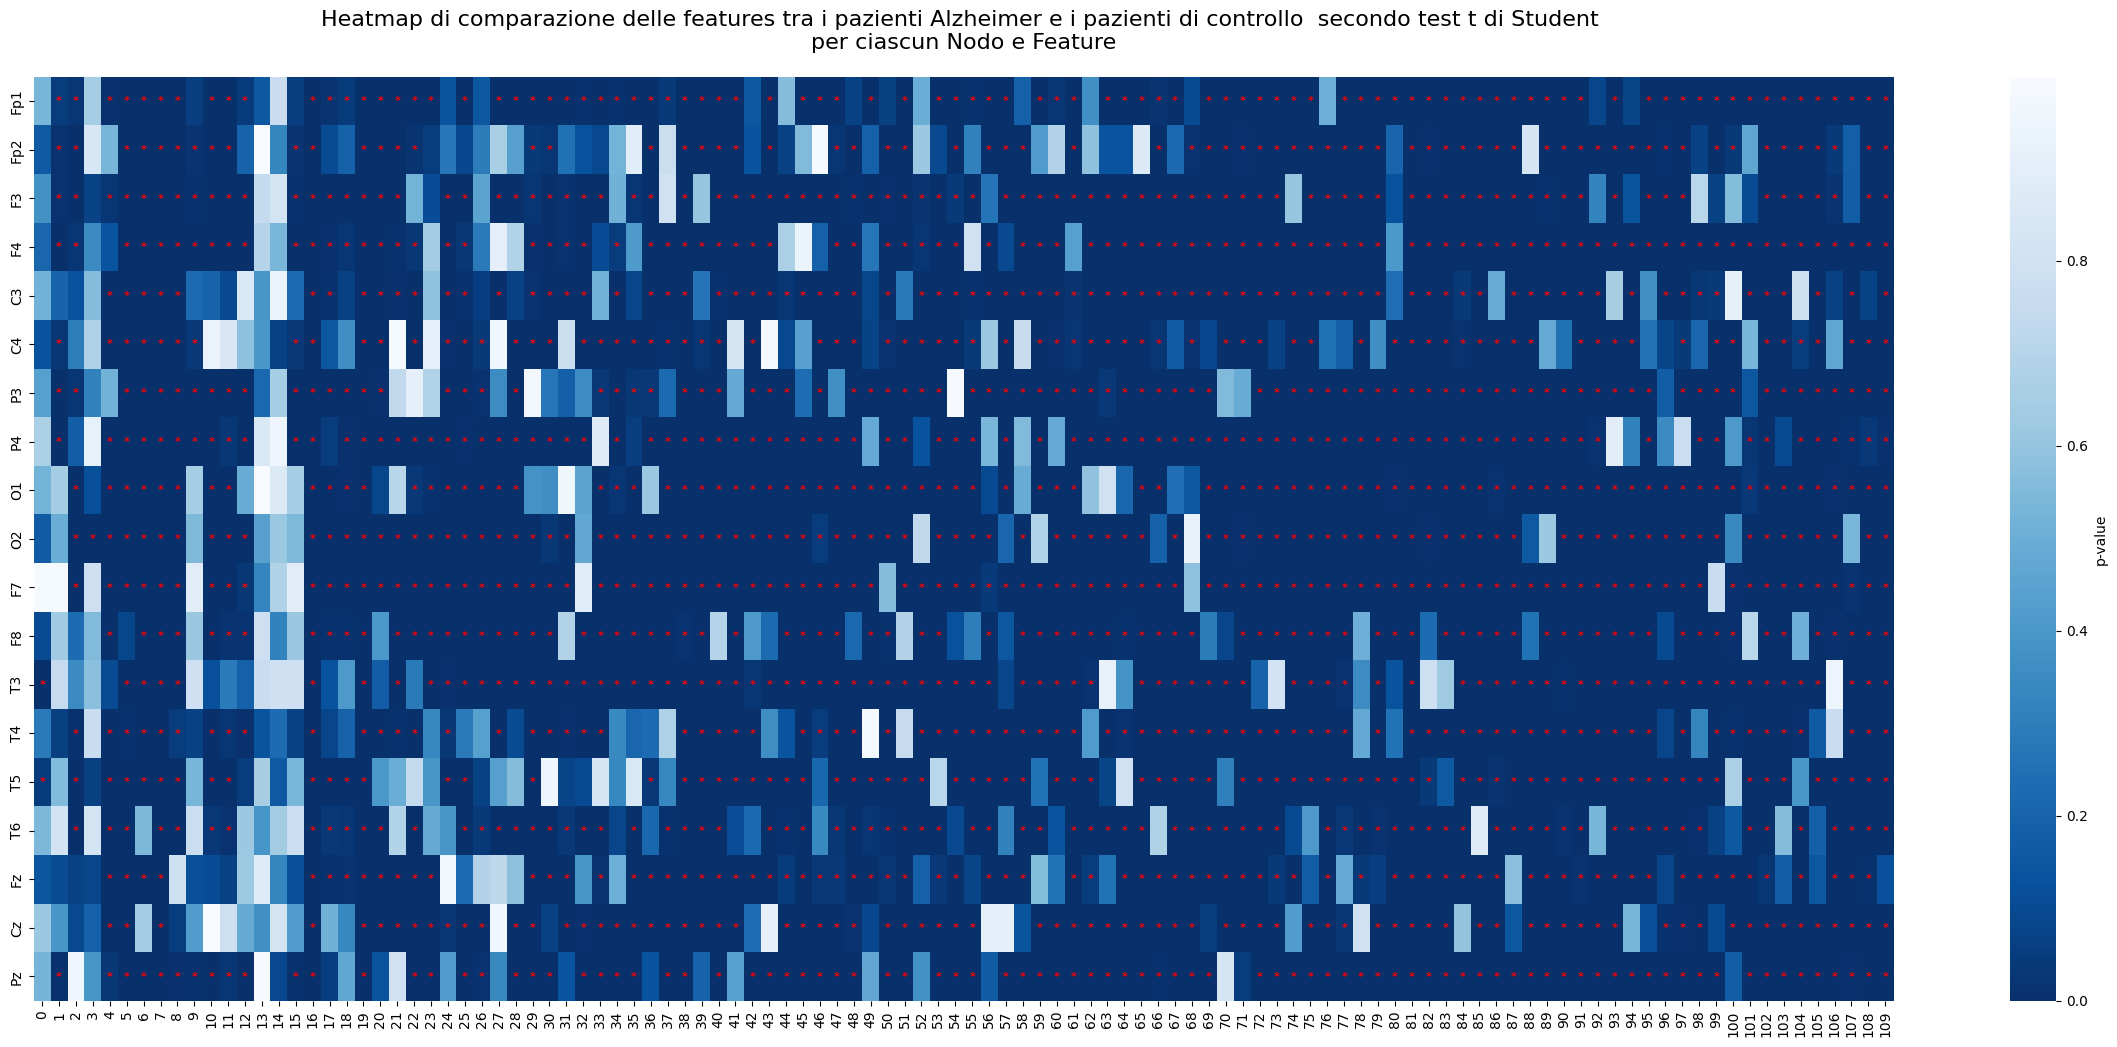

Numero di feature significative: 1617
Feature significative (Nodo, Feature, p-value):


In [ ]:
# comparazione  delle distribuzioni delle  node features dei pazienti Alzheimer e i pazienti di controllo secondo test t di student

def compare_features(alz_features_array, nor_features_array):
    num_epochs, num_nodes, num_features = alz_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            alz_feature = alz_features_array[:, node, feature]
            nor_feature = nor_features_array[:, node, feature]

            # Test t di Student
            t_stat, p_val = ttest_ind(alz_feature, nor_feature)
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

# Definire una soglia per la significatività
significance_threshold = 0.05

# calcolo i p-values e ottengo le feature significative
p_values, significant_features = compare_features(alz_features_array, nor_features_array)

# Creo un array di annotazioni condizionali
annotations = np.full(p_values.shape, '', dtype=object)
annotations[p_values < significance_threshold] = '*'

# Creo la figura con dimensioni specificate
plt.figure(figsize=(30, 12))

# Creo la heatmap con annotazioni condizionali
heatmap = sns.heatmap(p_values, annot=annotations, fmt='', cmap=sns.color_palette("Blues_r", as_cmap=True),
                      cbar_kws={'label': 'p-value'},
                      annot_kws={"size": 8, "weight": "bold", "color": "red"},  # Impostare la dimensione e lo stile del testo delle annotazioni
                      xticklabels=feature_names,
                      yticklabels=ch_names)

# Regolo la dimensione dei tick per migliorare la leggibilità
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungere titolo con spaziatura aggiuntiva sopra e sotto
plt.title('Heatmap di comparazione delle features tra i pazienti Alzheimer e i pazienti di controllo  secondo test t di Student \nper ciascun Nodo e Feature', fontsize=16, pad=20)

# Mostrare la figura
plt.show()

# Stampo le feature significative
print(f"Numero di feature significative: {len(significant_features)}")
print("Feature significative (Nodo, Feature, p-value):")
# for node, feature, p_val in significant_features:
#     print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")


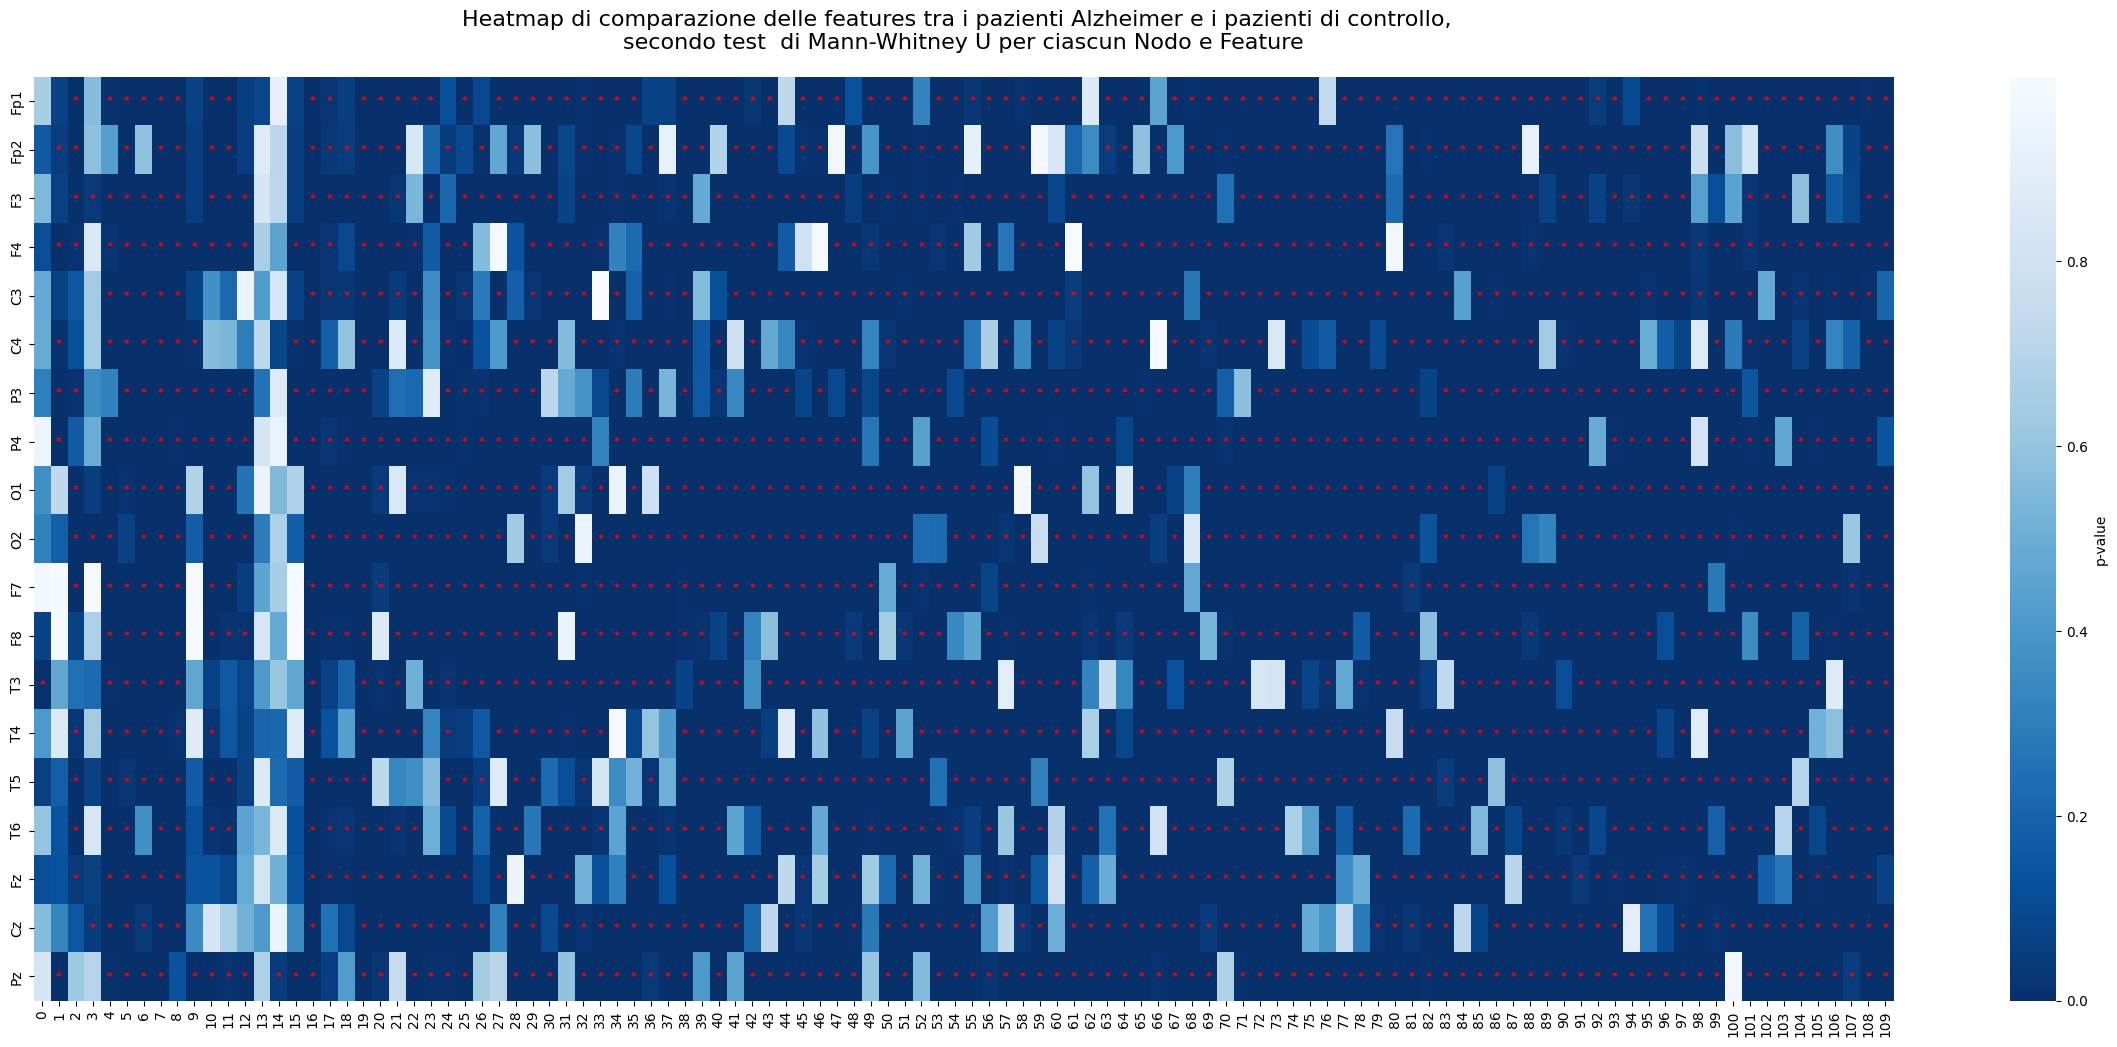

Numero di feature significative: 1634


In [ ]:
 # comparazione  delle distribuzioni delle  node features dei pazienti Alzheimer e i pazienti di controllo secondo test t di mannwhitneyu


def compare_features(alz_features_array, nor_features_array):
    num_epochs, num_nodes, num_features = alz_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            alz_feature = alz_features_array[:, node, feature]
            nor_feature = nor_features_array[:, node, feature]

            # Test di Mann-Whitney U
            u_stat, p_val = mannwhitneyu(alz_feature, nor_feature, alternative='two-sided')
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

# Definire una soglia per la significatività
significance_threshold = 0.05

# Calcolo i p-values e ottenere le feature significative
p_values, significant_features = compare_features(alz_features_array, nor_features_array)

# Creo un array di annotazioni condizionali
annotations = np.full(p_values.shape, '', dtype=object)
annotations[p_values < significance_threshold] = '*'

# Creo la figura con dimensioni specificate
plt.figure(figsize=(30, 12))

# Creo la heatmap con annotazioni condizionali
heatmap = sns.heatmap(p_values, annot=annotations, fmt='', cmap=sns.color_palette("Blues_r", as_cmap=True),
                      cbar_kws={'label': 'p-value'},
                      annot_kws={"size": 8, "weight": "bold", "color": "red"},  # Imposto la dimensione e lo stile del testo delle annotazioni
                      xticklabels=feature_names,
                      yticklabels=ch_names)

# Regolo la dimensione dei tick per migliorare la leggibilità
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungere titolo con spaziatura aggiuntiva sopra e sotto
plt.title('Heatmap di comparazione delle features tra i pazienti Alzheimer e i pazienti di controllo,  \nsecondo test  di Mann-Whitney U per ciascun Nodo e Feature', fontsize=16, pad=20)

# Mostro la figura
plt.show()

# Stampo le feature significative
print(f"Numero di feature significative: {len(significant_features)}")
#print("Feature significative (Nodo, Feature, p-value):")
#for node, feature, p_val in significant_features:
#    print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")


##Comparazione node feature pazienti FTD - pazienti Controllo
La prima e la seconda figura evidenziano un gran numero di features differenti in modo statisticamente significativo tra le node features dei pazienti FTD e quelle dei pazienti di controllo secondo il test t di Student.

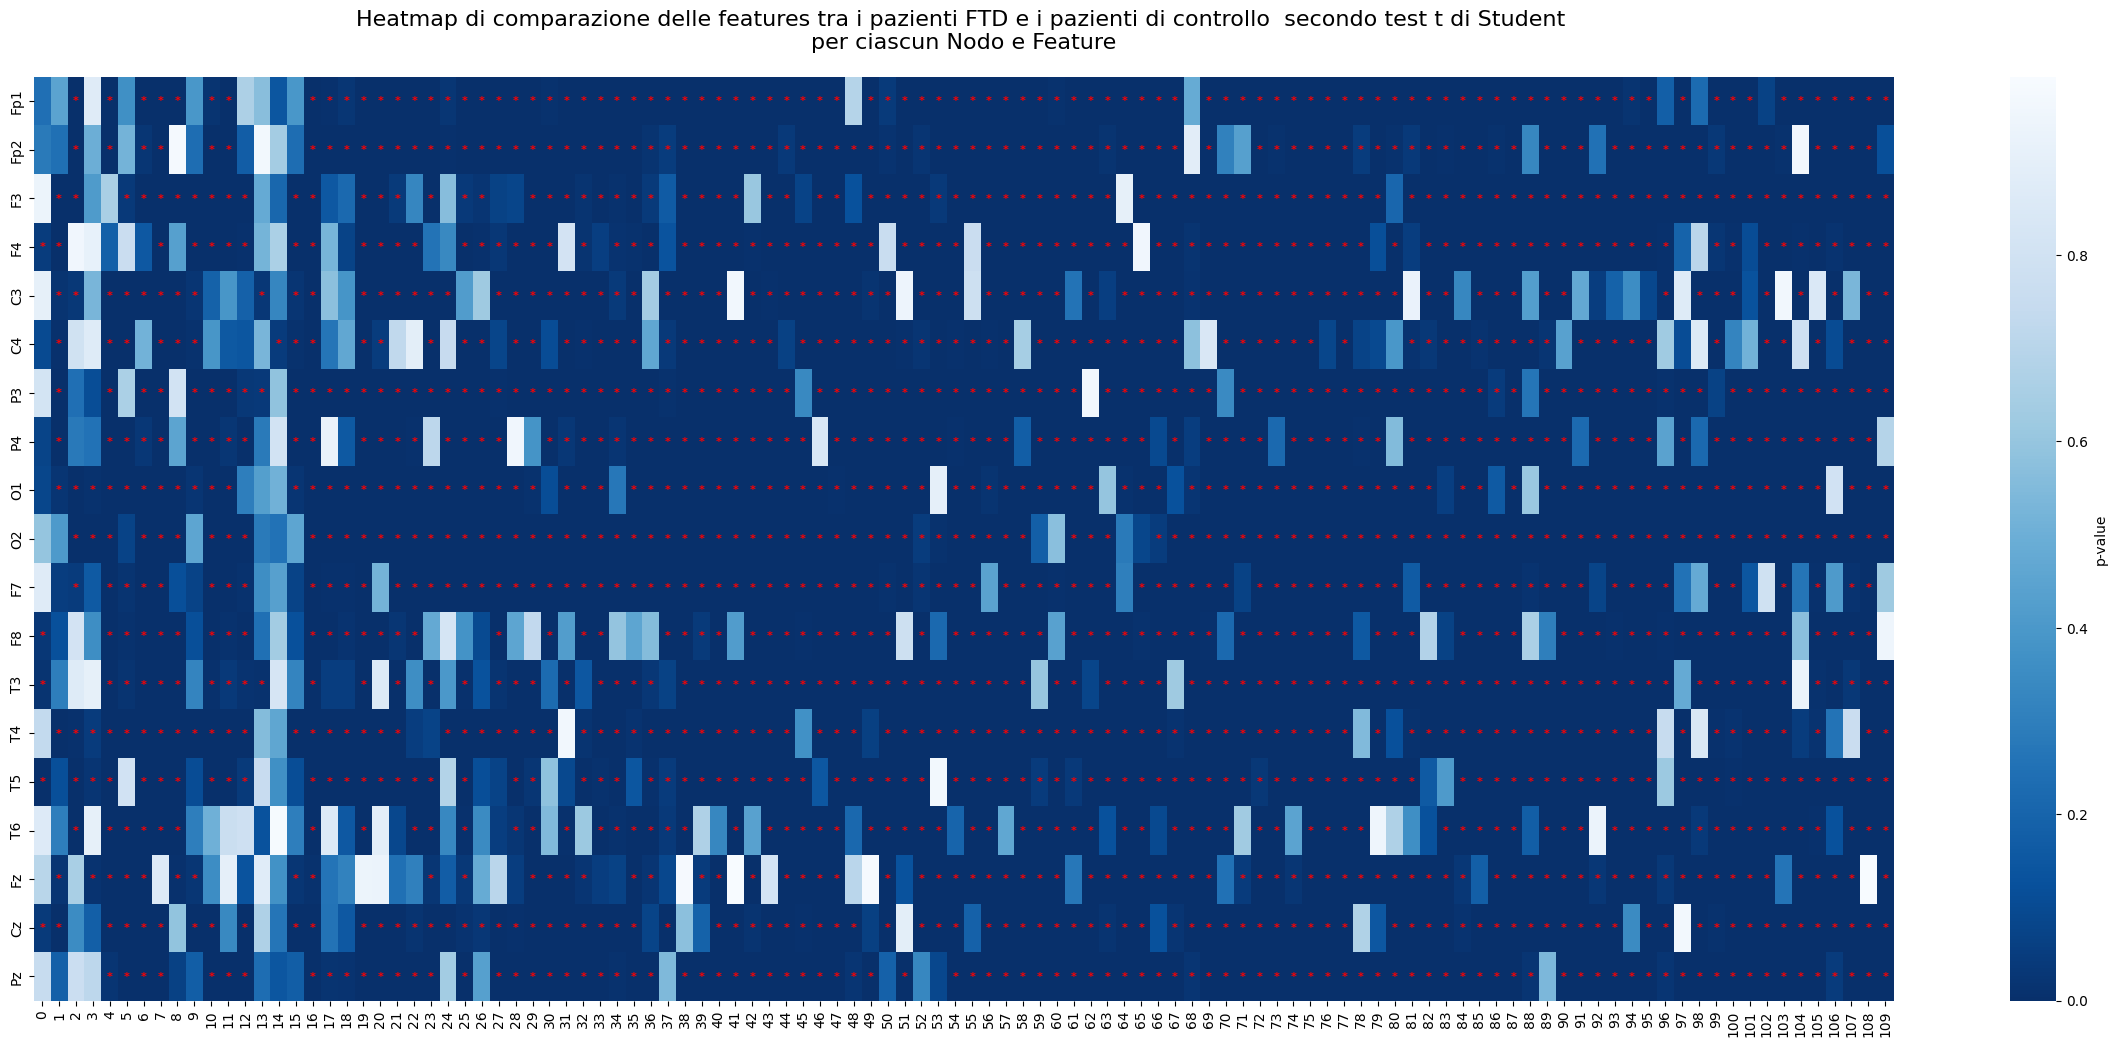

Numero di feature significative: 1697
Feature significative (Nodo, Feature, p-value):


In [ ]:
#  comparazione  delle distribuzioni delle  node features dei pazienti FTD e i pazienti di controllo secondo il test t di student

def compare_features(ftd_features_array, nor_features_array):
    num_epochs, num_nodes, num_features = ftd_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            ftd_feature = ftd_features_array[:, node, feature]
            nor_feature = nor_features_array[:, node, feature]

            # Test t di Student
            t_stat, p_val = ttest_ind(ftd_feature, nor_feature)
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

# Definire una soglia per la significatività
significance_threshold = 0.05

# calcolo i p-values e ottengo le feature significative
p_values, significant_features = compare_features(ftd_features_array, nor_features_array)

# Creo un array di annotazioni condizionali
annotations = np.full(p_values.shape, '', dtype=object)
annotations[p_values < significance_threshold] = '*'

# Creo la figura con dimensioni specificate
plt.figure(figsize=(30, 12))

# Creo la heatmap con annotazioni condizionali
heatmap = sns.heatmap(p_values, annot=annotations, fmt='', cmap=sns.color_palette("Blues_r", as_cmap=True),
                      cbar_kws={'label': 'p-value'},
                      annot_kws={"size": 8, "weight": "bold", "color": "red"},  # Impostare la dimensione e lo stile del testo delle annotazioni
                      xticklabels=feature_names,
                      yticklabels=ch_names)

# Regolo la dimensione dei tick per migliorare la leggibilità
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungere titolo con spaziatura aggiuntiva sopra e sotto
plt.title('Heatmap di comparazione delle features tra i pazienti FTD e i pazienti di controllo  secondo test t di Student \nper ciascun Nodo e Feature', fontsize=16, pad=20)

# Mostrare la figura
plt.show()

# Stampo le feature significative
print(f"Numero di feature significative: {len(significant_features)}")
print("Feature significative (Nodo, Feature, p-value):")
# for node, feature, p_val in significant_features:
#     print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")

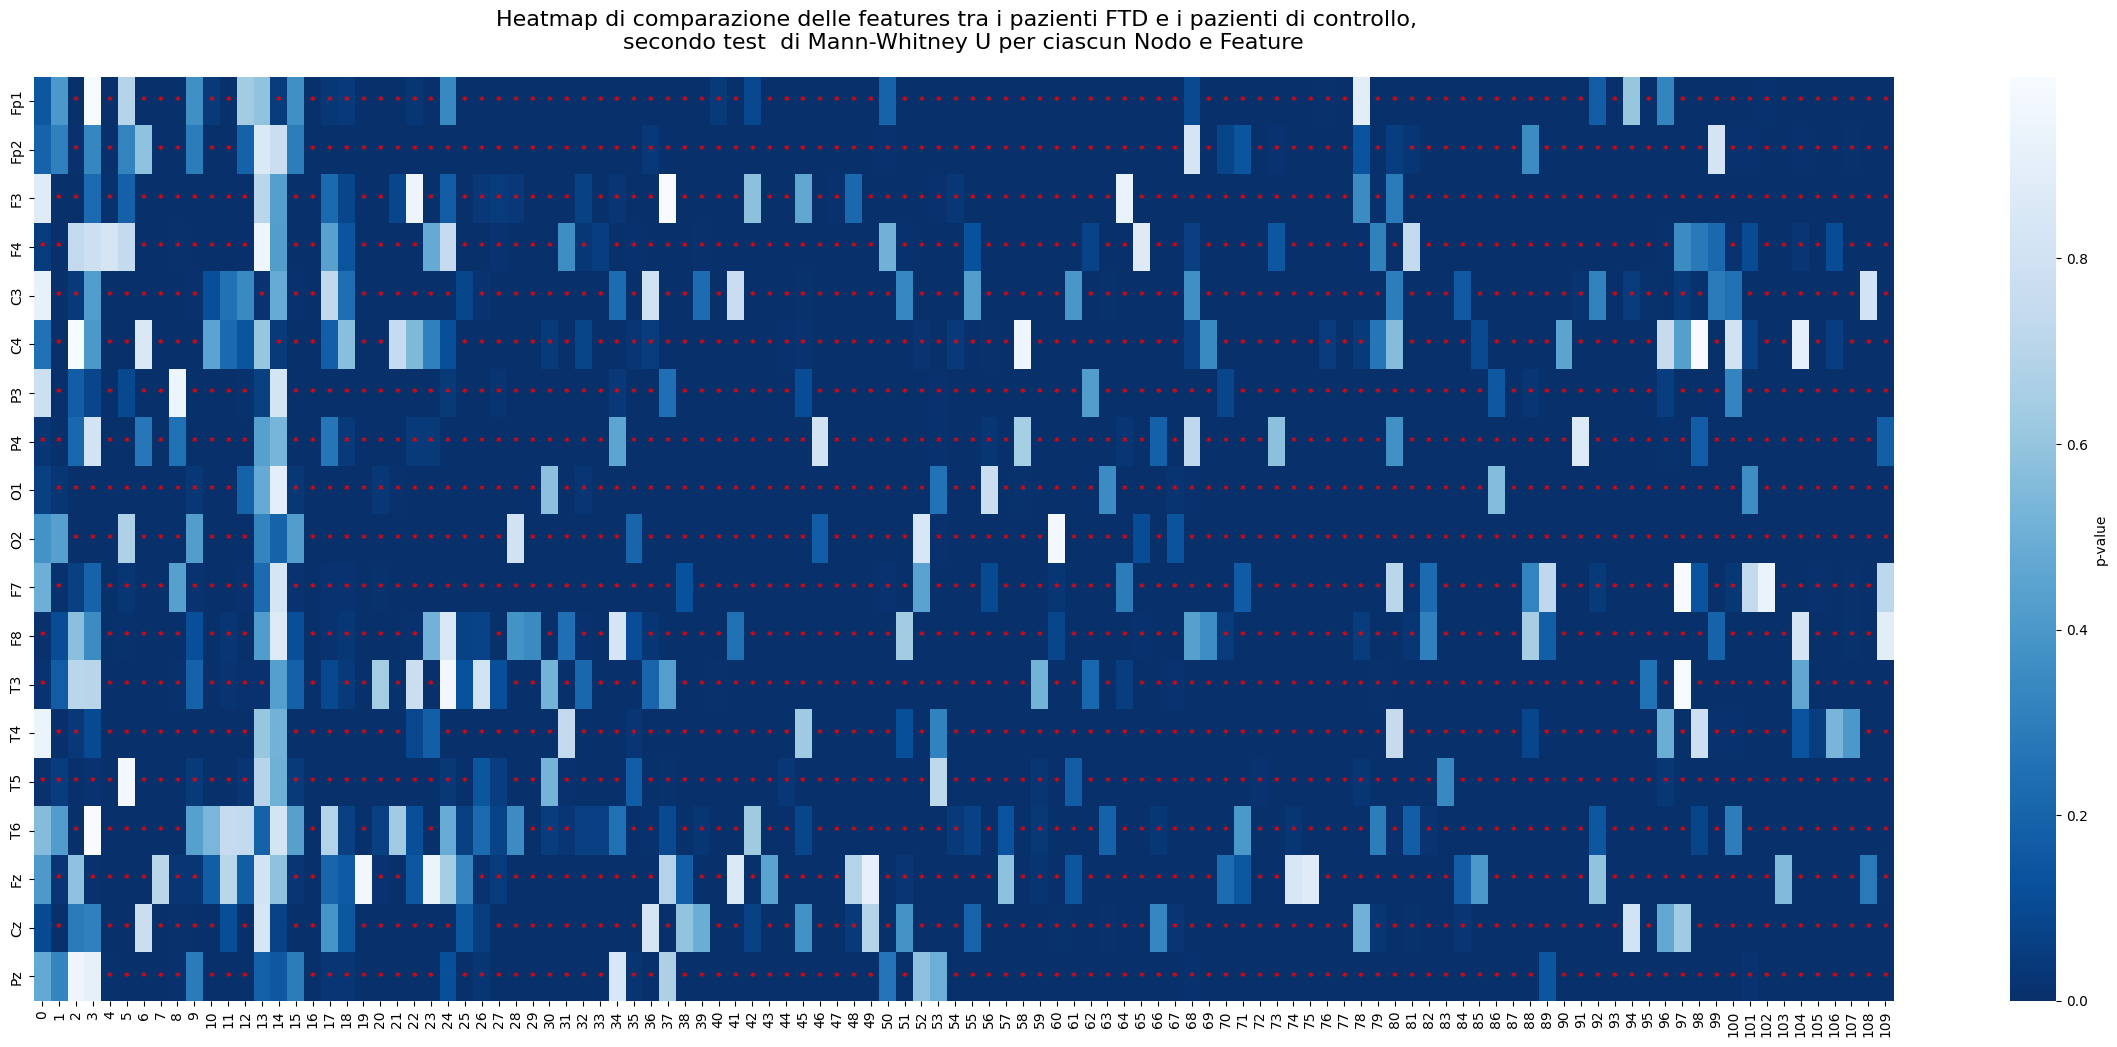

Numero di feature significative: 1703


In [ ]:
# comparazione  delle distribuzioni delle  node features dei pazienti FTD e i pazienti di controllo secondo il test Mann-Whitney U


def compare_features(ftd_features_array, nor_features_array):
    num_epochs, num_nodes, num_features = ftd_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            ftd_feature = ftd_features_array[:, node, feature]
            nor_feature = nor_features_array[:, node, feature]

            # Test di Mann-Whitney U
            u_stat, p_val = mannwhitneyu(ftd_feature, nor_feature, alternative='two-sided')
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

# Definire una soglia per la significatività
significance_threshold = 0.05

# Calcolo i p-values e ottenere le feature significative
p_values, significant_features = compare_features(ftd_features_array, nor_features_array)

# Creo un array di annotazioni condizionali
annotations = np.full(p_values.shape, '', dtype=object)
annotations[p_values < significance_threshold] = '*'

# Creo la figura con dimensioni specificate
plt.figure(figsize=(30, 12))

# Creo la heatmap con annotazioni condizionali
heatmap = sns.heatmap(p_values, annot=annotations, fmt='', cmap=sns.color_palette("Blues_r", as_cmap=True),
                      cbar_kws={'label': 'p-value'},
                      annot_kws={"size": 8, "weight": "bold", "color": "red"},  # Imposto la dimensione e lo stile del testo delle annotazioni
                      xticklabels=feature_names,
                      yticklabels=ch_names)

# Regolo la dimensione dei tick per migliorare la leggibilità
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungere titolo con spaziatura aggiuntiva sopra e sotto
plt.title('Heatmap di comparazione delle features tra i pazienti FTD e i pazienti di controllo,  \nsecondo test  di Mann-Whitney U per ciascun Nodo e Feature', fontsize=16, pad=20)

# Mostro la figura
plt.show()

# Stampo le feature significative
print(f"Numero di feature significative: {len(significant_features)}")
#print("Feature significative (Nodo, Feature, p-value):")
#for node, feature, p_val in significant_features:
#    print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")

##Comparazione node feature pazienti Alzheimer - pazienti FTD
	Si evince, osservando questi dati, che le distribuzioni delle node features dei pazienti FDT e i pazienti Alzheimer si differenziano in maniera minore fra loro rispetto a quanto si differenziano ciascuna di loro con quelle  del gruppo di controllo.
	Si procede quindi ad eseguire una visualizzazione la diversa distribuzione tra i 3 gruppi, Alzheimer, controllo e FTD attraverso il test di Kruskal-Wallis che è una generalizzazione del test di Mann-Whitney U per più di due gruppi

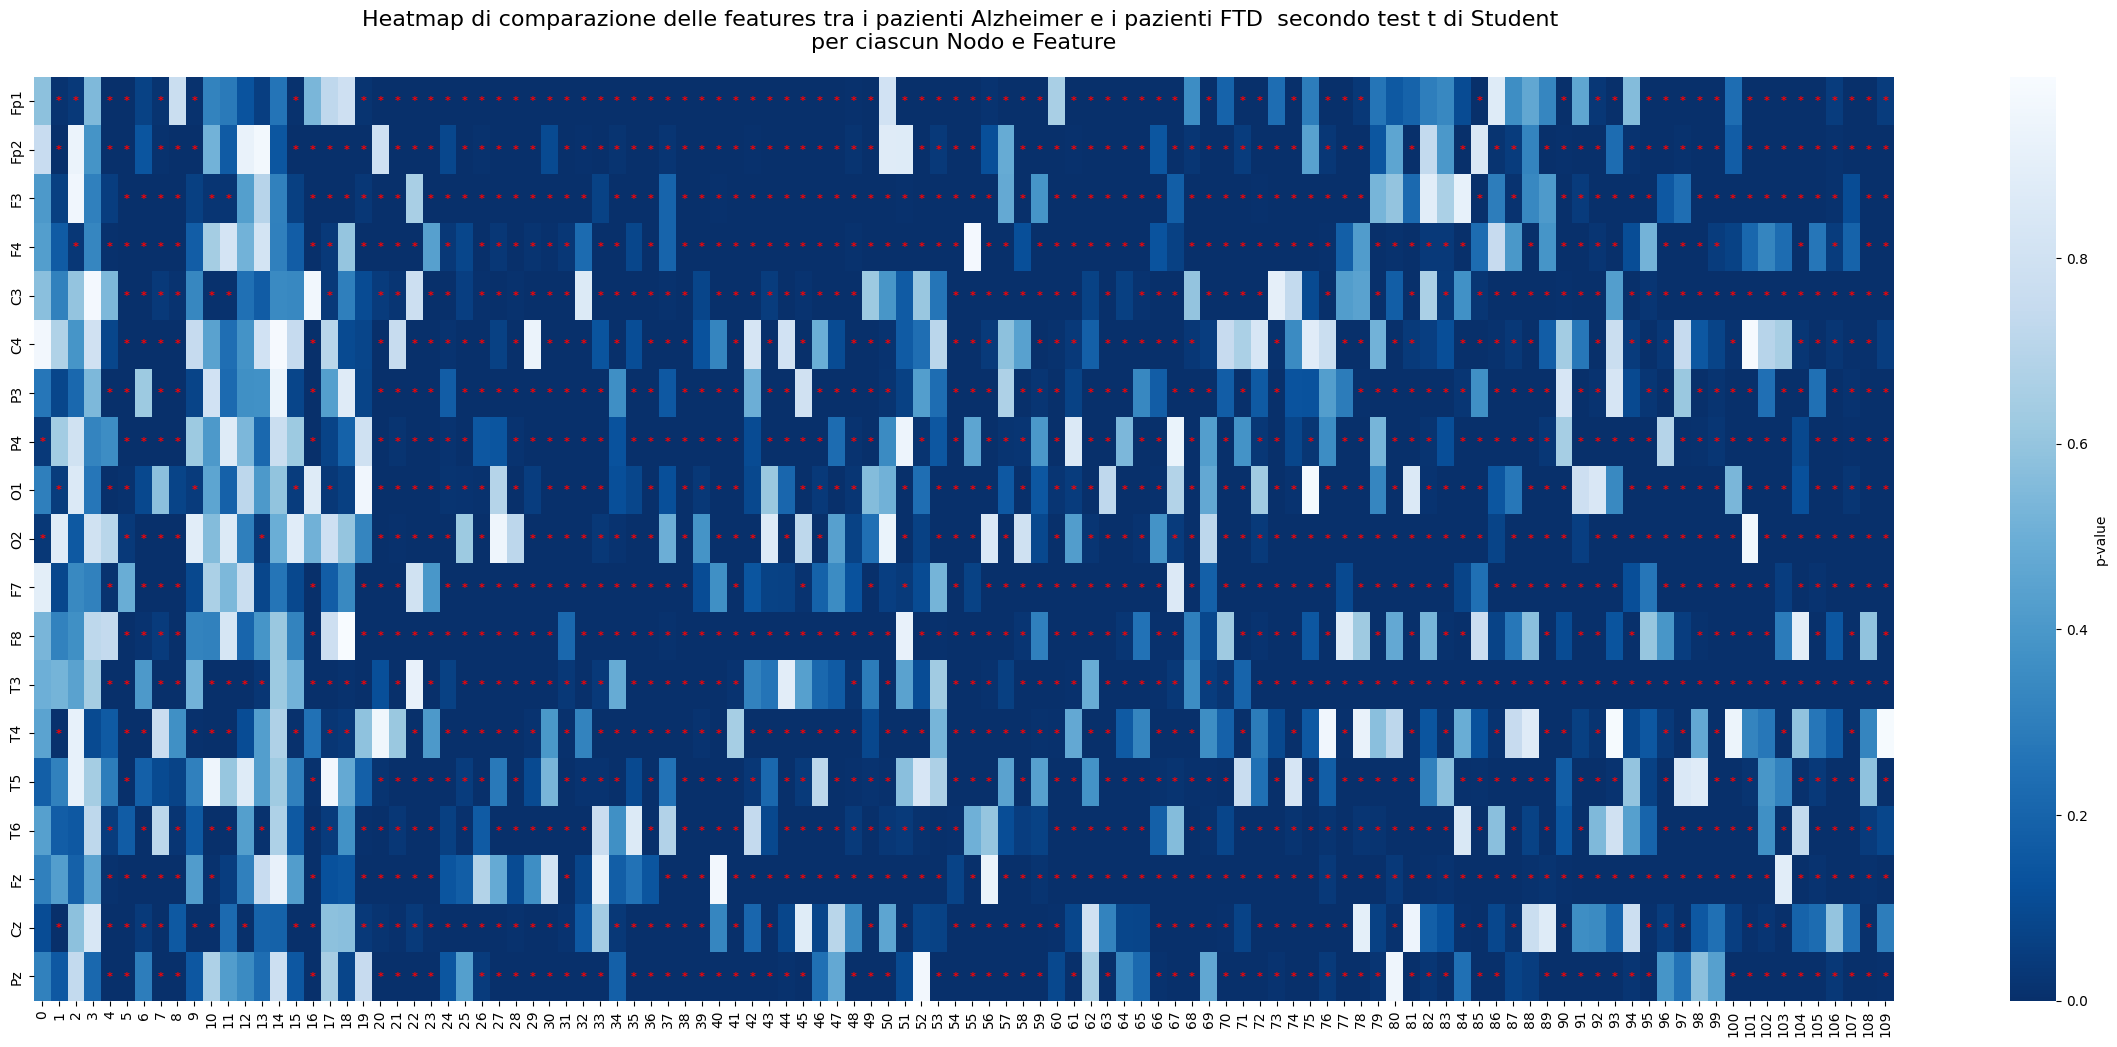

Numero di feature significative: 1389
Feature significative (Nodo, Feature, p-value):


In [ ]:
#comparazione  delle distribuzioni delle  node features dei pazienti FTD e i pazienti di Alzheimer secondo il test t di Student
def compare_features(alz_features_array, ftd_features_array):
    num_epochs, num_nodes, num_features = alz_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            alz_feature = alz_features_array[:, node, feature]
            ftd_feature = ftd_features_array[:, node, feature]

            # Test t di Student
            t_stat, p_val = ttest_ind(alz_feature, ftd_feature)
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

# Definire una soglia per la significatività
significance_threshold = 0.05

# calcolo i p-values e ottengo le feature significative
p_values, significant_features = compare_features(alz_features_array, ftd_features_array)

# Creo un array di annotazioni condizionali
annotations = np.full(p_values.shape, '', dtype=object)
annotations[p_values < significance_threshold] = '*'

# Creo la figura con dimensioni specificate
plt.figure(figsize=(30, 12))

# Creo la heatmap con annotazioni condizionali
heatmap = sns.heatmap(p_values, annot=annotations, fmt='', cmap=sns.color_palette("Blues_r", as_cmap=True),
                      cbar_kws={'label': 'p-value'},
                      annot_kws={"size": 8, "weight": "bold", "color": "red"},  # Impostare la dimensione e lo stile del testo delle annotazioni
                      xticklabels=feature_names,
                      yticklabels=ch_names)

# Regolo la dimensione dei tick per migliorare la leggibilità
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungere titolo con spaziatura aggiuntiva sopra e sotto
plt.title('Heatmap di comparazione delle features tra i pazienti Alzheimer e i pazienti FTD  secondo test t di Student \nper ciascun Nodo e Feature', fontsize=16, pad=20)

# Mostrare la figura
plt.show()

# Stampo le feature significative
print(f"Numero di feature significative: {len(significant_features)}")
print("Feature significative (Nodo, Feature, p-value):")
# for node, feature, p_val in significant_features:
#     print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")


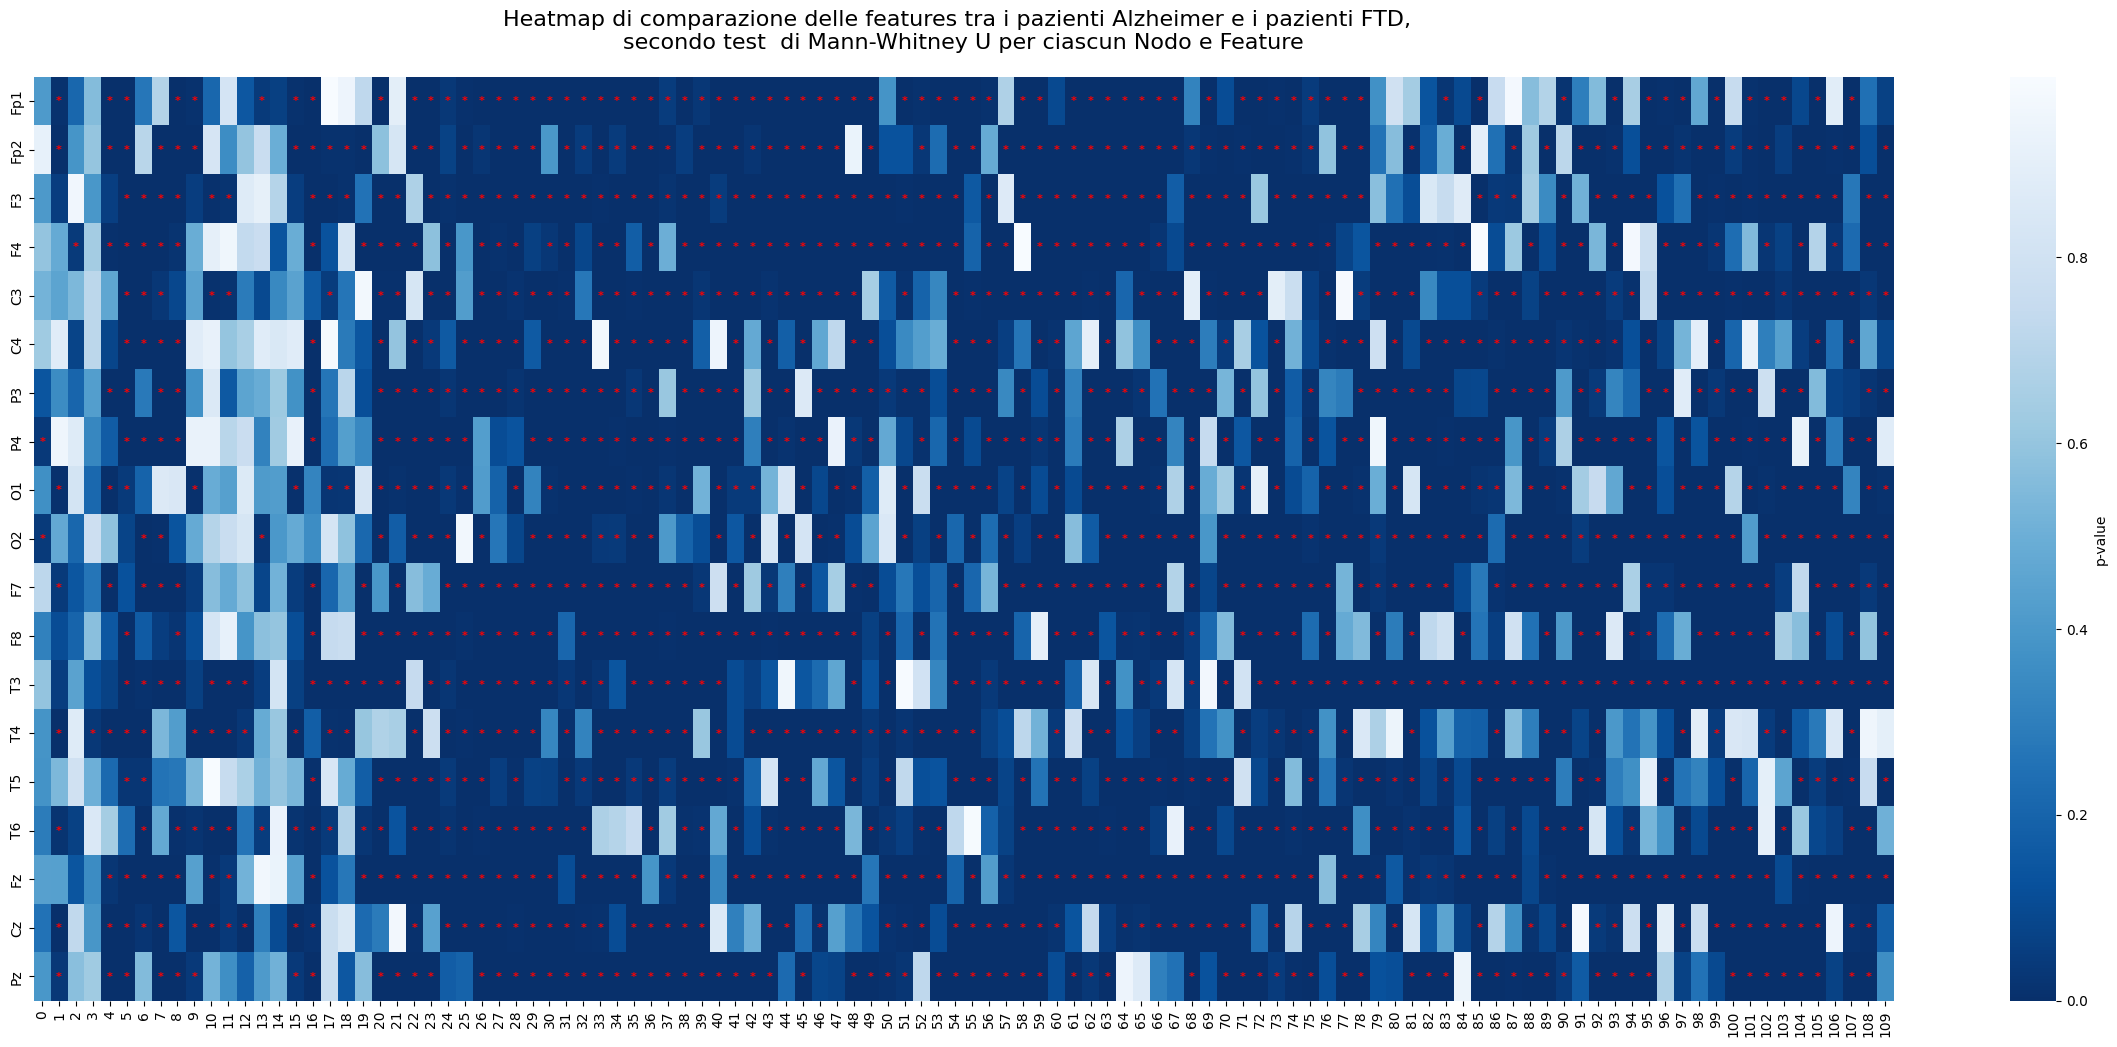

Numero di feature significative: 1380


In [ ]:
#comparazione  delle distribuzioni delle  node features dei pazienti FTD e i pazienti di controllo secondo il test di Mann Whitney U

def compare_features(alz_features_array, ftd_features_array):
    num_epochs, num_nodes, num_features = alz_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            alz_feature = alz_features_array[:, node, feature]
            ftd_feature = ftd_features_array[:, node, feature]

            # Test di Mann-Whitney U
            u_stat, p_val = mannwhitneyu(alz_feature, ftd_feature, alternative='two-sided')
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

# Definire una soglia per la significatività
significance_threshold = 0.05

# Calcolo i p-values e ottenere le feature significative
p_values, significant_features = compare_features(alz_features_array, ftd_features_array)

# Creo un array di annotazioni condizionali
annotations = np.full(p_values.shape, '', dtype=object)
annotations[p_values < significance_threshold] = '*'

# Creo la figura con dimensioni specificate
plt.figure(figsize=(30, 12))

# Creo la heatmap con annotazioni condizionali
heatmap = sns.heatmap(p_values, annot=annotations, fmt='', cmap=sns.color_palette("Blues_r", as_cmap=True),
                      cbar_kws={'label': 'p-value'},
                      annot_kws={"size": 8, "weight": "bold", "color": "red"},  # Imposto la dimensione e lo stile del testo delle annotazioni
                      xticklabels=feature_names,
                      yticklabels=ch_names)

# Regolo la dimensione dei tick per migliorare la leggibilità
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungere titolo con spaziatura aggiuntiva sopra e sotto
plt.title('Heatmap di comparazione delle features tra i pazienti Alzheimer e i pazienti FTD,  \nsecondo test  di Mann-Whitney U per ciascun Nodo e Feature', fontsize=16, pad=20)

# Mostro la figura
plt.show()

# Stampo le feature significative
print(f"Numero di feature significative: {len(significant_features)}")
#print("Feature significative (Nodo, Feature, p-value):")
#for node, feature, p_val in significant_features:
#    print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")

##Comparazione delle distibuzioni secondo il test di  Kruskal-Wallis
Si evince che 1589 features su 3840 superano la soglia impostata (0.05) per cui si conclude che le node features in oggetto sono una buona base per istruire la rete neurale.

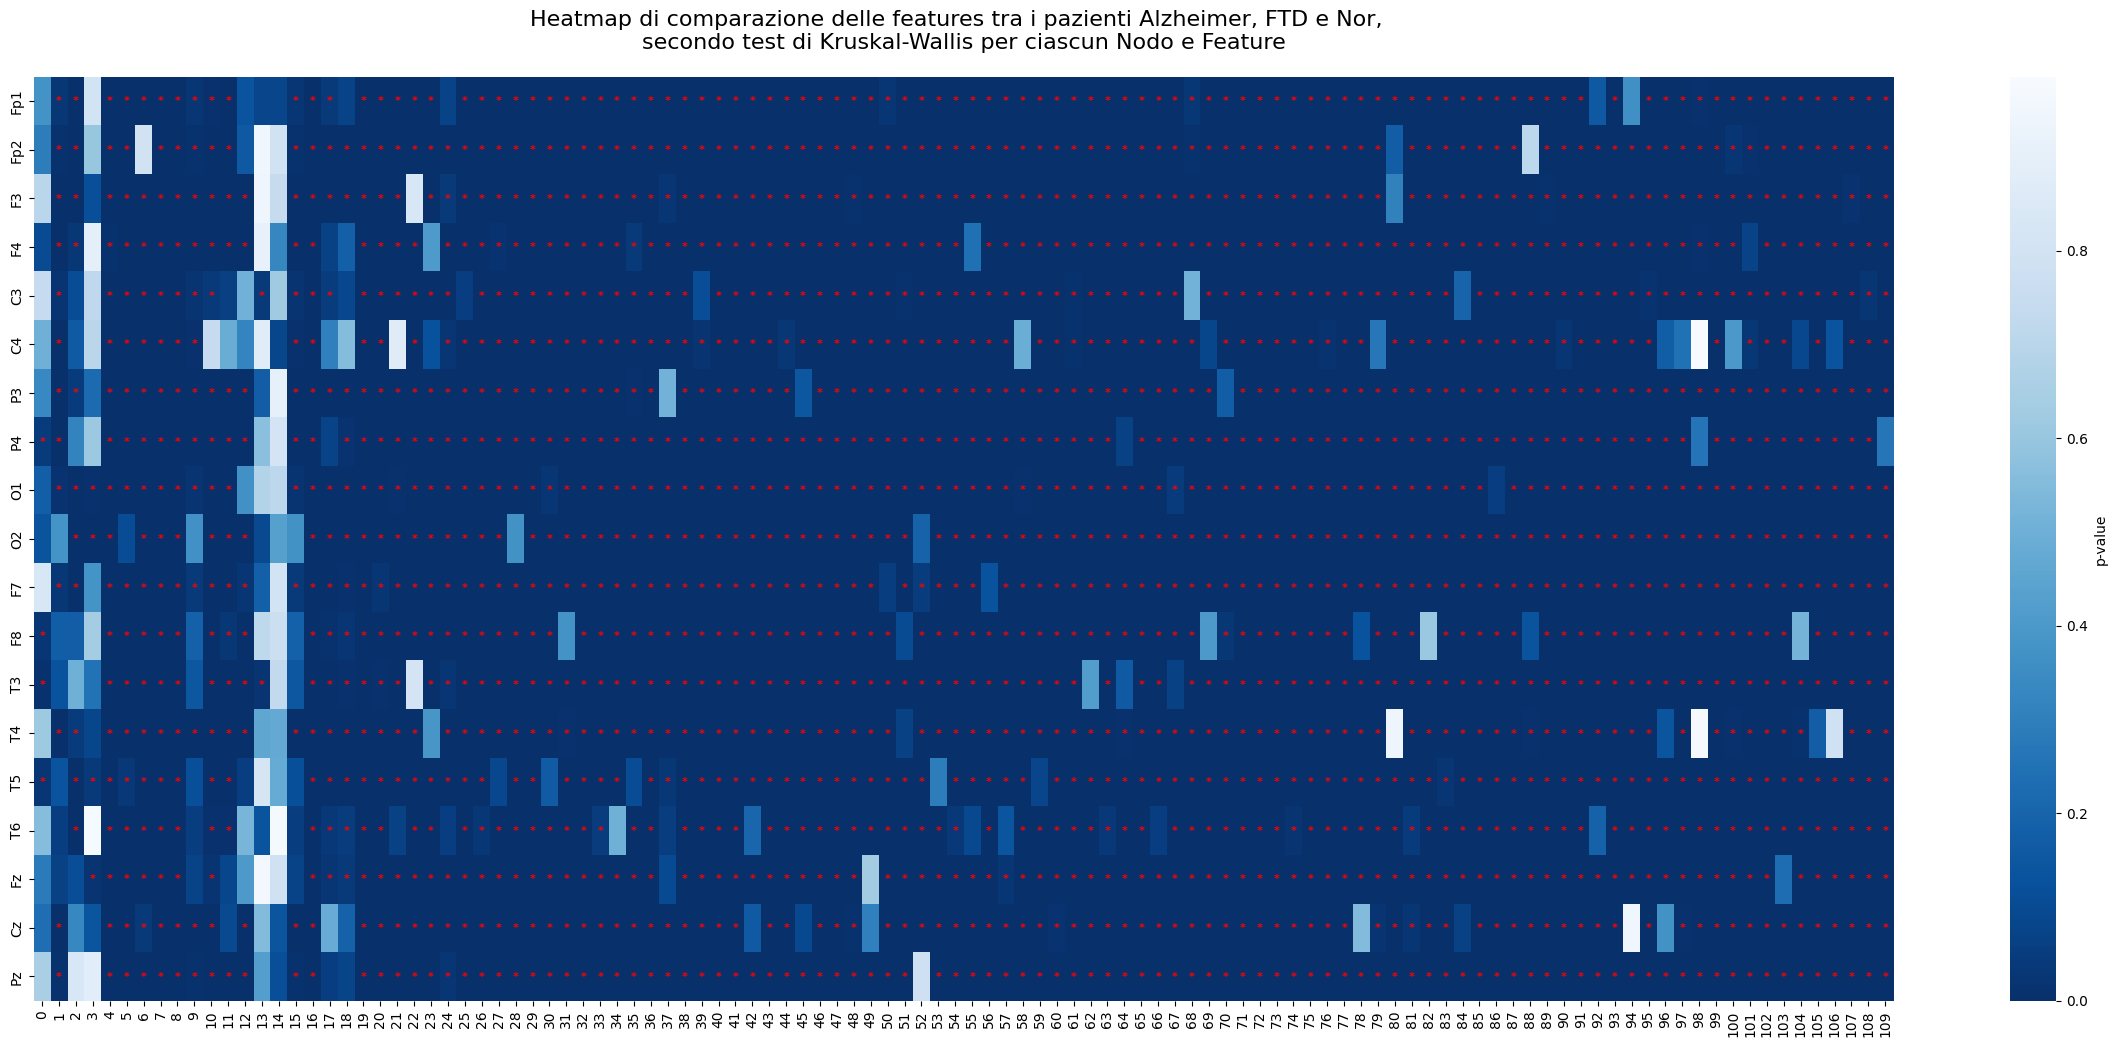

Numero di feature significative: 1893


In [ ]:
##comparazione  delle distribuzioni delle  node features tra i pazienti FTD, i pazienti Alzheimer e
# pazienti  di controllo secondo il test di Kruskal-Wallis
def compare_features(alz_features_array, ftd_features_array, nor_features_array):
    num_epochs, num_nodes, num_features = alz_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            alz_feature = alz_features_array[:, node, feature]
            ftd_feature = ftd_features_array[:, node, feature]
            nor_feature = nor_features_array[:, node, feature]

            # Test di Kruskal-Wallis
            h_stat, p_val = kruskal(alz_feature, ftd_feature, nor_feature)
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

# Definire una soglia per la significatività
significance_threshold = 0.05

# Calcolo i p-values e ottenere le feature significative
p_values, significant_features = compare_features(alz_features_array, ftd_features_array, nor_features_array)

# Creo un array di annotazioni condizionali
annotations = np.full(p_values.shape, '', dtype=object)
annotations[p_values < significance_threshold] = '*'

# Creo la figura con dimensioni specificate
plt.figure(figsize=(30, 12))

# Creo la heatmap con annotazioni condizionali
heatmap = sns.heatmap(p_values, annot=annotations, fmt='', cmap=sns.color_palette("Blues_r", as_cmap=True),
                      cbar_kws={'label': 'p-value'},
                      annot_kws={"size": 8, "weight": "bold", "color": "red"},  # Imposto la dimensione e lo stile del testo delle annotazioni
                      xticklabels=feature_names,
                      yticklabels=ch_names)

# Regolo la dimensione dei tick per migliorare la leggibilità
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Aggiungere titolo con spaziatura aggiuntiva sopra e sotto
plt.title('Heatmap di comparazione delle features tra i pazienti Alzheimer, FTD e Nor,  \nsecondo test di Kruskal-Wallis per ciascun Nodo e Feature', fontsize=16, pad=20)

# Mostro la figura
plt.show()

# Stampo le feature significative
print(f"Numero di feature significative: {len(significant_features)}")
# for node, feature, p_val in significant_features:
#     print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")


##Identificazione  features più significative: test con Random Forest

In [ ]:
def compare_features(alz_features_array, ftd_features_array, nor_features_array):
    num_epochs, num_nodes, num_features = alz_features_array.shape
    p_values = np.zeros((num_nodes, num_features))
    significant_features = []

    for node in range(num_nodes):
        for feature in range(num_features):
            alz_feature = alz_features_array[:, node, feature]
            ftd_feature = ftd_features_array[:, node, feature]
            nor_feature = nor_features_array[:, node, feature]

            # Test di Kruskal-Wallis
            h_stat, p_val = kruskal(alz_feature, ftd_feature, nor_feature)
            p_values[node, feature] = p_val

            # Aggiungere le feature significative alla lista
            if p_val < significance_threshold:
                significant_features.append((ch_names[node], feature_names[feature], p_val))

    return p_values, significant_features

def filter_significant_features(features, significant_nodes_features):
    num_epochs, num_nodes, num_features = features.shape
    filtered_features = []

    for epoch in range(num_epochs):
        filtered_epoch = []
        for node in range(num_nodes):
            filtered_node = []
            for feature in range(num_features):
                if (node, feature) in significant_nodes_features:
                    filtered_node.append(features[epoch, node, feature])
            if filtered_node:  # If there are significant features for this node
                filtered_epoch.extend(filtered_node)
        filtered_features.append(filtered_epoch)

    return np.array(filtered_features)

# Definire una soglia per la significatività
significance_threshold = 0.05

# Calcolo i p-values e ottenere le feature significative
p_values, significant_features = compare_features(alz_features_array, ftd_features_array, nor_features_array)

# Identificazione delle feature significative basate sulla soglia
significant_features_np = np.argwhere(p_values < significance_threshold)
significant_nodes_features = {(node, feature) for node, feature in significant_features_np}

# Filtraggio delle feature significative per ogni gruppo
filtered_alz_features = filter_significant_features(alz_features_array, significant_nodes_features)
filtered_ftd_features = filter_significant_features(ftd_features_array, significant_nodes_features)
filtered_nor_features = filter_significant_features(nor_features_array, significant_nodes_features)

# Output dei risultati
print(f"Shape delle feature filtrate per Alzheimer: {filtered_alz_features.shape}")
print(f"Shape delle feature filtrate per FTD: {filtered_ftd_features.shape}")
print(f"Shape delle feature filtrate per Normali: {filtered_nor_features.shape}")

print(f"Numero di feature significative: {len(significant_features)}")
# for node, feature, p_val in significant_features:
#     print(f"Nodo: {node}, Feature: {feature}, p-value: {p_val:.5f}")

Shape delle feature filtrate per Alzheimer: (1000, 1893)
Shape delle feature filtrate per FTD: (1000, 1893)
Shape delle feature filtrate per Normali: (1000, 1893)
Numero di feature significative: 1893


In [ ]:
# ESEGUO UN TEST DI CLASSIFICAZIONE UTILIZZANDO L'ALGORITMO RANDOM FORESTE
# I RISULTATI OTTENUTI SONO PRESSAPOCO SIMILI
# LA PRESTAZIONE DI CLASSIFICAZIONE E' SCARSA (Accuratezza 0.61)

# Creazione delle etichette
labels_alz = np.ones(filtered_alz_features.shape[0])
labels_ftd = np.full(filtered_ftd_features.shape[0], 2)
labels_nor = np.zeros(filtered_nor_features.shape[0])

# Unione delle feature e delle etichette per il dataset filtrato
X_filtered = np.vstack((filtered_alz_features, filtered_ftd_features, filtered_nor_features))
y_filtered = np.concatenate((labels_alz, labels_ftd, labels_nor))

# Creazione del modello Random Forest
model = RandomForestClassifier(random_state=42)

# Valutazione con cross-validation per le feature significative
scores_filtered = cross_val_score(model, X_filtered, y_filtered, cv=5)
print(f"Accuratezza media con feature significative: {np.mean(scores_filtered):.4f}")

# Reshape delle feature originali
alz_features_all = alz_features_array.reshape(alz_features_array.shape[0], -1)
ftd_features_all = ftd_features_array.reshape(ftd_features_array.shape[0], -1)
nor_features_all = nor_features_array.reshape(nor_features_array.shape[0], -1)

# Unione delle feature e delle etichette per il dataset completo
X_all = np.vstack((alz_features_all, ftd_features_all, nor_features_all))
y_all = np.concatenate((labels_alz, labels_ftd, labels_nor))

# Valutazione con cross-validation per tutte le feature
scores_all = cross_val_score(model, X_all, y_all, cv=5)
print(f"Accuratezza media con tutte le feature: {np.mean(scores_all):.4f}")


Accuratezza media con feature significative: 0.7850
Accuratezza media con tutte le feature: 0.7753


#ANALISI DI SIGNIFICATIVITA' STATISTICA  DELLE MATRICI DI ADIACENZA
Costruiti gli array delle matrici di adiacenza si è costruita una matrice che esprime  la differenza media della correlazione dei valori. Dopodiché, fissata una soglia arbitraria si sono individuati i canali che hanno differenze medie di correlazione superiori a data soglia. Per la costruzione delle node features si sono individuati i canali che presentano un numero maggiore di superamento di data soglia (Fp1, F3, C4, P4, F7). Dall'analisi si evince che, impostando la stessa soglia per tutti i tre tipi di matrice, la coerenza di fase è la caratteristica che maggiormente esprime maggiore differenza significativa statistica tra i canali. Tra i pazienti Alzheimer e i pazienti di controllo la significatività statistica è in generale molto alta. E' minore per tra i pazienti normali ed i pazienti FTD e scende ancora tra i pazienti FTD e i pazienti Alzheimer.

In [ ]:
# funzione che calcola le differenze statistiche significative sulle matrici di adiacenza

def calculate_and_plot_differences(adj_matr_group1, adj_matr_group2, ch_names, matrix_type, difference_threshold=0.08, significant_threshold=0.05):
    # Calcola la media delle matrici di correlazione per ogni gruppo
    mean_group1 = np.mean(adj_matr_group1, axis=0)
    mean_group2 = np.mean(adj_matr_group2, axis=0)

    # Calcola la differenza media
    mean_diff = mean_group1 - mean_group2

    # Inizializza una matrice per memorizzare i p-value
    p_values = np.zeros((len(ch_names), len(ch_names)))

    # Esegui il test t per ciascun elemento della matrice
    for i in range(len(ch_names)):
        for j in range(len(ch_names)):
            t_stat, p_val = ttest_ind(adj_matr_group1[:, i, j], adj_matr_group2[:, i, j])
            p_values[i, j] = p_val

    # Applica la correzione per confronti multipli (Bonferroni)
    p_adjusted = multipletests(p_values.flatten(), method='bonferroni')[1].reshape((len(ch_names), len(ch_names)))

    # Identifica le coppie di canali con differenze significative
    significant_diff = np.where(p_adjusted < significant_threshold, mean_diff, 0)

    # Filtra le differenze maggiori della soglia
    large_diff = np.where(np.abs(mean_diff) > difference_threshold, mean_diff, 0)

    # Funzione per visualizzare una heatmap
    def plot_heatmap(data, title, ch_names, vmin=None, vmax=None, cmap='coolwarm'):
        plt.figure(figsize=(15, 12))
        sns.heatmap(data, annot=True, cmap=cmap, vmin=vmin, vmax=vmax, xticklabels=ch_names, yticklabels=ch_names)
        plt.title(title)
        plt.xlabel("Canali")
        plt.ylabel("Canali")
        plt.show()

    # # Visualizza la differenza media delle correlazioni
    # plot_heatmap(mean_diff, f"Differenza Media Correlazione ({matrix_type})", ch_names)

     # Visualizza le differenze significative
    plot_heatmap(significant_diff, f"Differenze Significative di Correlazione ({matrix_type})", ch_names)

    # Visualizza le differenze maggiori della soglia
    plot_heatmap(large_diff, f"Differenze di Correlazione Maggiori di una Soglia - {matrix_type}", ch_names)

    # Stampa testuale delle coppie di canali con differenze significative oltre la soglia
    for i in range(len(ch_names)):
        for j in range(i + 1, len(ch_names)):  # j parte da i+1 per evitare duplicati
            if np.abs(large_diff[i, j]) > 0:
                print(f"Differenza significativa tra i canali {ch_names[i]} e {ch_names[j]}: {large_diff[i, j]:.4f}")




##Alzheimer vs Controllo

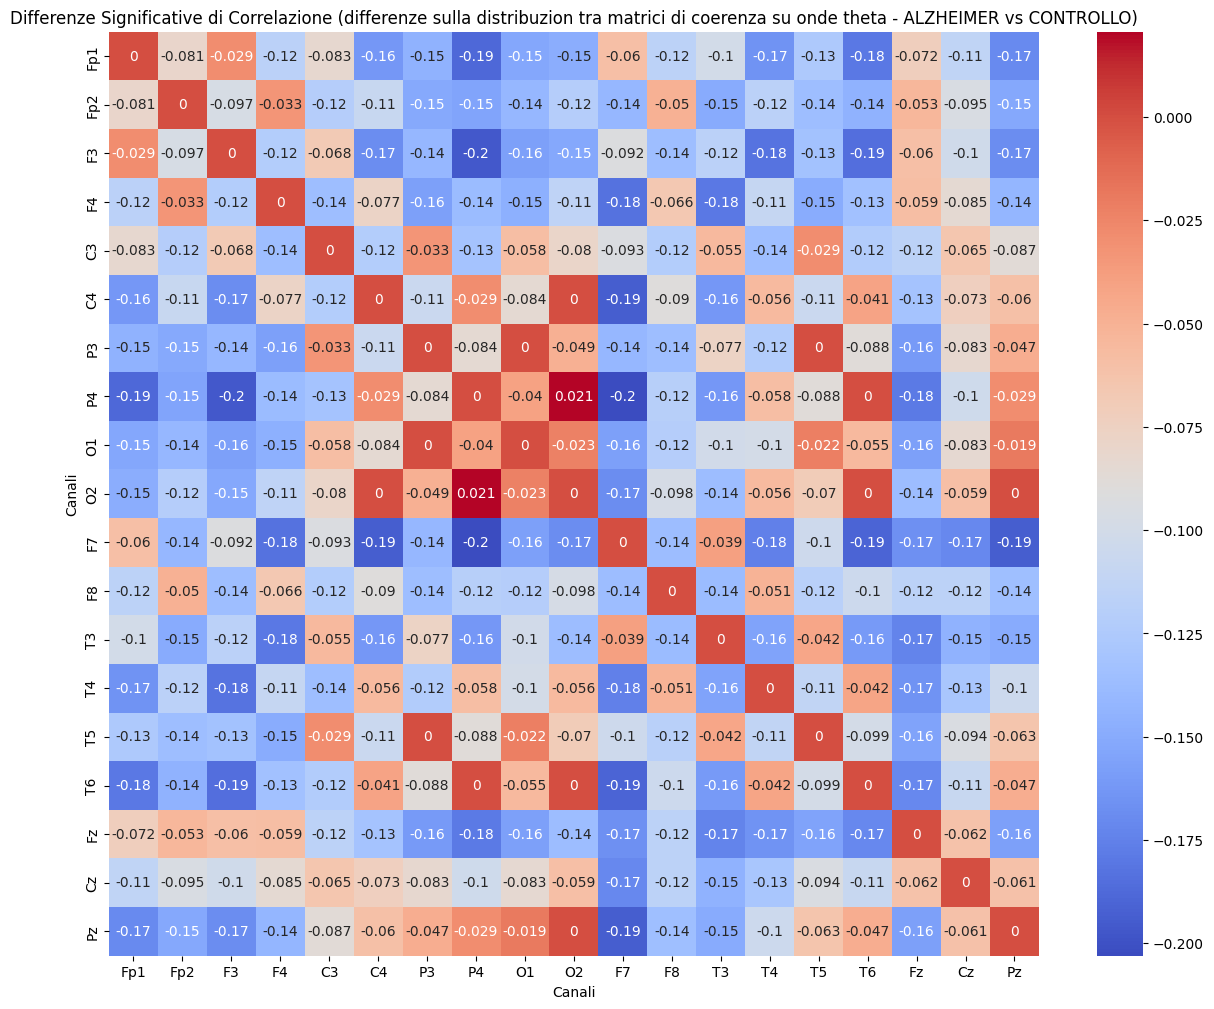

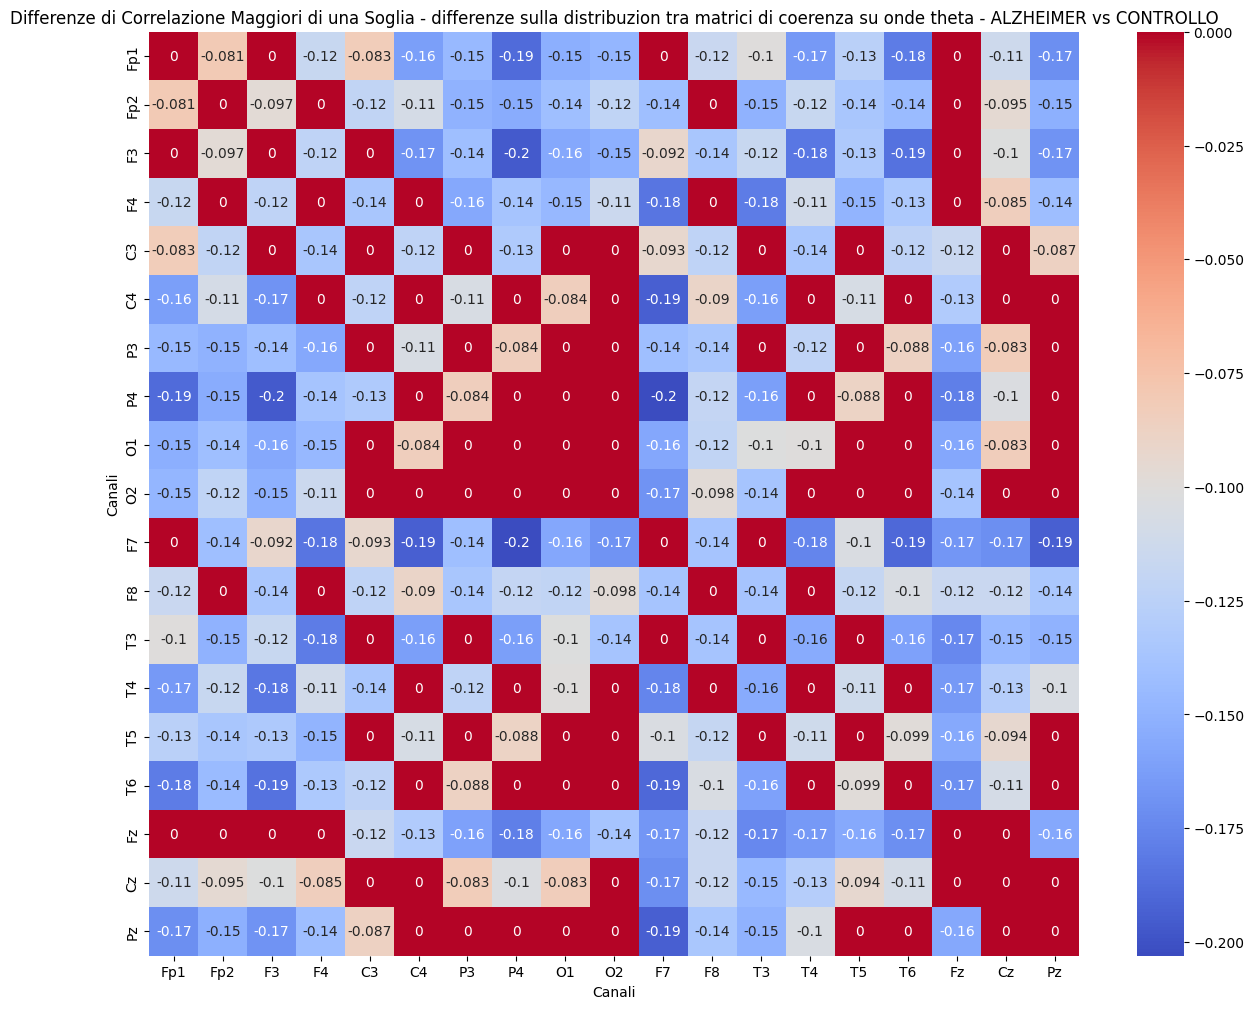

Differenza significativa tra i canali Fp1 e Fp2: -0.0807
Differenza significativa tra i canali Fp1 e F4: -0.1173
Differenza significativa tra i canali Fp1 e C3: -0.0830
Differenza significativa tra i canali Fp1 e C4: -0.1620
Differenza significativa tra i canali Fp1 e P3: -0.1453
Differenza significativa tra i canali Fp1 e P4: -0.1882
Differenza significativa tra i canali Fp1 e O1: -0.1529
Differenza significativa tra i canali Fp1 e O2: -0.1481
Differenza significativa tra i canali Fp1 e F8: -0.1160
Differenza significativa tra i canali Fp1 e T3: -0.1001
Differenza significativa tra i canali Fp1 e T4: -0.1654
Differenza significativa tra i canali Fp1 e T5: -0.1259
Differenza significativa tra i canali Fp1 e T6: -0.1800
Differenza significativa tra i canali Fp1 e Cz: -0.1131
Differenza significativa tra i canali Fp1 e Pz: -0.1705
Differenza significativa tra i canali Fp2 e F3: -0.0971
Differenza significativa tra i canali Fp2 e C3: -0.1209
Differenza significativa tra i canali Fp2 e C4:

In [ ]:
# Calcolo differenze statistiche significative per matrici di coerenza
adj_matr_alz = alz_adjacency_coherence_matrices_array_theta
nor_matr_alz = nor_adjacency_coherence_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzion tra matrici di coerenza su onde theta - ALZHEIMER vs CONTROLLO")


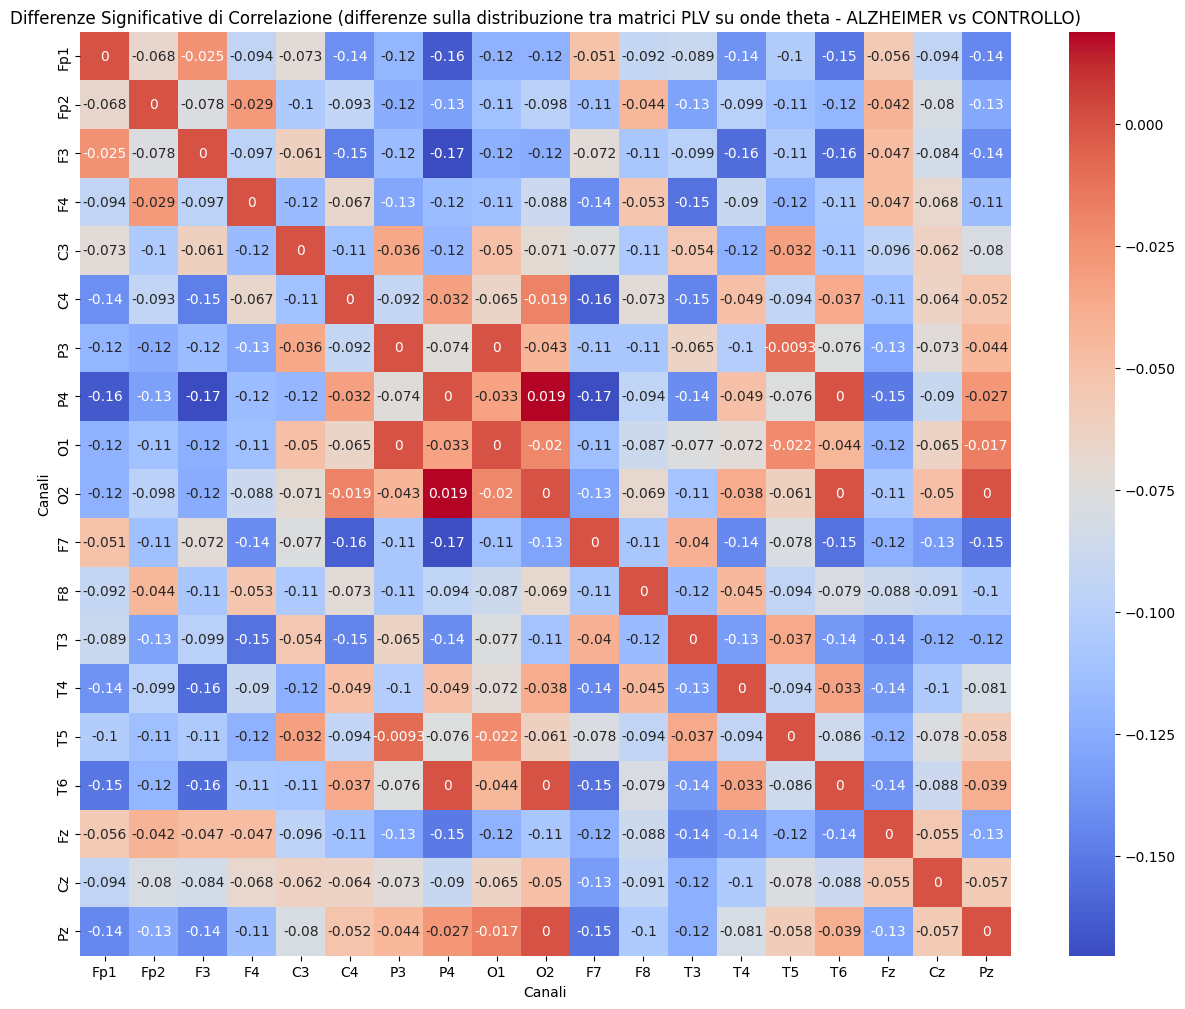

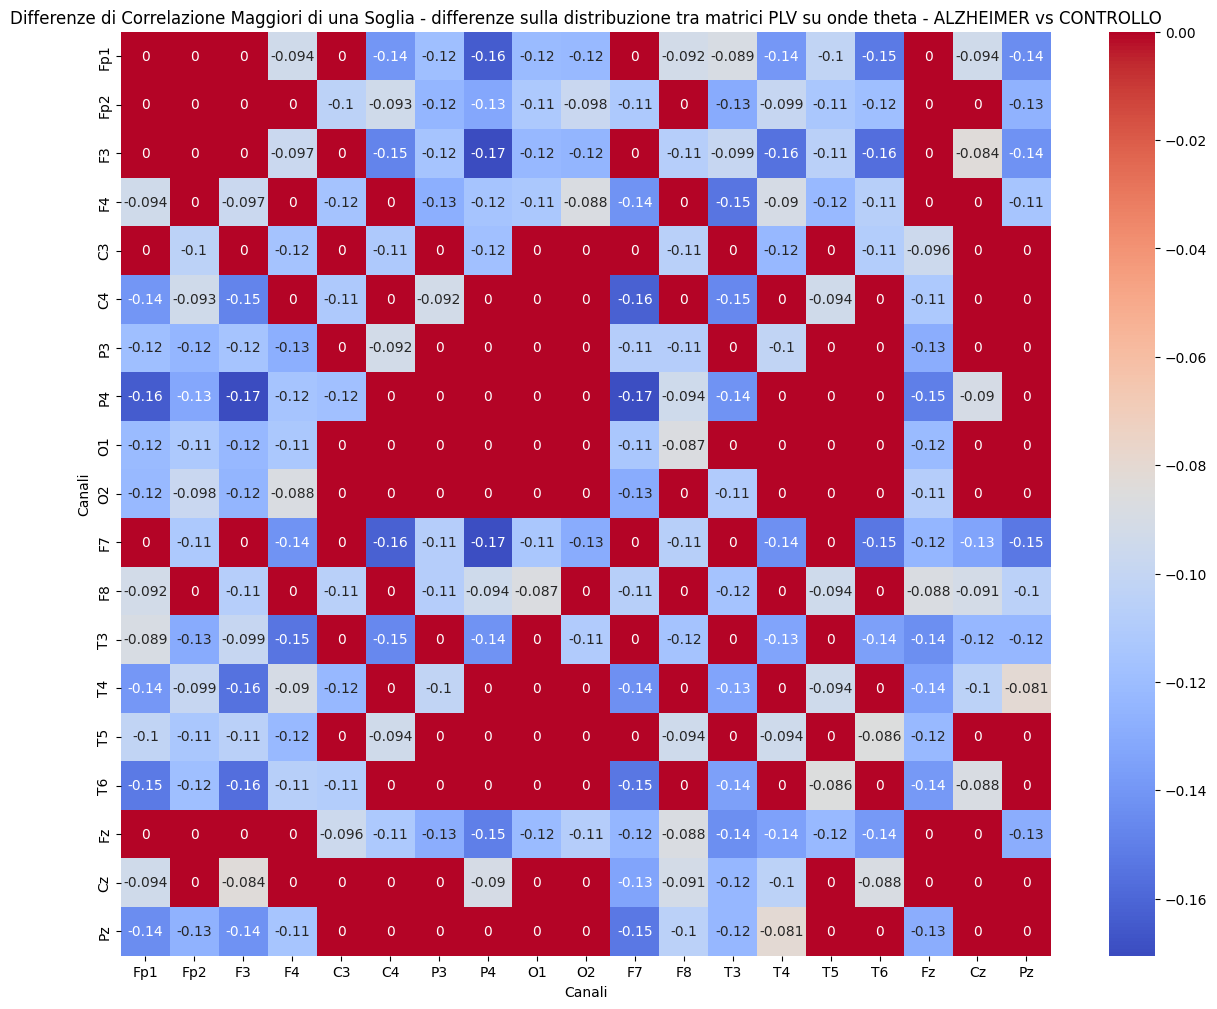

Differenza significativa tra i canali Fp1 e F4: -0.0938
Differenza significativa tra i canali Fp1 e C4: -0.1404
Differenza significativa tra i canali Fp1 e P3: -0.1188
Differenza significativa tra i canali Fp1 e P4: -0.1643
Differenza significativa tra i canali Fp1 e O1: -0.1214
Differenza significativa tra i canali Fp1 e O2: -0.1224
Differenza significativa tra i canali Fp1 e F8: -0.0919
Differenza significativa tra i canali Fp1 e T3: -0.0891
Differenza significativa tra i canali Fp1 e T4: -0.1392
Differenza significativa tra i canali Fp1 e T5: -0.1019
Differenza significativa tra i canali Fp1 e T6: -0.1519
Differenza significativa tra i canali Fp1 e Cz: -0.0937
Differenza significativa tra i canali Fp1 e Pz: -0.1443
Differenza significativa tra i canali Fp2 e C3: -0.1045
Differenza significativa tra i canali Fp2 e C4: -0.0933
Differenza significativa tra i canali Fp2 e P3: -0.1241
Differenza significativa tra i canali Fp2 e P4: -0.1320
Differenza significativa tra i canali Fp2 e O1: 

In [ ]:
# Calcolo differenze statistiche significative per matrici PLV
adj_matr_alz = alz_adjacency_plv_matrices_array_theta
nor_matr_alz = nor_adjacency_plv_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzione tra matrici PLV su onde theta - ALZHEIMER vs CONTROLLO")


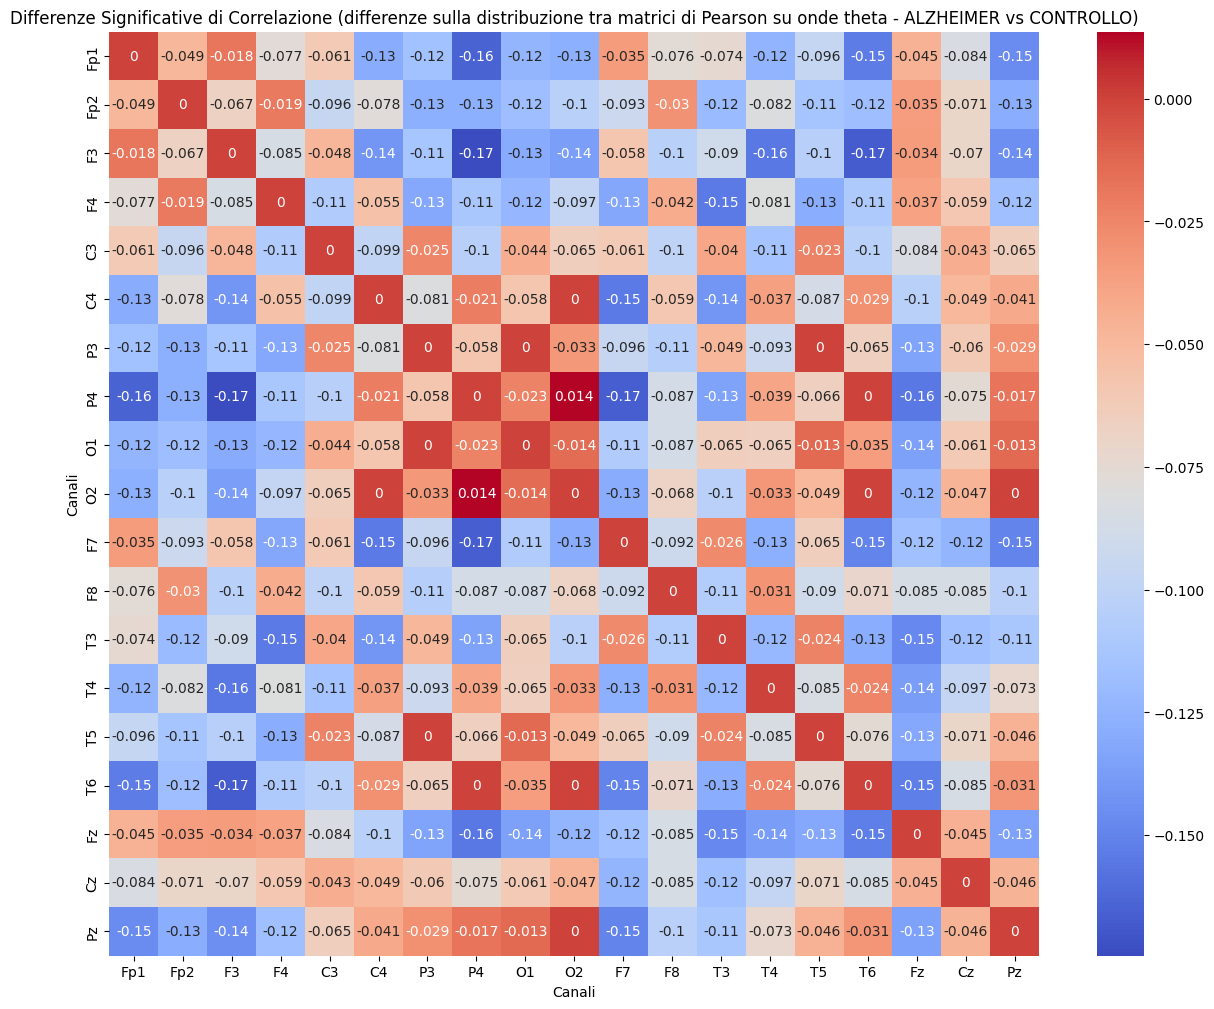

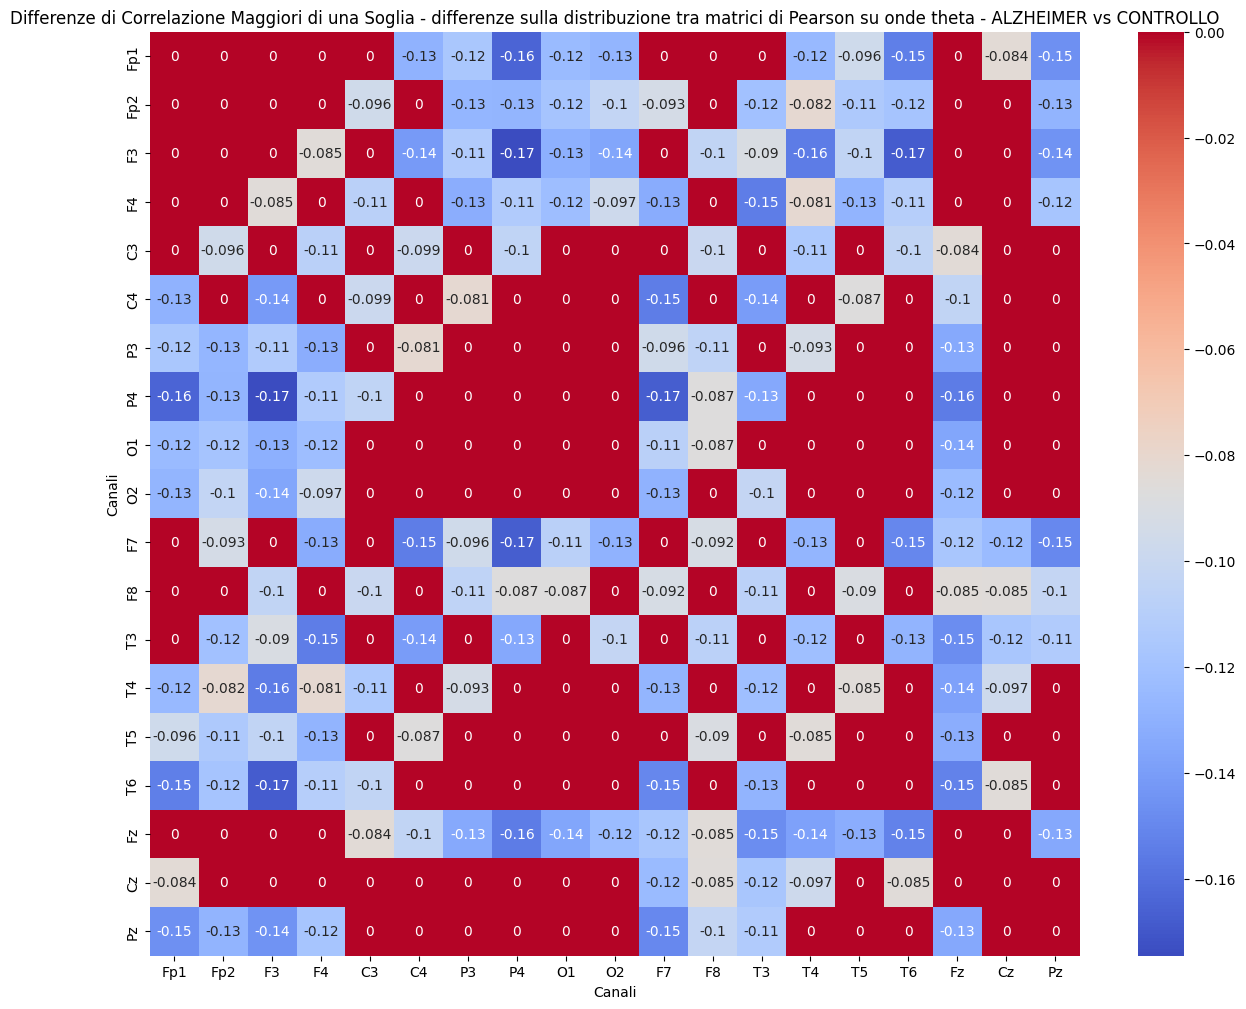

Differenza significativa tra i canali Fp1 e C4: -0.1293
Differenza significativa tra i canali Fp1 e P3: -0.1164
Differenza significativa tra i canali Fp1 e P4: -0.1643
Differenza significativa tra i canali Fp1 e O1: -0.1242
Differenza significativa tra i canali Fp1 e O2: -0.1282
Differenza significativa tra i canali Fp1 e T4: -0.1250
Differenza significativa tra i canali Fp1 e T5: -0.0964
Differenza significativa tra i canali Fp1 e T6: -0.1535
Differenza significativa tra i canali Fp1 e Cz: -0.0837
Differenza significativa tra i canali Fp1 e Pz: -0.1461
Differenza significativa tra i canali Fp2 e C3: -0.0958
Differenza significativa tra i canali Fp2 e P3: -0.1268
Differenza significativa tra i canali Fp2 e P4: -0.1279
Differenza significativa tra i canali Fp2 e O1: -0.1186
Differenza significativa tra i canali Fp2 e O2: -0.1036
Differenza significativa tra i canali Fp2 e F7: -0.0928
Differenza significativa tra i canali Fp2 e T3: -0.1203
Differenza significativa tra i canali Fp2 e T4: 

In [ ]:
# Calcolo differenze statistiche significative per matrici di Pearson
adj_matr_alz = alz_adjacency_pearson_matrices_array_theta
nor_matr_alz = nor_adjacency_pearson_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzione tra matrici di Pearson su onde theta - ALZHEIMER vs CONTROLLO")

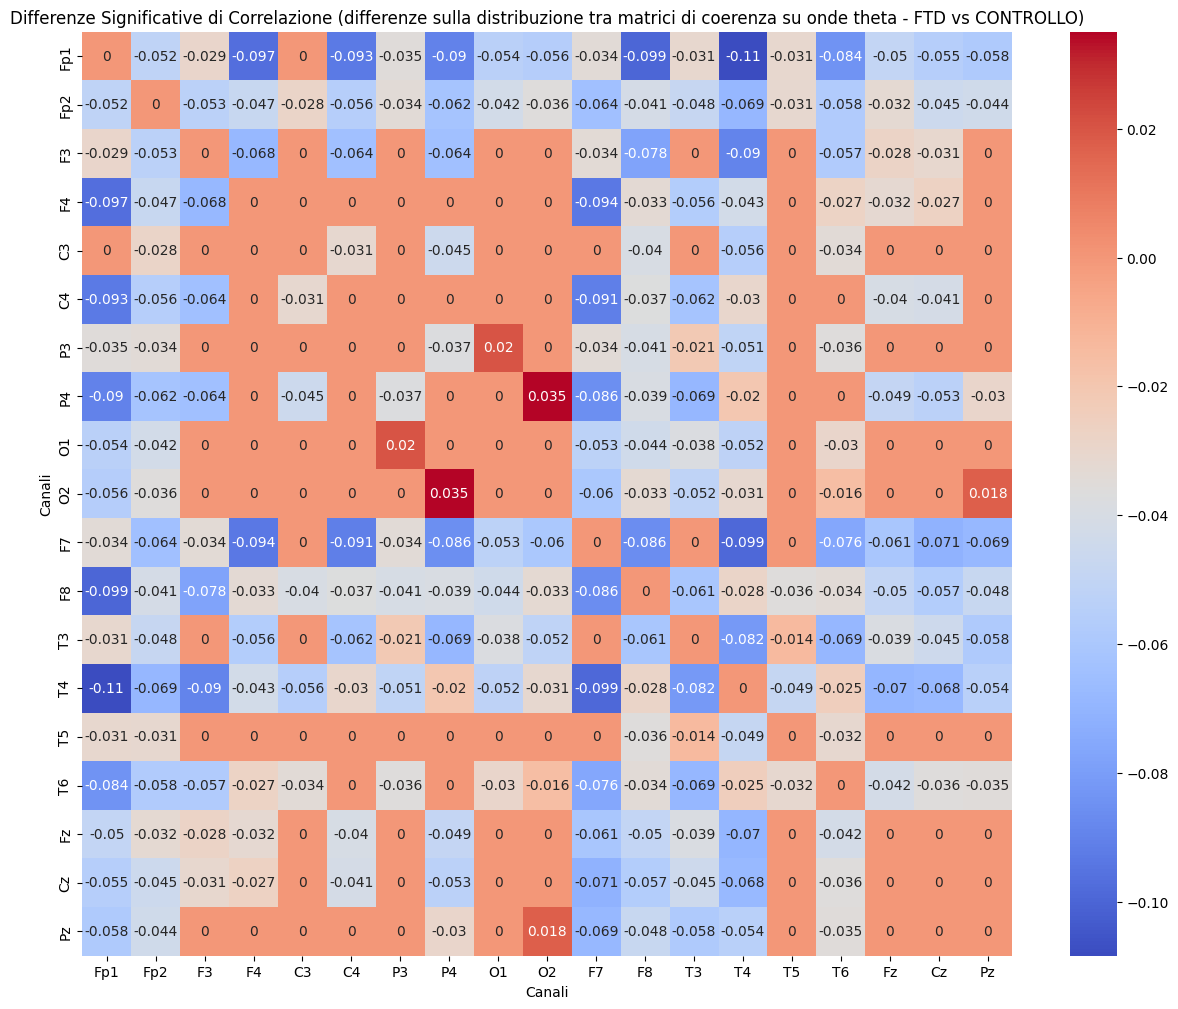

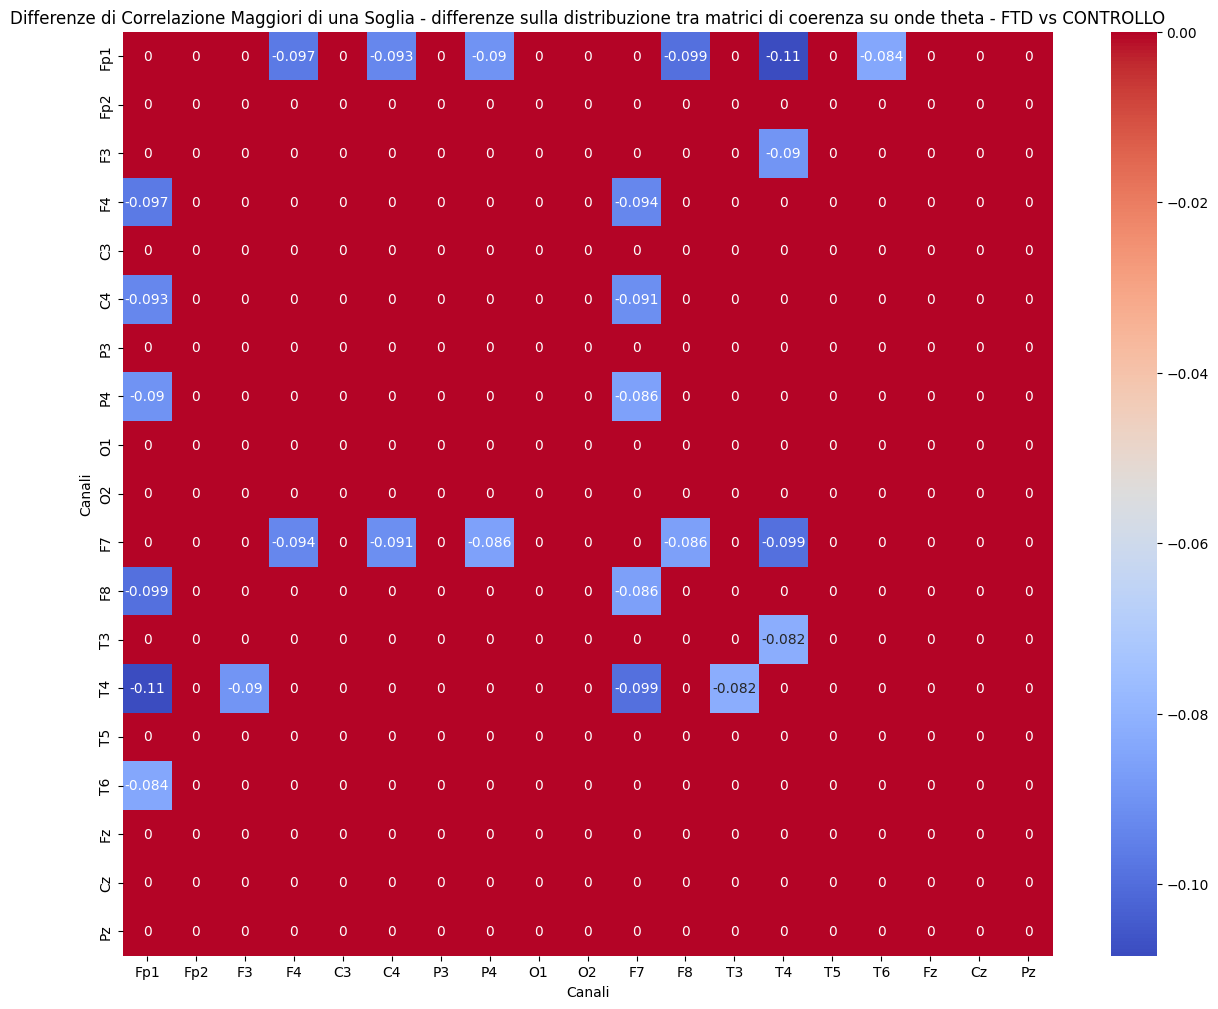

Differenza significativa tra i canali Fp1 e F4: -0.0968
Differenza significativa tra i canali Fp1 e C4: -0.0933
Differenza significativa tra i canali Fp1 e P4: -0.0900
Differenza significativa tra i canali Fp1 e F8: -0.0995
Differenza significativa tra i canali Fp1 e T4: -0.1084
Differenza significativa tra i canali Fp1 e T6: -0.0841
Differenza significativa tra i canali F3 e T4: -0.0896
Differenza significativa tra i canali F4 e F7: -0.0935
Differenza significativa tra i canali C4 e F7: -0.0912
Differenza significativa tra i canali P4 e F7: -0.0859
Differenza significativa tra i canali F7 e F8: -0.0863
Differenza significativa tra i canali F7 e T4: -0.0991
Differenza significativa tra i canali T3 e T4: -0.0819


In [ ]:
# # Calcolo differenze statistiche significative per matrici COERENZA - FTD  vs CONTROLLO
adj_matr_alz = ftd_adjacency_coherence_matrices_array_theta
nor_matr_alz = nor_adjacency_coherence_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzione tra matrici di coerenza su onde theta - FTD vs CONTROLLO")

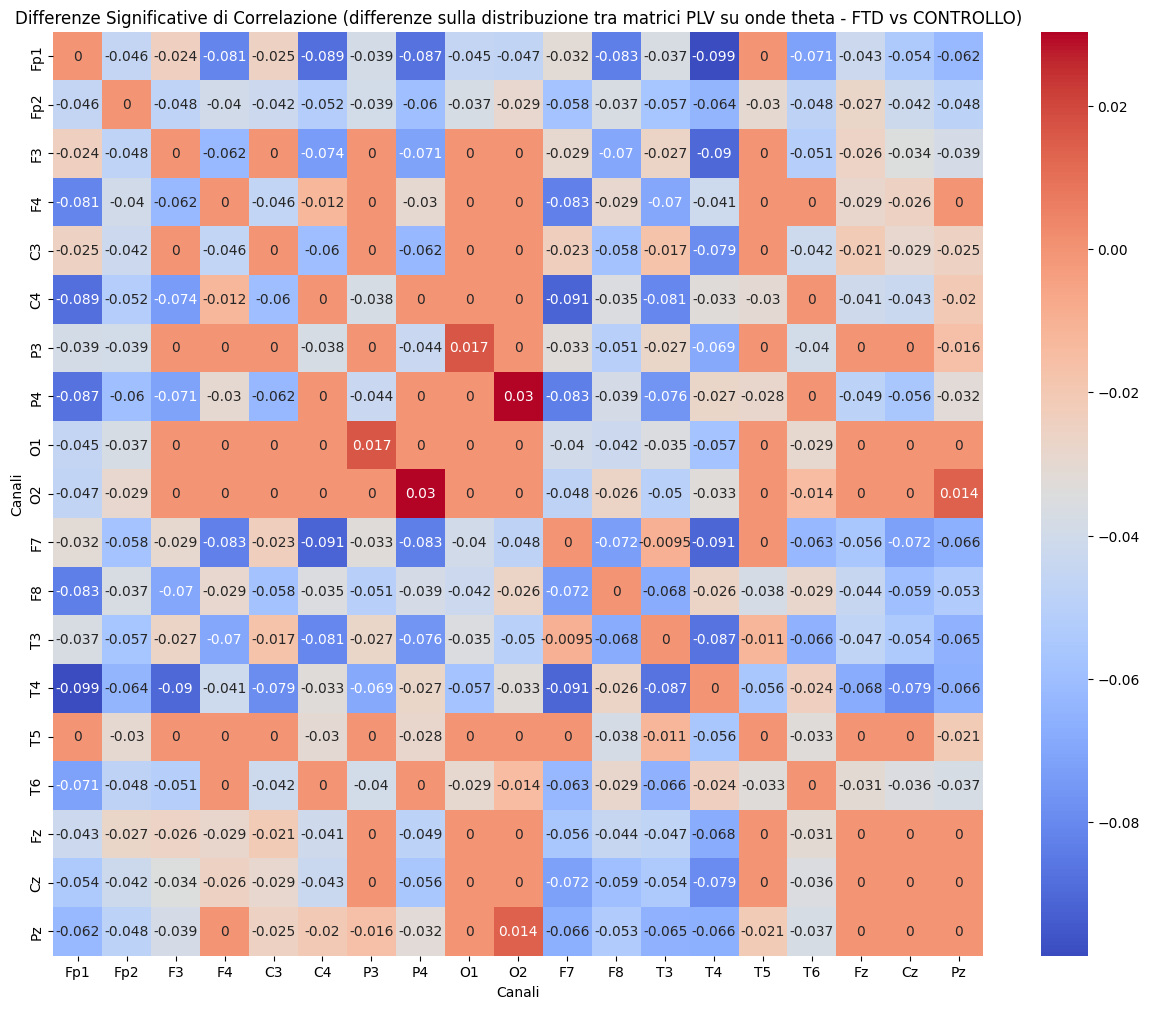

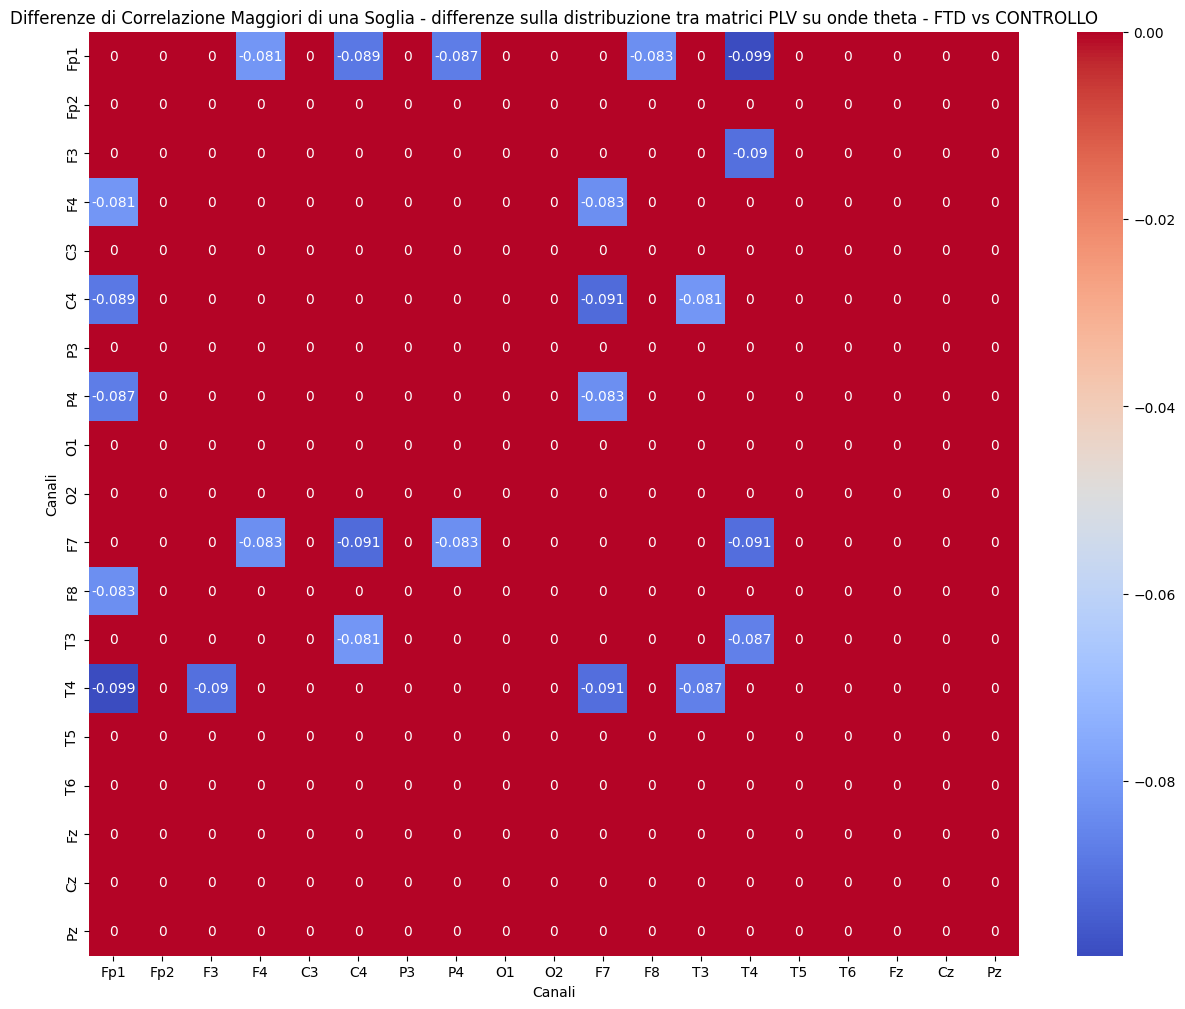

Differenza significativa tra i canali Fp1 e F4: -0.0810
Differenza significativa tra i canali Fp1 e C4: -0.0885
Differenza significativa tra i canali Fp1 e P4: -0.0873
Differenza significativa tra i canali Fp1 e F8: -0.0830
Differenza significativa tra i canali Fp1 e T4: -0.0986
Differenza significativa tra i canali F3 e T4: -0.0903
Differenza significativa tra i canali F4 e F7: -0.0830
Differenza significativa tra i canali C4 e F7: -0.0915
Differenza significativa tra i canali C4 e T3: -0.0809
Differenza significativa tra i canali P4 e F7: -0.0831
Differenza significativa tra i canali F7 e T4: -0.0907
Differenza significativa tra i canali T3 e T4: -0.0866


In [ ]:
# Calcolo differenze statistiche significative per matrici PLV - FTD  vs CONTROLLO
adj_matr_alz = ftd_adjacency_plv_matrices_array_theta
nor_matr_alz = nor_adjacency_plv_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzione tra matrici PLV su onde theta - FTD vs CONTROLLO")

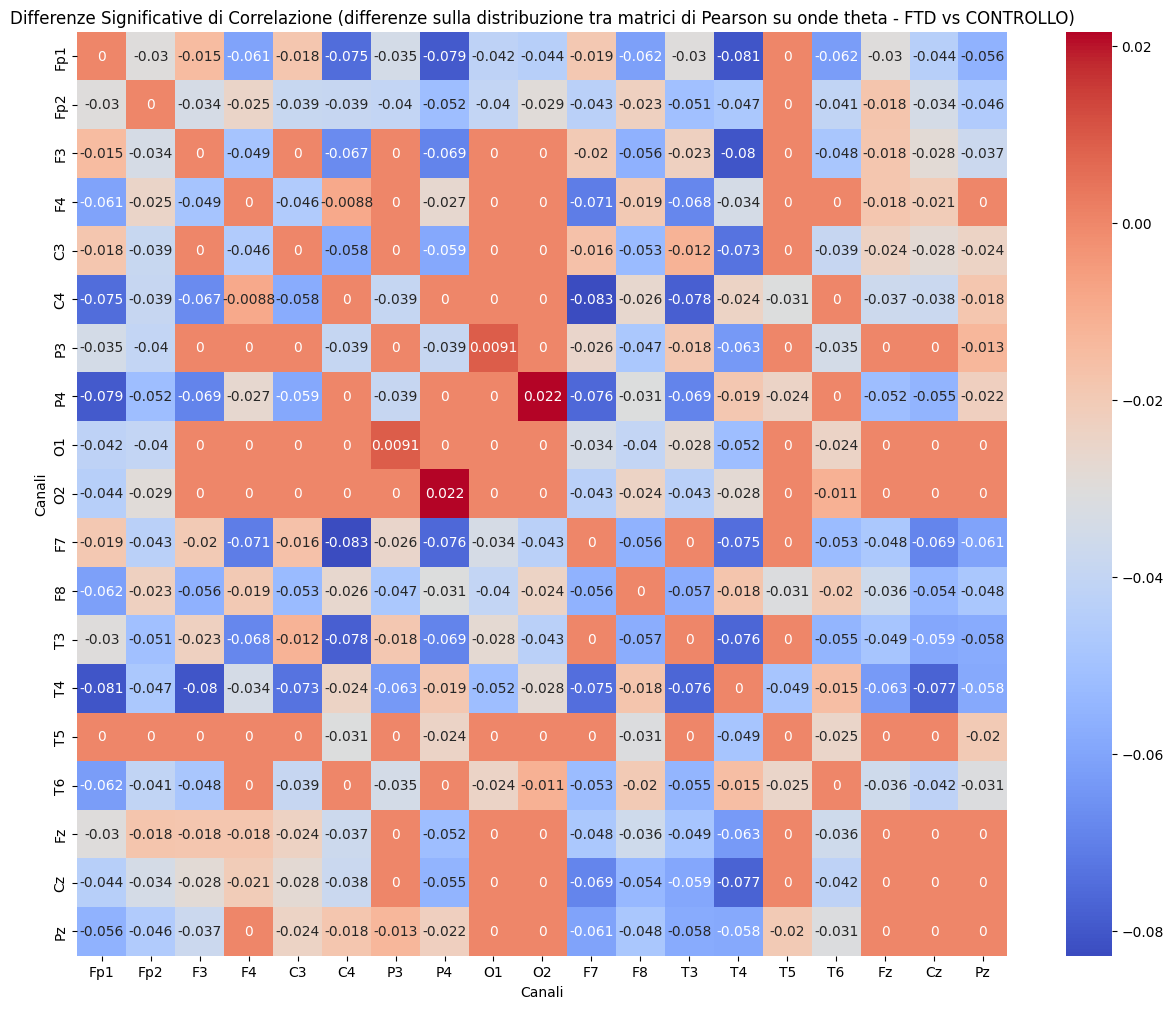

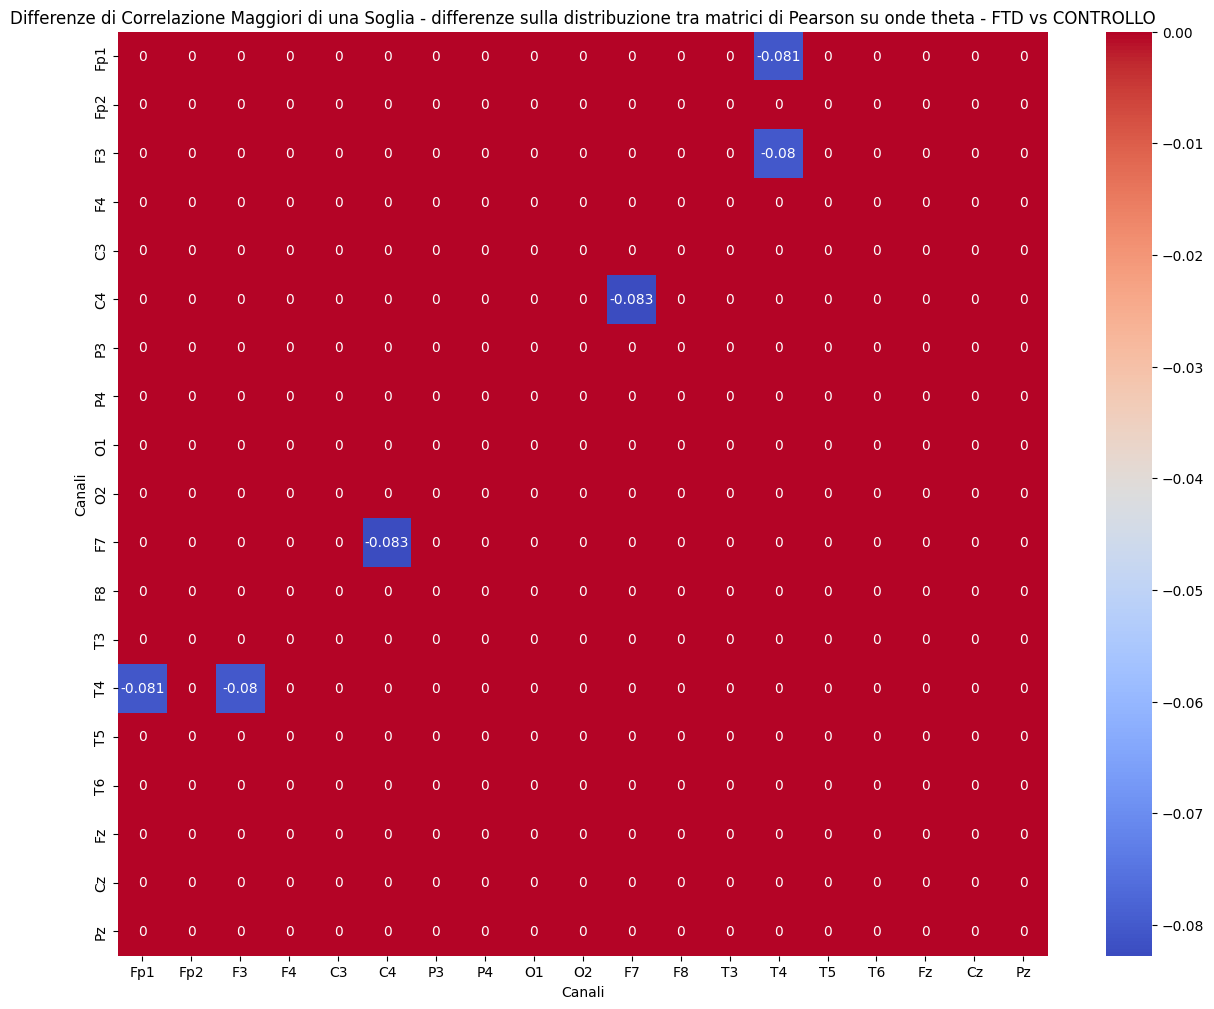

Differenza significativa tra i canali Fp1 e T4: -0.0807
Differenza significativa tra i canali F3 e T4: -0.0803
Differenza significativa tra i canali C4 e F7: -0.0827


In [ ]:
# Calcolo differenze statistiche significative per matrici di Pearson - FTD  vs CONTROLLO
adj_matr_alz = ftd_adjacency_pearson_matrices_array_theta
nor_matr_alz = nor_adjacency_pearson_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzione tra matrici di Pearson su onde theta - FTD vs CONTROLLO")

##Alzheimer vs FTD

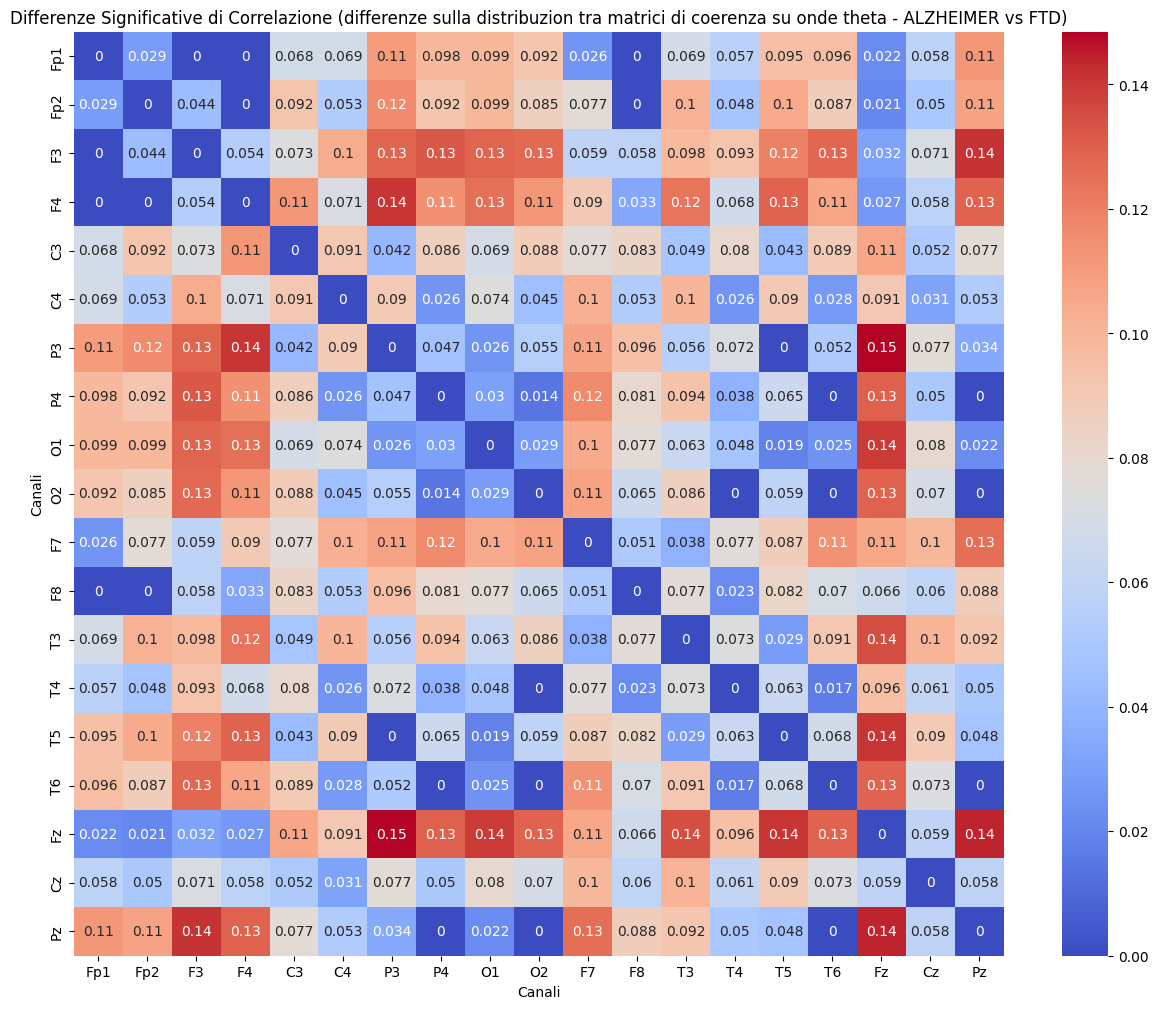

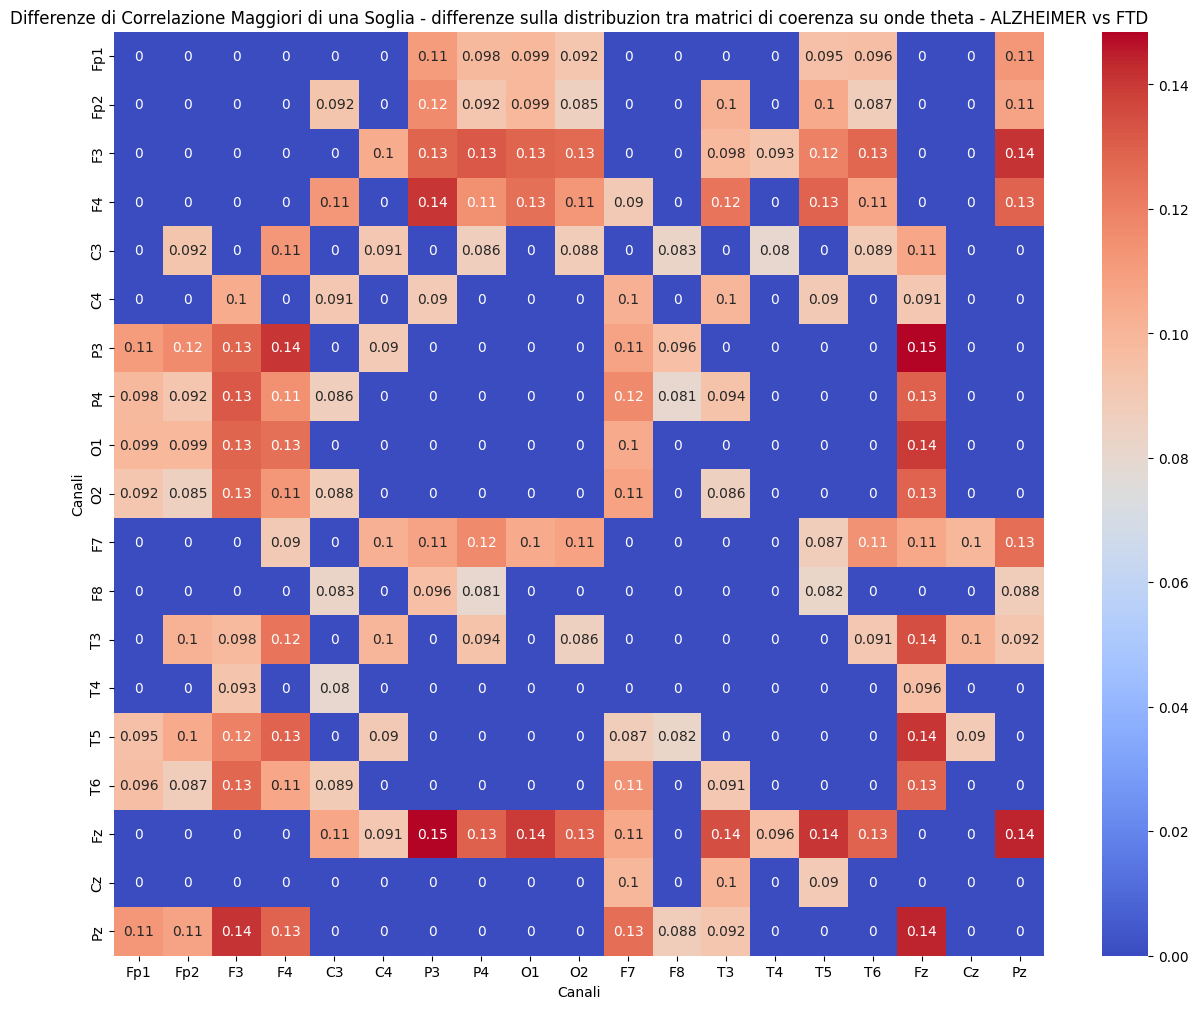

Differenza significativa tra i canali Fp1 e P3: 0.1102
Differenza significativa tra i canali Fp1 e P4: 0.0983
Differenza significativa tra i canali Fp1 e O1: 0.0990
Differenza significativa tra i canali Fp1 e O2: 0.0921
Differenza significativa tra i canali Fp1 e T5: 0.0949
Differenza significativa tra i canali Fp1 e T6: 0.0959
Differenza significativa tra i canali Fp1 e Pz: 0.1120
Differenza significativa tra i canali Fp2 e C3: 0.0924
Differenza significativa tra i canali Fp2 e P3: 0.1163
Differenza significativa tra i canali Fp2 e P4: 0.0922
Differenza significativa tra i canali Fp2 e O1: 0.0988
Differenza significativa tra i canali Fp2 e O2: 0.0854
Differenza significativa tra i canali Fp2 e T3: 0.1018
Differenza significativa tra i canali Fp2 e T5: 0.1050
Differenza significativa tra i canali Fp2 e T6: 0.0872
Differenza significativa tra i canali Fp2 e Pz: 0.1077
Differenza significativa tra i canali F3 e C4: 0.1040
Differenza significativa tra i canali F3 e P3: 0.1284
Differenza s

In [ ]:
# Calcolo differenze statistiche significative per matrici di COERENZA - FTD  vs ALZHEIMER
adj_matr_alz = ftd_adjacency_coherence_matrices_array_theta
nor_matr_alz = alz_adjacency_coherence_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzion tra matrici di coerenza su onde theta - ALZHEIMER vs FTD")

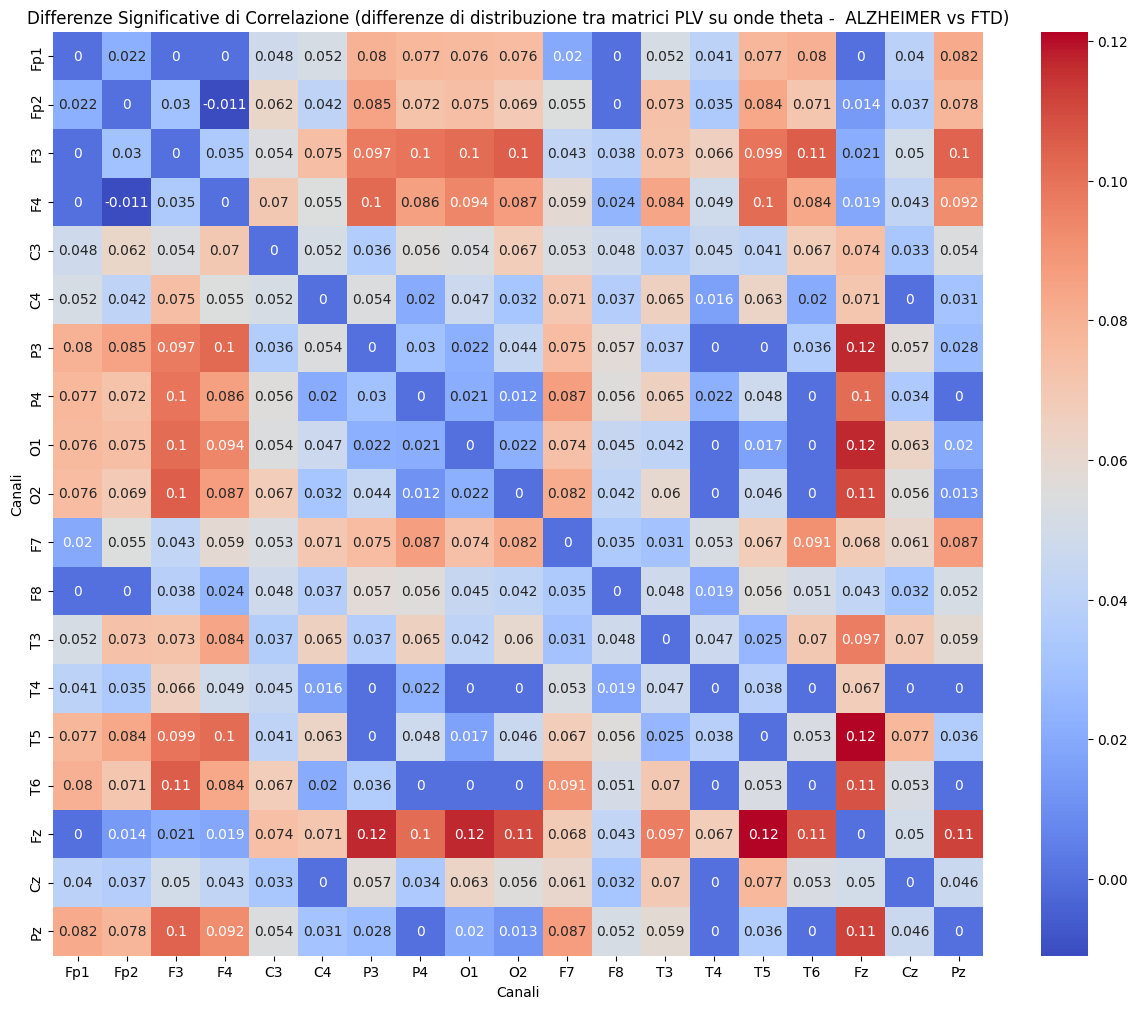

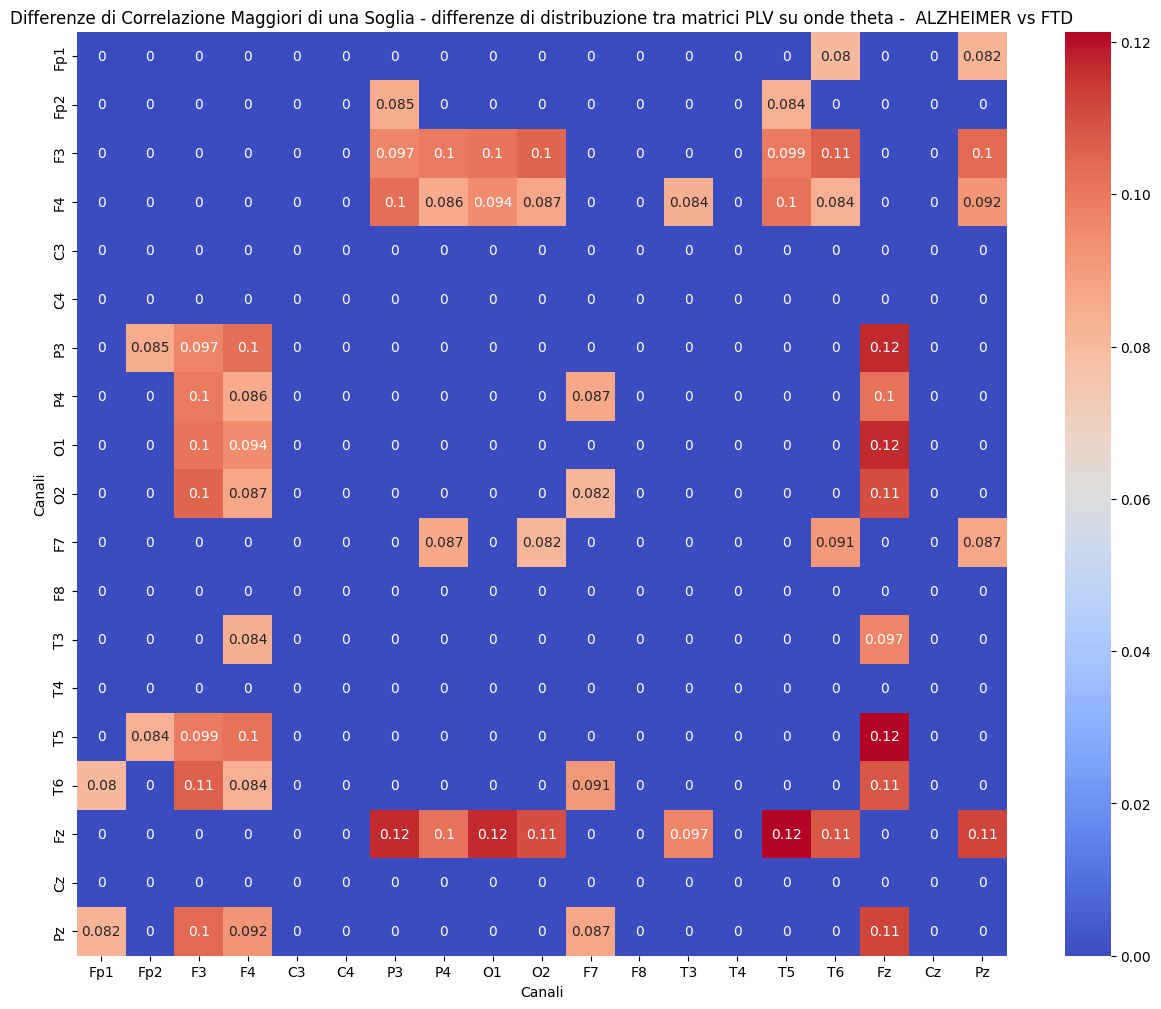

Differenza significativa tra i canali Fp1 e T6: 0.0804
Differenza significativa tra i canali Fp1 e Pz: 0.0824
Differenza significativa tra i canali Fp2 e P3: 0.0849
Differenza significativa tra i canali Fp2 e T5: 0.0835
Differenza significativa tra i canali F3 e P3: 0.0972
Differenza significativa tra i canali F3 e P4: 0.0995
Differenza significativa tra i canali F3 e O1: 0.1014
Differenza significativa tra i canali F3 e O2: 0.1049
Differenza significativa tra i canali F3 e T5: 0.0993
Differenza significativa tra i canali F3 e T6: 0.1058
Differenza significativa tra i canali F3 e Pz: 0.1038
Differenza significativa tra i canali F4 e P3: 0.1026
Differenza significativa tra i canali F4 e P4: 0.0857
Differenza significativa tra i canali F4 e O1: 0.0944
Differenza significativa tra i canali F4 e O2: 0.0870
Differenza significativa tra i canali F4 e T3: 0.0842
Differenza significativa tra i canali F4 e T5: 0.1015
Differenza significativa tra i canali F4 e T6: 0.0836
Differenza significativa

In [ ]:
# Calcolo differenze statistiche significative per matrici PLV - FTD  vs ALZHEIMER
adj_matr_alz = ftd_adjacency_plv_matrices_array_theta
nor_matr_alz = alz_adjacency_plv_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze di distribuzione tra matrici PLV su onde theta -  ALZHEIMER vs FTD")

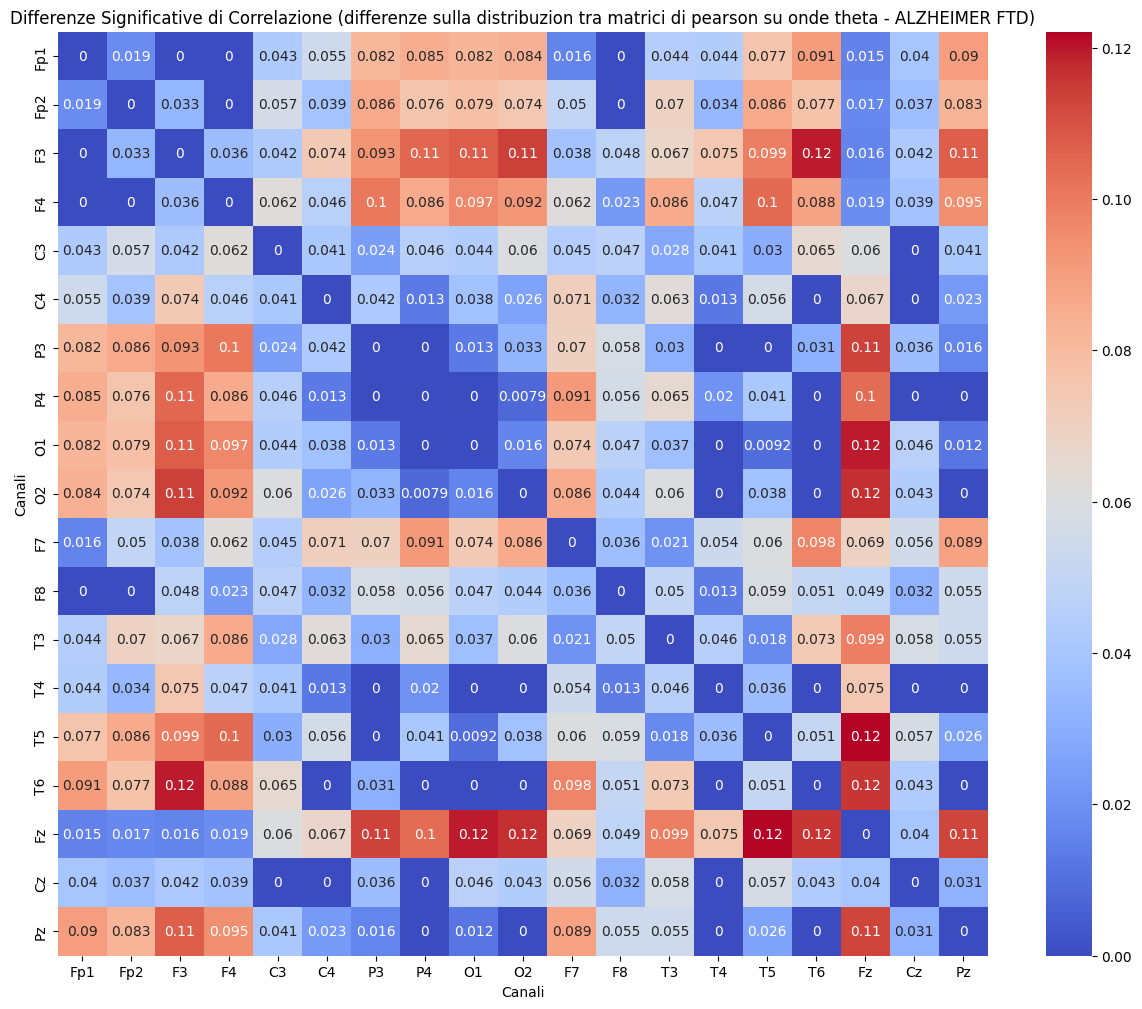

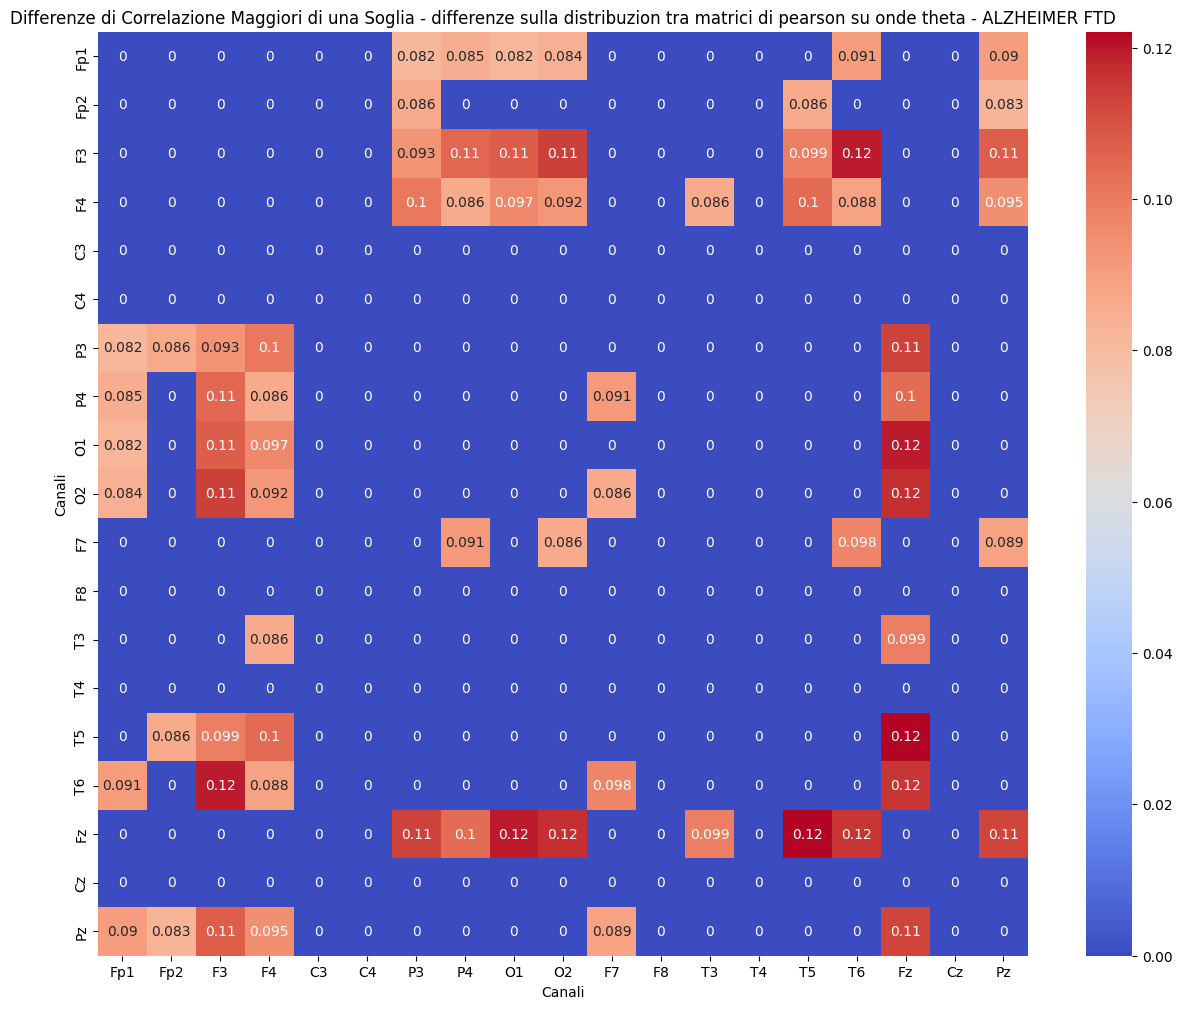

Differenza significativa tra i canali Fp1 e P3: 0.0817
Differenza significativa tra i canali Fp1 e P4: 0.0851
Differenza significativa tra i canali Fp1 e O1: 0.0824
Differenza significativa tra i canali Fp1 e O2: 0.0844
Differenza significativa tra i canali Fp1 e T6: 0.0911
Differenza significativa tra i canali Fp1 e Pz: 0.0903
Differenza significativa tra i canali Fp2 e P3: 0.0865
Differenza significativa tra i canali Fp2 e T5: 0.0860
Differenza significativa tra i canali Fp2 e Pz: 0.0829
Differenza significativa tra i canali F3 e P3: 0.0934
Differenza significativa tra i canali F3 e P4: 0.1053
Differenza significativa tra i canali F3 e O1: 0.1074
Differenza significativa tra i canali F3 e O2: 0.1139
Differenza significativa tra i canali F3 e T5: 0.0988
Differenza significativa tra i canali F3 e T6: 0.1196
Differenza significativa tra i canali F3 e Pz: 0.1073
Differenza significativa tra i canali F4 e P3: 0.1010
Differenza significativa tra i canali F4 e P4: 0.0859
Differenza signific

In [ ]:
# Calcolo differenze statistiche significative per matrici di Pearson - FTD  vs ALZHEIMER
adj_matr_alz = ftd_adjacency_pearson_matrices_array_theta
nor_matr_alz = alz_adjacency_pearson_matrices_array_theta
calculate_and_plot_differences(adj_matr_alz, nor_matr_alz, ch_names, "differenze sulla distribuzion tra matrici di pearson su onde theta - ALZHEIMER FTD")

# GRAPH CONVOLUTIONAL NEURAL NETWORK IN AZIONE

## Modello semplice senza dropout e regolarizzazione

I valori in uscita mostrano un buon andamento del modello GCNN (Graph Convolutional Neural Network) durante l'addestramento e la validazione. Ecco un'analisi dettagliata:
Analisi dei Risultati
Epoch 1-5

    Train Loss e Val Loss: Si nota una riduzione costante di entrambi i valori di loss, indicando che il modello sta imparando bene.
    Train Acc e Val Acc: L'accuratezza aumenta significativamente, con la Val Acc che passa da 0.6533 a 0.8514.
    Train F1 e Val F1: Anche il punteggio F1 migliora, suggerendo un buon bilanciamento tra precision e recall.

Epoch 6-10

    Train Loss e Val Loss: Il Train Loss diminuisce rapidamente fino a 0.0699, mentre il Val Loss mostra una variabilità ma una tendenza al miglioramento.
    Train Acc e Val Acc: Si nota un netto miglioramento, con valori che raggiungono quasi il massimo (Train Acc: 0.9874, Val Acc: 0.9257).
    Train F1 e Val F1: Anche il punteggio F1 riflette questo miglioramento.

Epoch 11-20

    Train Loss e Val Loss: Il Train Loss continua a scendere, toccando valori estremamente bassi (fino a 0.0047), mentre il Val Loss oscilla ma generalmente si riduce.
    Train Acc e Val Acc: L'accuratezza di addestramento raggiunge il massimo (1.0000), mentre la Val Acc continua a migliorare.
    Train F1 e Val F1: Il punteggio F1 rimane alto e costante, indicando un modello ben addestrato.

Epoch 21-30

    Train Loss e Val Loss: Il Train Loss si mantiene estremamente basso, indicando che il modello ha quasi raggiunto la perfezione nell'addestramento. Il Val Loss mostra un miglioramento costante.
    Train Acc e Val Acc: L'accuratezza di addestramento rimane al 100%, e la Val Acc si mantiene alta, raggiungendo 0.9567.
    Train F1 e Val F1: Il punteggio F1 rimane alto e stabile, riflettendo un'ottima prestazione del modello.

Risultati Finali del Test

    Accuracy: 0.9508
    Loss: 0.1044
    F1: 0.9507
    Precision: 0.9507
    Recall: 0.9508



In conclusione il modello GCNN mostra un'ottima performance sia durante l'addestramento che nella fase di validazione e test. La convergenza è buona, con una perdita molto bassa e alte metriche di accuratezza, F1, precisione e recall. I risultati indicano che il modello è stato addestrato in modo efficace e generalizza bene ai dati di test.


Epoch: 1, Train Loss: 0.7377, Val Loss: 0.7782, Train Acc: 0.6190, Val Acc: 0.6244, Train F1: 0.5962, Val F1: 0.5894
Epoch: 2, Train Loss: 0.4623, Val Loss: 0.5313, Train Acc: 0.8271, Val Acc: 0.8000, Train F1: 0.8260, Val F1: 0.8000
Epoch: 3, Train Loss: 0.3311, Val Loss: 0.3097, Train Acc: 0.8762, Val Acc: 0.8889, Train F1: 0.8781, Val F1: 0.8895
Epoch: 4, Train Loss: 0.1427, Val Loss: 0.1770, Train Acc: 0.9648, Val Acc: 0.9378, Train F1: 0.9647, Val F1: 0.9375
Epoch: 5, Train Loss: 0.1745, Val Loss: 0.2947, Train Acc: 0.9295, Val Acc: 0.8956, Train F1: 0.9282, Val F1: 0.8924
Epoch: 6, Train Loss: 0.0619, Val Loss: 0.1146, Train Acc: 0.9881, Val Acc: 0.9578, Train F1: 0.9881, Val F1: 0.9576
Epoch: 7, Train Loss: 0.0353, Val Loss: 0.0756, Train Acc: 0.9948, Val Acc: 0.9756, Train F1: 0.9948, Val F1: 0.9755
Epoch: 8, Train Loss: 0.0204, Val Loss: 0.0649, Train Acc: 0.9995, Val Acc: 0.9800, Train F1: 0.9995, Val F1: 0.9800
Epoch: 9, Train Loss: 0.0324, Val Loss: 0.0768, Train Acc: 0.994

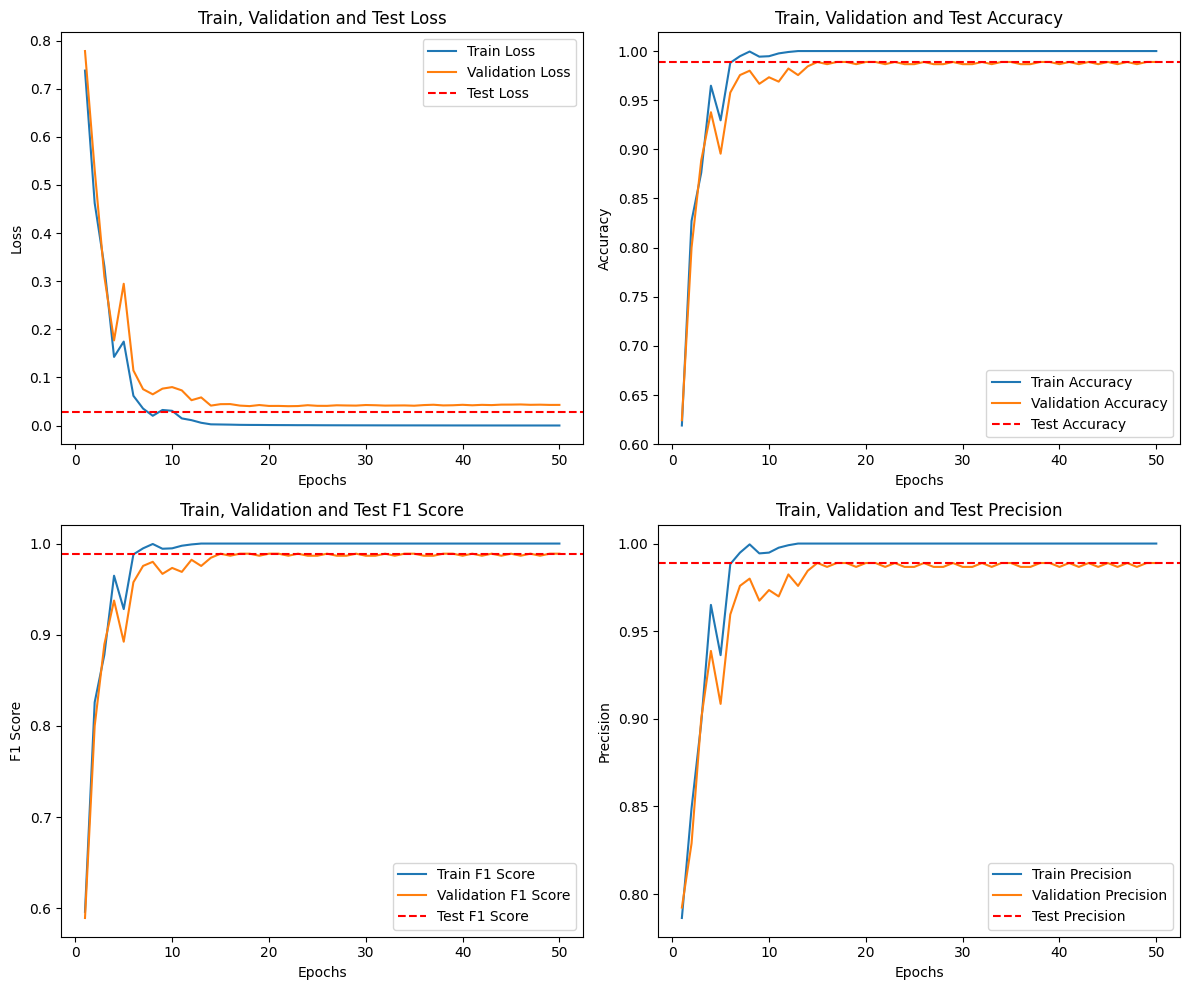

Final Test Results - Accuracy: 0.9889, Loss: 0.0292, F1: 0.9889, Precision: 0.9890, Recall: 0.9889


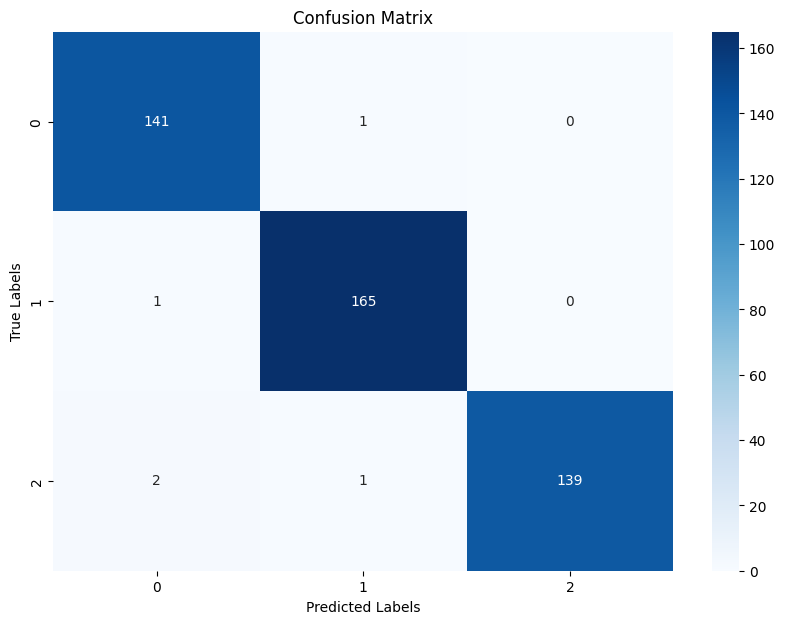

In [ ]:
# MODELLO SEMPLICE
# Parametri del modello
num_classes = 3
num_node_features = 110
num_epochs = 50
adjacency_matrices_array_1 = adjacency_coherence_matrices_array_theta
adjacency_matrices_array_2 = adjacency_pearson_matrices_array_theta
adjacency_matrices_array_3 = adjacency_plv_matrices_array_theta
threshold = 0.98
adj_arr_matrix_1 = np.where(adjacency_matrices_array_1 < threshold, 0, adjacency_matrices_array_1)
adj_arr_matrix_2 = np.where(adjacency_matrices_array_2 < threshold, 0, adjacency_matrices_array_2)
adj_arr_matrix_3 = np.where(adjacency_matrices_array_3 < threshold, 0, adjacency_matrices_array_3)


# Definizione della classe EEGDataset
class EEGDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None, pre_transform=None):
        super(EEGDataset, self).__init__('.', transform, pre_transform)
        self.data_list = data_list
        self.data, self.slices = self.collate(data_list)

    def _download(self):
        pass

    def _process(self):
        pass

# Creo il  dataset
data_list = []
for i in range(adj_arr_matrix_1.shape[0]):
    # Converti le tre matrici di adiacenza in rappresentazioni sparse
    adj_matrix_1 = adj_arr_matrix_1[i]
    edge_index_1, edge_weight_1 = dense_to_sparse(torch.tensor(adj_matrix_1, dtype=torch.float))

    adj_matrix_2 = adj_arr_matrix_2[i]
    edge_index_2, edge_weight_2 = dense_to_sparse(torch.tensor(adj_matrix_2, dtype=torch.float))

    adj_matrix_3 = adj_arr_matrix_3[i]
    edge_index_3, edge_weight_3 = dense_to_sparse(torch.tensor(adj_matrix_3, dtype=torch.float))

    # Converto le feature dei nodi in un tensore
    x = torch.tensor(features_array[i], dtype=torch.float)

    # Ottengo le labels
    y = torch.tensor(labels_array[i], dtype=torch.long)

    # Crea un oggetto Data con le tre matrici di adiacenza
    data = Data(x=x, edge_index_1=edge_index_1, edge_attr_1=edge_weight_1,
                     edge_index_2=edge_index_2, edge_attr_2=edge_weight_2,
                     edge_index_3=edge_index_3, edge_attr_3=edge_weight_3, y=y)

    # Aggiungi l'oggetto Data alla lista
    data_list.append(data)

dataset = EEGDataset(data_list)
dataset = dataset.shuffle()

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size + val_size]
test_dataset = dataset[train_size + val_size:]

# Definizione del modello GCNN con tre matrici di adiacenza
class MultiAdjGCNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(MultiAdjGCNN, self).__init__()
        self.conv1_1 = GCNConv(num_node_features, hidden_channels)
        self.conv1_2 = GCNConv(num_node_features, hidden_channels)
        self.conv1_3 = GCNConv(num_node_features, hidden_channels)

        self.conv2_1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels * 3, num_classes)

    def forward(self, data):
        x = data.x

        # Prima convoluzione
        x1 = F.relu(self.conv1_1(x, data.edge_index_1))
        x2 = F.relu(self.conv1_2(x, data.edge_index_2))
        x3 = F.relu(self.conv1_3(x, data.edge_index_3))

        # Seconda convoluzione
        x1 = F.relu(self.conv2_1(x1, data.edge_index_1))
        x2 = F.relu(self.conv2_2(x2, data.edge_index_2))
        x3 = F.relu(self.conv2_3(x3, data.edge_index_3))

        # Pooling globale
        x1 = global_mean_pool(x1, data.batch)
        x2 = global_mean_pool(x2, data.batch)
        x3 = global_mean_pool(x3, data.batch)

        # Concatenazione delle features
        x = torch.cat([x1, x2, x3], dim=1)

        # Strato finale lineare
        x = self.lin(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiAdjGCNN(num_node_features=110, hidden_channels=32, num_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    return accuracy, total_loss / len(loader), f1, precision, recall

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, train_loader, criterion)
    train_acc, train_loss, train_f1, train_precision, train_recall = evaluate(model, train_loader, criterion)
    val_acc, val_loss, val_f1, val_precision, val_recall = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

# Test finale
test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

print(f'Final Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Visualizzazione dei risultati
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 10))

# Plot delle perdite
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train, Validation and Test Loss')

# Plot delle accuratezze
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train, Validation and Test Accuracy')

# Plot dei F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Train, Validation and Test F1 Score')

# Plot delle Precision
plt.subplot(2, 2, 4)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.axhline(y=test_precision, color='r', linestyle='--', label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Train, Validation and Test Precision')

plt.tight_layout()
plt.show()



# Test finale e visualizzazione della matrice di confusione
test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

print(f'Final Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Creazione della matrice di confusione
all_preds = []
all_labels = []

model.eval()
for data in test_loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    all_preds.extend(pred.cpu().numpy())
    all_labels.extend(data.y.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)

# Visualizzazione della matrice di confusione con una grafica professionale
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



##Modello con dropout e regolarizzazione
Analisi dei Risultati

    Perdita (Loss):
        Addestramento: La perdita durante l'addestramento è scesa da 0.9205 nell'epoca 1 a valori molto bassi nelle epoche successive, come 0.0612 nell'epoca 91.
        Validazione: La perdita di validazione segue una tendenza simile, diminuendo da 0.9827 nell'epoca 1 a valori intorno a 0.1406.

    Accuratezza (Accuracy):
        Addestramento: L'accuratezza durante l'addestramento è aumentata costantemente da 0.5712 nell'epoca 1 a valori elevati come 0.9927 nelle epoche finali.
        Validazione: L'accuratezza di validazione ha mostrato un miglioramento simile, passando da 0.5418 nell'epoca 1 a 0.9505.

    F1-Score:
        Addestramento: L'F1-Score di addestramento è cresciuto da 0.5141 nell'epoca 1 a valori sopra 0.9900 nelle epoche finali.
        Validazione: L'F1-Score di validazione è aumentato da 0.4903 nell'epoca 1 a valori simili a quelli di addestramento, attestandosi intorno a 0.9505 nelle ultime epoche.

Interpretazione

    Miglioramento Costante: I valori di perdita in costante diminuzione e i valori di accuratezza e F1-Score in costante aumento indicano che la GCNN sta imparando in modo efficace dai dati di addestramento.
    Convergenza: I valori stabili di perdita, accuratezza e F1-Score nelle ultime epoche suggeriscono che il modello ha raggiunto una buona convergenza.
    Generalizzazione: La differenza ridotta tra le metriche di addestramento e validazione nelle epoche finali indica che il modello generalizza bene sui dati di validazione, riducendo il rischio di overfitting.

Considerazioni Finali

In generale, i risultati sono molto positivi. L'accuratezza e l'F1-Score sopra il 95% nelle epoche finali sia per l'addestramento che per la validazione suggeriscono che il modello è molto performante. La perdita bassa indica che gli errori commessi dal modello sono minimi. Se l'accuratezza, l'F1-Score e la perdita si mantengono stabili anche su dati non visti durante l'addestramento (test set), puoi essere fiducioso della robustezza e dell'affidabilità del modello.

Epoch: 1, Train Loss: 0.7170, Val Loss: 0.6617, Train Acc: 0.7143, Val Acc: 0.7489, Train F1: 0.7150, Val F1: 0.7502
Epoch: 2, Train Loss: 0.6559, Val Loss: 0.6006, Train Acc: 0.7062, Val Acc: 0.6978, Train F1: 0.6831, Val F1: 0.6715
Epoch: 3, Train Loss: 0.5603, Val Loss: 0.5338, Train Acc: 0.7719, Val Acc: 0.7756, Train F1: 0.7747, Val F1: 0.7776
Epoch: 4, Train Loss: 0.3940, Val Loss: 0.3706, Train Acc: 0.8705, Val Acc: 0.8578, Train F1: 0.8688, Val F1: 0.8560
Epoch: 5, Train Loss: 0.3012, Val Loss: 0.2834, Train Acc: 0.9000, Val Acc: 0.8778, Train F1: 0.8995, Val F1: 0.8770
Epoch: 6, Train Loss: 0.2543, Val Loss: 0.2586, Train Acc: 0.9181, Val Acc: 0.8911, Train F1: 0.9185, Val F1: 0.8915
Epoch: 7, Train Loss: 0.2615, Val Loss: 0.2506, Train Acc: 0.9010, Val Acc: 0.8933, Train F1: 0.9015, Val F1: 0.8943
Epoch: 8, Train Loss: 0.2202, Val Loss: 0.2253, Train Acc: 0.9162, Val Acc: 0.9044, Train F1: 0.9152, Val F1: 0.9030
Epoch: 9, Train Loss: 0.1631, Val Loss: 0.1761, Train Acc: 0.958

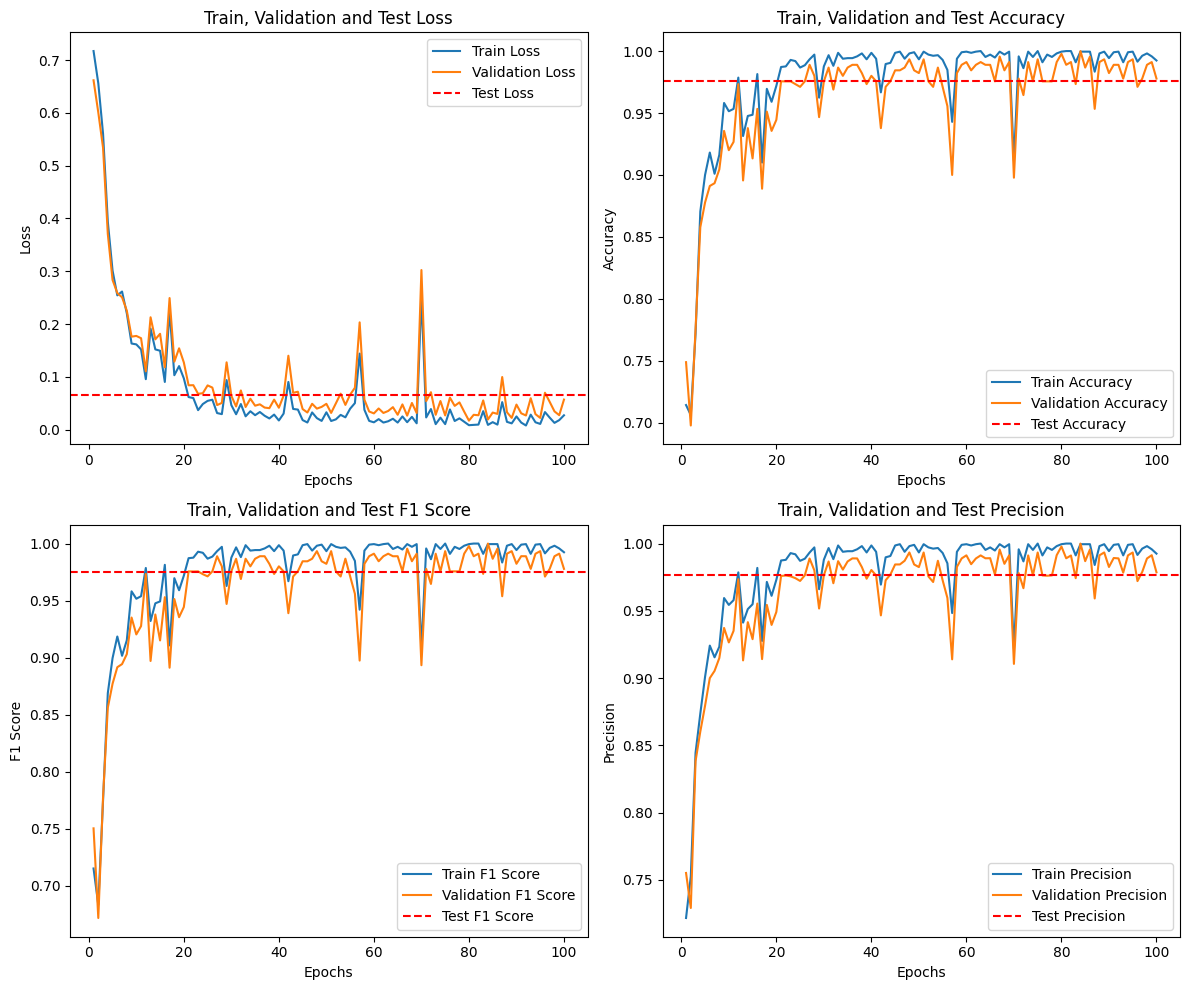

Final Test Results - Accuracy: 0.9756, Loss: 0.0647, F1: 0.9753, Precision: 0.9764, Recall: 0.9756


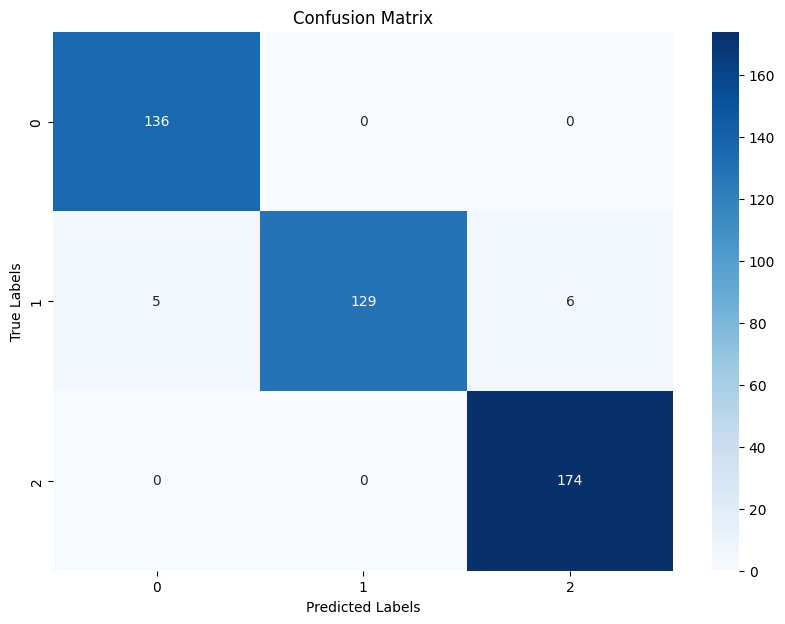

In [ ]:
# MODELLO CON DROPOUT E REGULARIZZAZIONE


# Parametri del modello
num_classes = 3
num_node_features = 110
num_epochs = 100
adjacency_matrices_array_1 = adjacency_coherence_matrices_array_theta
adjacency_matrices_array_2 = adjacency_pearson_matrices_array_theta
adjacency_matrices_array_3 = adjacency_plv_matrices_array_theta
threshold = 0.98
adj_arr_matrix_1 = np.where(adjacency_matrices_array_1 < threshold, 0, adjacency_matrices_array_1)
adj_arr_matrix_2 = np.where(adjacency_matrices_array_2 < threshold, 0, adjacency_matrices_array_2)
adj_arr_matrix_3 = np.where(adjacency_matrices_array_3 < threshold, 0, adjacency_matrices_array_3)


# Definizione della classe EEGDataset
class EEGDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None, pre_transform=None):
        super(EEGDataset, self).__init__('.', transform, pre_transform)
        self.data_list = data_list
        self.data, self.slices = self.collate(data_list)

    def _download(self):
        pass

    def _process(self):
        pass

# Creo il  dataset
data_list = []
for i in range(adj_arr_matrix_1.shape[0]):
    # Converti le tre matrici di adiacenza in rappresentazioni sparse
    adj_matrix_1 = adj_arr_matrix_1[i]
    edge_index_1, edge_weight_1 = dense_to_sparse(torch.tensor(adj_matrix_1, dtype=torch.float))

    adj_matrix_2 = adj_arr_matrix_2[i]
    edge_index_2, edge_weight_2 = dense_to_sparse(torch.tensor(adj_matrix_2, dtype=torch.float))

    adj_matrix_3 = adj_arr_matrix_3[i]
    edge_index_3, edge_weight_3 = dense_to_sparse(torch.tensor(adj_matrix_3, dtype=torch.float))

    # Converto le feature dei nodi in un tensore
    x = torch.tensor(features_array[i], dtype=torch.float)

    # Ottengo le labels
    y = torch.tensor(labels_array[i], dtype=torch.long)

    # Crea un oggetto Data con le tre matrici di adiacenza
    data = Data(x=x, edge_index_1=edge_index_1, edge_attr_1=edge_weight_1,
                     edge_index_2=edge_index_2, edge_attr_2=edge_weight_2,
                     edge_index_3=edge_index_3, edge_attr_3=edge_weight_3, y=y)

    # Aggiungi l'oggetto Data alla lista
    data_list.append(data)

dataset = EEGDataset(data_list)
dataset = dataset.shuffle()

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size + val_size]
test_dataset = dataset[train_size + val_size:]

# Definizione del modello GCNN con tre matrici di adiacenza
class MultiAdjGCNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, dropout_prob=0.5):
        super(MultiAdjGCNN, self).__init__()
        self.conv1_1 = GCNConv(num_node_features, hidden_channels)
        self.conv1_2 = GCNConv(num_node_features, hidden_channels)
        self.conv1_3 = GCNConv(num_node_features, hidden_channels)

        self.conv2_1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels * 3, num_classes)
        self.dropout_prob = dropout_prob

    def forward(self, data):
        x = data.x

        # Prima convoluzione con Dropout
        x1 = F.relu(self.conv1_1(x, data.edge_index_1))
        x1 = F.dropout(x1, p=self.dropout_prob, training=self.training)
        x2 = F.relu(self.conv1_2(x, data.edge_index_2))
        x2 = F.dropout(x2, p=self.dropout_prob, training=self.training)
        x3 = F.relu(self.conv1_3(x, data.edge_index_3))
        x3 = F.dropout(x3, p=self.dropout_prob, training=self.training)

        # Seconda convoluzione con Dropout
        x1 = F.relu(self.conv2_1(x1, data.edge_index_1))
        x1 = F.dropout(x1, p=self.dropout_prob, training=self.training)
        x2 = F.relu(self.conv2_2(x2, data.edge_index_2))
        x2 = F.dropout(x2, p=self.dropout_prob, training=self.training)
        x3 = F.relu(self.conv2_3(x3, data.edge_index_3))
        x3 = F.dropout(x3, p=self.dropout_prob, training=self.training)

        # Pooling globale
        x1 = global_mean_pool(x1, data.batch)
        x2 = global_mean_pool(x2, data.batch)
        x3 = global_mean_pool(x3, data.batch)

        # Concatenazione delle features
        x = torch.cat([x1, x2, x3], dim=1)

        # Strato finale lineare
        x = self.lin(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiAdjGCNN(num_node_features=110, hidden_channels=32, num_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Aggiunta regolarizzazione L2
criterion = torch.nn.CrossEntropyLoss()

def train(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    return accuracy, total_loss / len(loader), f1, precision, recall

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []





for epoch in range(num_epochs):
    train_loss = train(model, optimizer, train_loader, criterion)
    train_acc, train_loss, train_f1, train_precision, train_recall = evaluate(model, train_loader, criterion)
    val_acc, val_loss, val_f1, val_precision, val_recall = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

# Test finale
test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

print(f'Final Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Visualizzazione dei risultati
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 10))

# Plot delle perdite
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train, Validation and Test Loss')

# Plot delle accuratezze
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train, Validation and Test Accuracy')

# Plot dei F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Train, Validation and Test F1 Score')

# Plot delle Precision
plt.subplot(2, 2, 4)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.axhline(y=test_precision, color='r', linestyle='--', label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Train, Validation and Test Precision')

plt.tight_layout()
plt.show()



# Test finale e visualizzazione della matrice di confusione
test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

print(f'Final Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Creazione della matrice di confusione
all_preds = []
all_labels = []

model.eval()
for data in test_loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    all_preds.extend(pred.cpu().numpy())
    all_labels.extend(data.y.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)

# Visualizzazione della matrice di confusione con una grafica professionale
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


##Modello con dropout e regularization e early stopping
Non si riscontrano significativi variazioni rispetto al modello precedente

Epoch: 1, Train Loss: 0.7376, Val Loss: 0.8561, Train Acc: 0.6733, Val Acc: 0.6667, Train F1: 0.6547, Val F1: 0.6469
Epoch: 2, Train Loss: 0.6031, Val Loss: 0.7153, Train Acc: 0.7562, Val Acc: 0.7378, Train F1: 0.7461, Val F1: 0.7266
Epoch: 3, Train Loss: 0.4264, Val Loss: 0.5803, Train Acc: 0.8805, Val Acc: 0.8333, Train F1: 0.8801, Val F1: 0.8330
Epoch: 4, Train Loss: 0.4217, Val Loss: 0.6641, Train Acc: 0.8462, Val Acc: 0.8311, Train F1: 0.8475, Val F1: 0.8344
Epoch: 5, Train Loss: 0.3256, Val Loss: 0.4553, Train Acc: 0.8790, Val Acc: 0.8289, Train F1: 0.8782, Val F1: 0.8259
Epoch: 6, Train Loss: 0.2575, Val Loss: 0.3208, Train Acc: 0.9095, Val Acc: 0.8711, Train F1: 0.9094, Val F1: 0.8705
Epoch: 7, Train Loss: 0.1985, Val Loss: 0.2485, Train Acc: 0.9448, Val Acc: 0.9022, Train F1: 0.9450, Val F1: 0.9023
Epoch: 8, Train Loss: 0.1726, Val Loss: 0.2312, Train Acc: 0.9481, Val Acc: 0.9178, Train F1: 0.9480, Val F1: 0.9175
Epoch: 9, Train Loss: 0.1362, Val Loss: 0.2151, Train Acc: 0.956

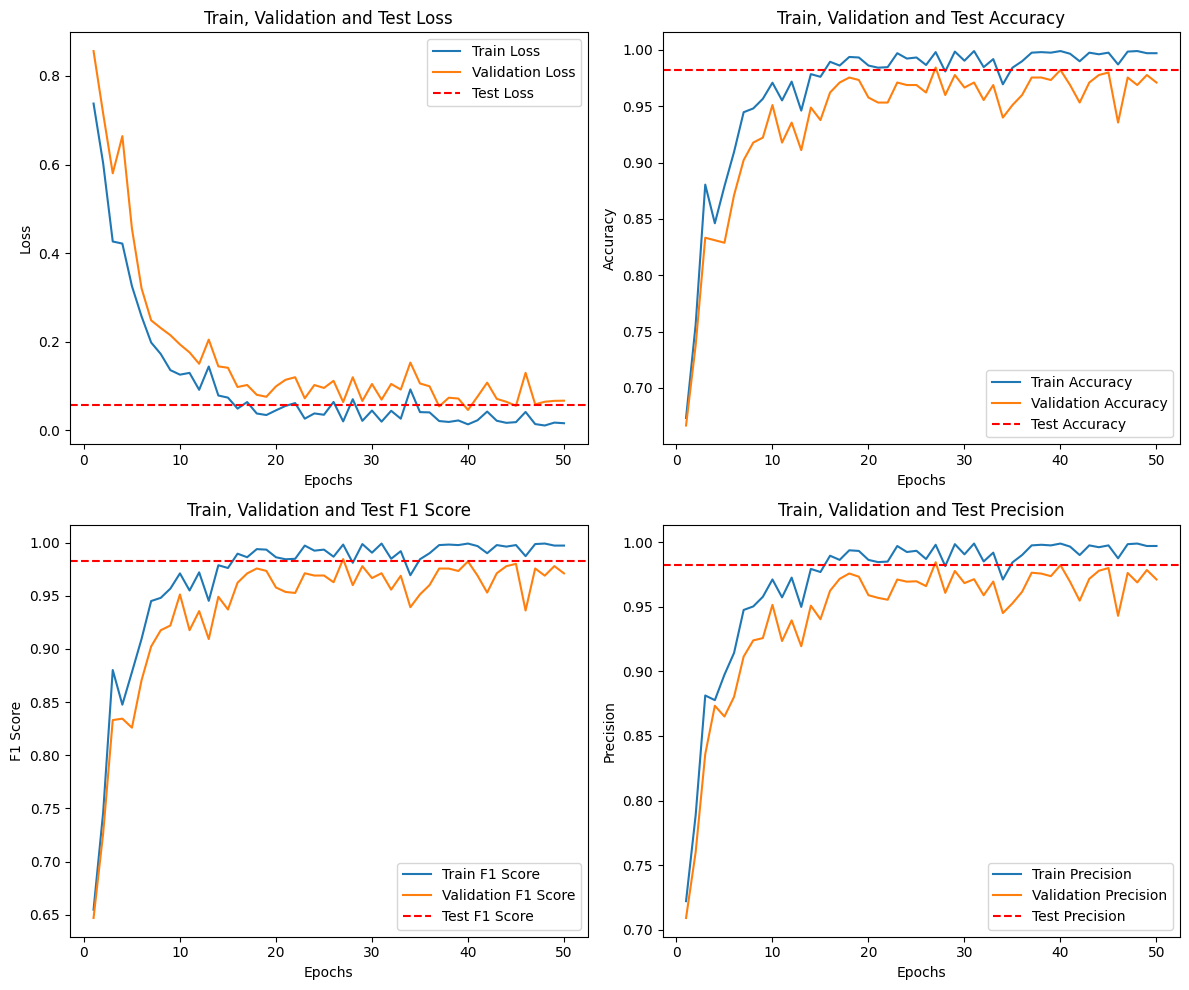

Final Test Results - Accuracy: 0.9822, Loss: 0.0579, F1: 0.9822, Precision: 0.9823, Recall: 0.9822


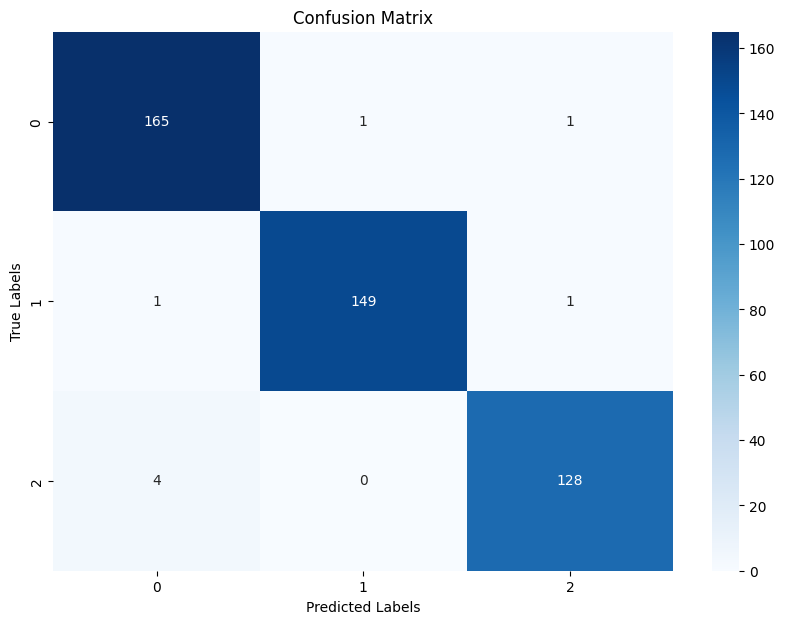

In [ ]:
# MODELLO CON DROPOUT E REGULARIZATION E EARLY STOPPING


# Parametri del modello
num_classes = 3
num_node_features = 110
num_epochs = 100
adjacency_matrices_array_1 = adjacency_coherence_matrices_array_theta
adjacency_matrices_array_2 = adjacency_pearson_matrices_array_theta
adjacency_matrices_array_3 = adjacency_plv_matrices_array_theta
threshold = 0.95
adj_arr_matrix_1 = np.where(adjacency_matrices_array_1 < threshold, 0, adjacency_matrices_array_1)
adj_arr_matrix_2 = np.where(adjacency_matrices_array_2 < threshold, 0, adjacency_matrices_array_2)
adj_arr_matrix_3 = np.where(adjacency_matrices_array_3 < threshold, 0, adjacency_matrices_array_3)


# Definizione della classe EEGDataset
class EEGDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None, pre_transform=None):
        super(EEGDataset, self).__init__('.', transform, pre_transform)
        self.data_list = data_list
        self.data, self.slices = self.collate(data_list)

    def _download(self):
        pass

    def _process(self):
        pass

# Creo il  dataset
data_list = []
for i in range(adj_arr_matrix_1.shape[0]):
    # Converti le tre matrici di adiacenza in rappresentazioni sparse
    adj_matrix_1 = adj_arr_matrix_1[i]
    edge_index_1, edge_weight_1 = dense_to_sparse(torch.tensor(adj_matrix_1, dtype=torch.float))

    adj_matrix_2 = adj_arr_matrix_2[i]
    edge_index_2, edge_weight_2 = dense_to_sparse(torch.tensor(adj_matrix_2, dtype=torch.float))

    adj_matrix_3 = adj_arr_matrix_3[i]
    edge_index_3, edge_weight_3 = dense_to_sparse(torch.tensor(adj_matrix_3, dtype=torch.float))

    # Converto le feature dei nodi in un tensore
    x = torch.tensor(features_array[i], dtype=torch.float)

    # Ottengo le labels
    y = torch.tensor(labels_array[i], dtype=torch.long)

    # Crea un oggetto Data con le tre matrici di adiacenza
    data = Data(x=x, edge_index_1=edge_index_1, edge_attr_1=edge_weight_1,
                     edge_index_2=edge_index_2, edge_attr_2=edge_weight_2,
                     edge_index_3=edge_index_3, edge_attr_3=edge_weight_3, y=y)

    # Aggiungi l'oggetto Data alla lista
    data_list.append(data)

dataset = EEGDataset(data_list)
dataset = dataset.shuffle()

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size + val_size]
test_dataset = dataset[train_size + val_size:]

# Definizione del modello GCNN con tre matrici di adiacenza
class MultiAdjGCNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, dropout_prob=0.5):
        super(MultiAdjGCNN, self).__init__()
        self.conv1_1 = GCNConv(num_node_features, hidden_channels)
        self.conv1_2 = GCNConv(num_node_features, hidden_channels)
        self.conv1_3 = GCNConv(num_node_features, hidden_channels)

        self.conv2_1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels * 3, num_classes)
        self.dropout_prob = dropout_prob

    def forward(self, data):
        x = data.x

        # Prima convoluzione con Dropout
        x1 = F.relu(self.conv1_1(x, data.edge_index_1))
        x1 = F.dropout(x1, p=self.dropout_prob, training=self.training)
        x2 = F.relu(self.conv1_2(x, data.edge_index_2))
        x2 = F.dropout(x2, p=self.dropout_prob, training=self.training)
        x3 = F.relu(self.conv1_3(x, data.edge_index_3))
        x3 = F.dropout(x3, p=self.dropout_prob, training=self.training)

        # Seconda convoluzione con Dropout
        x1 = F.relu(self.conv2_1(x1, data.edge_index_1))
        x1 = F.dropout(x1, p=self.dropout_prob, training=self.training)
        x2 = F.relu(self.conv2_2(x2, data.edge_index_2))
        x2 = F.dropout(x2, p=self.dropout_prob, training=self.training)
        x3 = F.relu(self.conv2_3(x3, data.edge_index_3))
        x3 = F.dropout(x3, p=self.dropout_prob, training=self.training)

        # Pooling globale
        x1 = global_mean_pool(x1, data.batch)
        x2 = global_mean_pool(x2, data.batch)
        x3 = global_mean_pool(x3, data.batch)

        # Concatenazione delle features
        x = torch.cat([x1, x2, x3], dim=1)

        # Strato finale lineare
        x = self.lin(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiAdjGCNN(num_node_features=110, hidden_channels=32, num_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Aggiunta regolarizzazione L2
criterion = torch.nn.CrossEntropyLoss()

def train(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    return accuracy, total_loss / len(loader), f1, precision, recall

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

best_val_loss = float('inf')
patience = 10  # numero di epoche da attendere prima di interrompere l'allenamento
epochs_without_improvement = 0

for epoch in range(num_epochs):
    train_loss = train(model, optimizer, train_loader, criterion)
    train_acc, train_loss, train_f1, train_precision, train_recall = evaluate(model, train_loader, criterion)
    val_acc, val_loss, val_f1, val_precision, val_recall = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Salva il miglior modello
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement == patience:
        print('Early stopping!')
        break

# Carica il miglior modello
model.load_state_dict(torch.load('best_model.pt'))

# Test finale
test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

print(f'Final Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Visualizzazione dei risultati
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 10))

# Plot delle perdite
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train, Validation and Test Loss')

# Plot delle accuratezze
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train, Validation and Test Accuracy')

# Plot dei F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Train, Validation and Test F1 Score')

# Plot delle Precision
plt.subplot(2, 2, 4)
plt.plot(epochs, train_precisions, label='Train Precision')
plt.plot(epochs, val_precisions, label='Validation Precision')
plt.axhline(y=test_precision, color='r', linestyle='--', label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Train, Validation and Test Precision')

plt.tight_layout()
plt.show()



# Test finale e visualizzazione della matrice di confusione
test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

print(f'Final Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Creazione della matrice di confusione
all_preds = []
all_labels = []

model.eval()
for data in test_loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    all_preds.extend(pred.cpu().numpy())
    all_labels.extend(data.y.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)

# Visualizzazione della matrice di confusione con una grafica professionale
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Fold 1/5
Epoch: 1, Train Loss: 0.7251, Val Loss: 0.7273, Train Acc: 0.7235, Val Acc: 0.7222, Train F1: 0.7177, Val F1: 0.7175
Epoch: 2, Train Loss: 0.5040, Val Loss: 0.5203, Train Acc: 0.8162, Val Acc: 0.8111, Train F1: 0.8155, Val F1: 0.8110
Epoch: 3, Train Loss: 0.3556, Val Loss: 0.4014, Train Acc: 0.8574, Val Acc: 0.8278, Train F1: 0.8539, Val F1: 0.8235
Epoch: 4, Train Loss: 0.2117, Val Loss: 0.2688, Train Acc: 0.9324, Val Acc: 0.9111, Train F1: 0.9330, Val F1: 0.9109
Epoch: 5, Train Loss: 0.1618, Val Loss: 0.2253, Train Acc: 0.9436, Val Acc: 0.9361, Train F1: 0.9436, Val F1: 0.9372
Epoch: 6, Train Loss: 0.1051, Val Loss: 0.1660, Train Acc: 0.9672, Val Acc: 0.9500, Train F1: 0.9671, Val F1: 0.9499
Epoch: 7, Train Loss: 0.0804, Val Loss: 0.1428, Train Acc: 0.9755, Val Acc: 0.9528, Train F1: 0.9755, Val F1: 0.9528
Epoch: 8, Train Loss: 0.0702, Val Loss: 0.1166, Train Acc: 0.9779, Val Acc: 0.9639, Train F1: 0.9781, Val F1: 0.9640
Epoch: 9, Train Loss: 0.0454, Val Loss: 0.1018, Train A

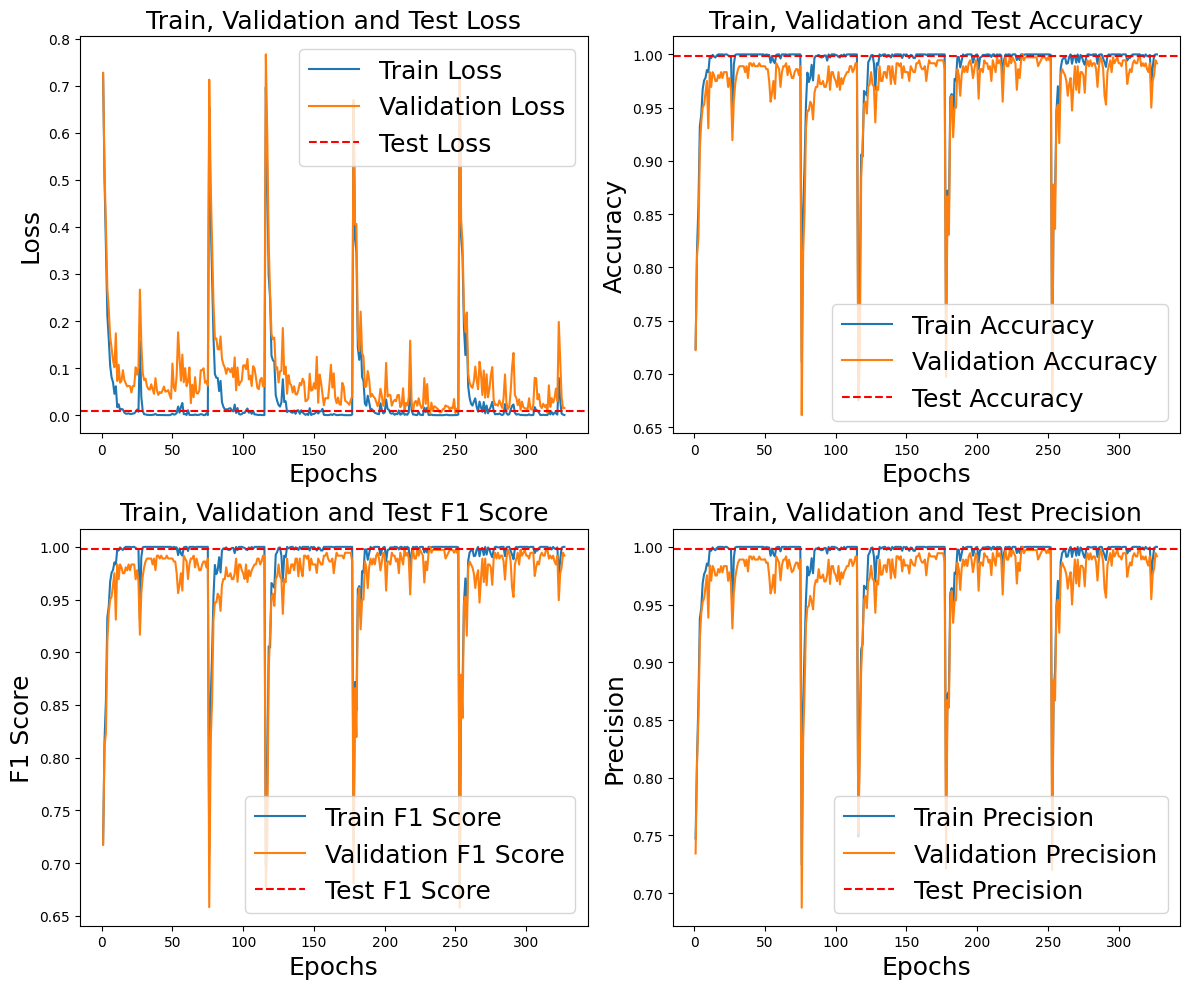

Final Test Results - Accuracy: 0.9983, Loss: 0.0085, F1: 0.9983, Precision: 0.9983, Recall: 0.9983


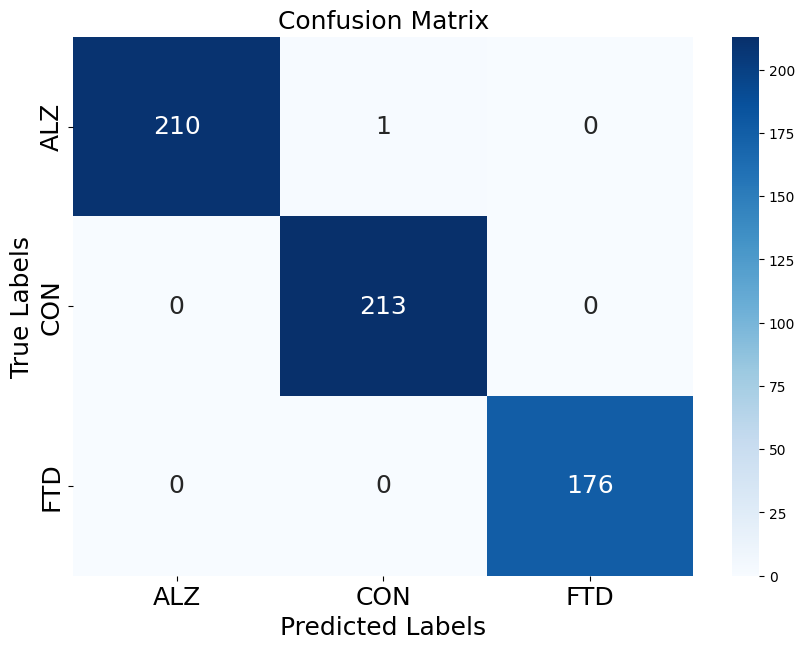

In [ ]:
# CROSS VALIDATION

# Parametri del modello
num_classes = 3
num_node_features = 110
num_epochs = 75
adjacency_matrices_array_1 = adjacency_coherence_matrices_array_theta
adjacency_matrices_array_2 = adjacency_pearson_matrices_array_theta
adjacency_matrices_array_3 = adjacency_plv_matrices_array_theta
threshold = 0.98
adj_arr_matrix_1 = np.where(adjacency_matrices_array_1 < threshold, 0, adjacency_matrices_array_1)
adj_arr_matrix_2 = np.where(adjacency_matrices_array_2 < threshold, 0, adjacency_matrices_array_2)
adj_arr_matrix_3 = np.where(adjacency_matrices_array_3 < threshold, 0, adjacency_matrices_array_3)

# Definizione della classe EEGDataset
class EEGDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None, pre_transform=None):
        super(EEGDataset, self).__init__('.', transform, pre_transform)
        self.data_list = data_list
        self.data, self.slices = self.collate(data_list)

    def _download(self):
        pass

    def _process(self):
        pass

# Creo il dataset
data_list = []
for i in range(adj_arr_matrix_1.shape[0]):
    adj_matrix_1 = adj_arr_matrix_1[i]
    edge_index_1, edge_weight_1 = dense_to_sparse(torch.tensor(adj_matrix_1, dtype=torch.float))
    adj_matrix_2 = adj_arr_matrix_2[i]
    edge_index_2, edge_weight_2 = dense_to_sparse(torch.tensor(adj_matrix_2, dtype=torch.float))
    adj_matrix_3 = adj_arr_matrix_3[i]
    edge_index_3, edge_weight_3 = dense_to_sparse(torch.tensor(adj_matrix_3, dtype=torch.float))
    x = torch.tensor(features_array[i], dtype=torch.float)
    y = torch.tensor(labels_array[i], dtype=torch.long)
    data = Data(x=x, edge_index_1=edge_index_1, edge_attr_1=edge_weight_1,
                     edge_index_2=edge_index_2, edge_attr_2=edge_weight_2,
                     edge_index_3=edge_index_3, edge_attr_3=edge_weight_3, y=y)
    data_list.append(data)

dataset = EEGDataset(data_list)
dataset = dataset.shuffle()

# Definizione del modello GCNN con tre matrici di adiacenza
class MultiAdjGCNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, dropout_prob=0.1):
        super(MultiAdjGCNN, self).__init__()
        self.conv1_1 = GCNConv(num_node_features, hidden_channels)
        self.conv1_2 = GCNConv(num_node_features, hidden_channels)
        self.conv1_3 = GCNConv(num_node_features, hidden_channels)
        self.conv2_1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_2 = GCNConv(hidden_channels, hidden_channels)
        self.conv2_3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels * 3, num_classes)
        self.dropout_prob = dropout_prob

    def forward(self, data):
        x = data.x
        x1 = F.relu(self.conv1_1(x, data.edge_index_1))
        x1 = F.dropout(x1, p=self.dropout_prob, training=self.training)
        x2 = F.relu(self.conv1_2(x, data.edge_index_2))
        x2 = F.dropout(x2, p=self.dropout_prob, training=self.training)
        x3 = F.relu(self.conv1_3(x, data.edge_index_3))
        x3 = F.dropout(x3, p=self.dropout_prob, training=self.training)
        x1 = F.relu(self.conv2_1(x1, data.edge_index_1))
        x1 = F.dropout(x1, p=self.dropout_prob, training=self.training)
        x2 = F.relu(self.conv2_2(x2, data.edge_index_2))
        x2 = F.dropout(x2, p=self.dropout_prob, training=self.training)
        x3 = F.relu(self.conv2_3(x3, data.edge_index_3))
        x3 = F.dropout(x3, p=self.dropout_prob, training=self.training)
        x1 = global_mean_pool(x1, data.batch)
        x2 = global_mean_pool(x2, data.batch)
        x3 = global_mean_pool(x3, data.batch)
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.lin(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_splits = 5  # Numero di fold per la cross-validation
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# Funzione di allenamento
def train(model, optimizer, loader, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Funzione di valutazione
def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    accuracy = correct / len(loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    return accuracy, total_loss / len(loader), f1, precision, recall

# Liste per salvare i risultati
all_train_losses, all_val_losses = [], []
all_train_accuracies, all_val_accuracies = [], []
all_train_f1_scores, all_val_f1_scores = [], []
all_train_precisions, all_val_precisions = [], []
all_train_recalls, all_val_recalls = [], []

# Cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{num_splits}')
    train_dataset = dataset[train_idx]
    val_size = int(0.15 * len(train_dataset))
    train_dataset, val_dataset = train_dataset[val_size:], train_dataset[:val_size]
    test_dataset = dataset[test_idx]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = MultiAdjGCNN(num_node_features=110, hidden_channels=32, num_classes=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-6)  # Aggiunta regolarizzazione L2
    criterion = torch.nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience = 20
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        train_loss = train(model, optimizer, train_loader, criterion)
        train_acc, train_loss, train_f1, train_precision, train_recall = evaluate(model, train_loader, criterion)
        val_acc, val_loss, val_f1, val_precision, val_recall = evaluate(model, val_loader, criterion)

        all_train_losses.append(train_loss)
        all_val_losses.append(val_loss)
        all_train_accuracies.append(train_acc)
        all_val_accuracies.append(val_acc)
        all_train_f1_scores.append(train_f1)
        all_val_f1_scores.append(val_f1)
        all_train_precisions.append(train_precision)
        all_val_precisions.append(val_precision)
        all_train_recalls.append(train_recall)
        all_val_recalls.append(val_recall)

        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement == patience:
            print('Early stopping!')
            break

    model.load_state_dict(torch.load('best_model.pt'))
    test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

    print(f'Fold {fold+1} Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

    # Visualizzazione dei risultati
    epochs = range(1, len(all_train_losses) + 1)



# Definisci una dimensione dei font da usare in tutto il grafico
font_size = 18

plt.figure(figsize=(12, 10))

# Plot delle perdite
plt.subplot(2, 2, 1)
plt.plot(epochs, all_train_losses, label='Train Loss')
plt.plot(epochs, all_val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs', fontsize=font_size)
plt.ylabel('Loss', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('Train, Validation and Test Loss', fontsize=font_size)

# Plot delle accuratezze
plt.subplot(2, 2, 2)
plt.plot(epochs, all_train_accuracies, label='Train Accuracy')
plt.plot(epochs, all_val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs', fontsize=font_size)
plt.ylabel('Accuracy', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('Train, Validation and Test Accuracy', fontsize=font_size)

# Plot dei F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, all_train_f1_scores, label='Train F1 Score')
plt.plot(epochs, all_val_f1_scores, label='Validation F1 Score')
plt.axhline(y=test_f1, color='r', linestyle='--', label='Test F1 Score')
plt.xlabel('Epochs', fontsize=font_size)
plt.ylabel('F1 Score', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('Train, Validation and Test F1 Score', fontsize=font_size)

# Plot delle Precision
plt.subplot(2, 2, 4)
plt.plot(epochs, all_train_precisions, label='Train Precision')
plt.plot(epochs, all_val_precisions, label='Validation Precision')
plt.axhline(y=test_precision, color='r', linestyle='--', label='Test Precision')
plt.xlabel('Epochs', fontsize=font_size)
plt.ylabel('Precision', fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('Train, Validation and Test Precision', fontsize=font_size)

plt.tight_layout()
plt.show()

# Test finale e visualizzazione della matrice di confusione
test_acc, test_loss, test_f1, test_precision, test_recall = evaluate(model, test_loader, criterion)

print(f'Final Test Results - Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

# Creazione della matrice di confusione
all_preds = []
all_labels = []

model.eval()
for data in test_loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    all_preds.extend(pred.cpu().numpy())
    all_labels.extend(data.y.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)

# Visualizzazione della matrice di confusione con una grafica professionale
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["ALZ", "CON", "FTD"], yticklabels=["ALZ", "CON", "FTD"], annot_kws={"size": font_size})
plt.xlabel('Predicted Labels', fontsize=font_size)
plt.ylabel('True Labels', fontsize=font_size)
plt.title('Confusion Matrix', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()


